# Load Libraries

# Travel Service Prediction Model

In [1]:
# Cargar librerias
from __future__ import absolute_import, division, print_function, unicode_literals
import os
from datetime import datetime
import datetime as dt  # Used to manage dates
import warnings                   # To ignore the warnings warnings.filterwarnings("ignore")
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams 
import seaborn as sns

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

import scipy.stats as stats 

import plotly.offline as py
from plotly import graph_objs as go
from plotly import figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

%matplotlib inline
pd.plotting.register_matplotlib_converters()
pd.options.display.float_format = '{:.4f}'.format
rcParams.update({'figure.autolayout': True, 'figure.figsize':(12,8),'axes.titlesize':14})

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_info_rows', 100)

# to make this notebook's output identical at every run
np.random.seed(42)

# Function Definitions

In [85]:
def save_data(df, file_name):
    # Write data to CSV File
    df.to_csv(path_or_buf=file_name, sep=',',index=False, encoding='utf-8')
    return

def read_data(file_name):
    df = pd.read_csv(file_name, sep=',', index_col=False, header='infer', float_precision=2 )
    return df

def draw_col_shape(df_feature,cols):
    # draw a bar graph with he number of members of a columns specify in field Cols
    
    # Dictionary for X Axis Labels
    dict_cols = { 'income':'Income', 'member_status':'Member Status','state_grouped': 'State', 'credit_ranges':'Credit Range',
                 'cancel_reason':'Cancel Reason','renew_method':'Renewal Method','sc_vehicle_manufacturer_name':'Vehicle Manufacturer',
                 'sc_vehicle_model_name':'Vehicle Model','race': 'Ethnic Group','home_owner': 'Home Owner','education':'Education Level', 
                 'dwelling_type': 'Dwelling Type', 'gender':'Gender','occupation_code':'Occupation', 'occupation_group':'Occupation Group',
                 'occupant_type': 'Occupant Type','mosaic_household':'Mosaic household','mosaic_global_household':'Global Mosaic',
                 'kcl_b_ind_mosaicsgrouping':'Mosaic Grouping', 'plus_indicator_description':'Membership Type',
                 'tenure':'Tenure Range', 'generation':'Generation', 'total_calls':'Total Breakdown Calls', 'aaa_mortgage':'Used Mortgage Service',
                  'aaa_credit_card':'Use Credit Card Service','aaa_deposit':'Use Deposit Service','aaa_travel':'Travel Services',
                 'aaa_home_equity':'Use Home Equity Service', 'aaa_financial_service':'Use Financial Service', 
                 'aaa_auto_insurance':'Use Insurance Service', 'vehicle':'Vehicle','total_member_cost':'Total Member Avg. Costs',
                 'no_members':'Total Members with Household', 'aaa_id_theft':'ID Theft Service'
                }


    # number of members per state

    for col in cols:
        counts = df_feature[col].value_counts()
        sns.set(style="whitegrid")
        plt.axhline(0, color="k", clip_on=False)
        plt.ylabel("# of Classes",fontsize=14, fontweight='bold')
        plt.xlabel("Classes", fontsize=14, fontweight='bold')
        plt.title('Total  Number of Classes',loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
        sns.barplot(counts.index, counts.values)
        plt.xticks(
            rotation=45, 
            horizontalalignment='right',
            fontweight='light',
            fontsize='large')
        i = 0
        for v in list(counts.values):
            plt.text(i-.25, v, str(v), color='blue', fontweight='bold')
            i +=1
        plt.show()
        counts = pd.DataFrame(df_feature[col].value_counts().nlargest(15), index=None)
        counts.reset_index(inplace=True)
        counts.rename(columns={"index": dict_cols[col], col: "# of Classes"}, inplace=True)
        fig = ff.create_table(counts, height_constant=30, index=False)
        py.iplot(fig)
        return

def cross_entropy(predictions, targets, epsilon=1e-10):
    # To calculate the cross Entropy Loss to validate model performance
    # Cross Entropy Loss
        # Cross-entropy loss, or log loss, measures the performance of a classification model 
        # whose output is a probability value between 0 and 1. #
        # Cross-entropy loss increases as the predicted probability diverges from the actual label. 
        # So predicting a probability of .012 when the actual observation label is 1 would be bad and 
        # result in a high loss value. # A perfect model would have a log loss of 0.
        
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce_loss = -np.sum(np.sum(targets * np.log(predictions + 1e-5)))/N
    return ce_loss

# Load data from consolidate file by household key and transacton file 

In [3]:
# Load data from the View create using Capstone AAA - EDA .ipynb
df_household = read_data('household_view.csv')
df_transaction = read_data('capstone_aaa_featured.csv')
df_original_house_hold = df_household.copy()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
var_to_predict = ['aaa_travel']
var_to_predict_title = 'Travel Services'
var_to_predict_save = 'trav'
test_size = 0.5

In [4]:
df_household.groupby(by=var_to_predict).mean()

,membership_id,household_key,zip,aaa_no_tenure,aaa_member_tenure_years,aaa_mean_age,length_of_residence,aaa_mortgage,aaa_credit_card,aaa_deposit,aaa_home_equity,aaa_financial_service,aaa_auto_insurance,aaa_id_theft,aaa_motorcycle_indicator,aaa_mean_child,aaa_mean_total_cost,aaa_no_race,aaa_no_home_owner,aaa_no_education,aaa_no_income,aaa_no_dwelling_type,aaa_no_credit_ranges,aaa_no_gender,aaa_no_language,aaa_no_reason_joined,aaa_cancel_reason,aaa_no_mosaic_household,aaa_no_mosaic_global_household,aaa_no_kcl_b_ind_mosaicsgrouping,aaa_no_occupation_code,aaa_no_occupation_group,aaa_no_occupant_type,aaa_no_plus_indicator_description,aaa_no_generation,total_calls_year_1,total_calls_year_2,total_calls_year_3,total_member_cost_1,total_member_cost_2,total_member_cost_3,basic_cost,plus_cost,premier_cost,mean_basic_cost,mean_plus_cost,mean_premier_cost,total_calls,total_member_cost,mean_total_member_cost,total_cost,mean_total_cost,total_members_in_household
aaa_travel,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,129402.0802,15033277.9742,3087.7854,1.0141,46.6816,75.4939,5.7508,0.0627,0.0943,0.0051,0.0013,0.0627,0.2621,0.0378,0.5450,1.6972,21.8036,2.7987,0.1178,1.9749,5.1207,0.4224,2.5403,1.5812,0.1913,2.8209,3.8565,10.9533,3.1724,5.0307,7.1784,5.6549,1.2924,0.9519,0.9491,1.5741,2.8596,2.9221,84.9818,154.8343,150.0030,106.9953,8.5831,0.0212,20.1436,1.4140,0.0069,7.3557,389.8191,53.9875,118.9327,21.8036,2.2676
1,102955.3702,13572057.3798,3093.0328,0.8019,46.8689,69.8136,7.4806,0.1148,0.2090,0.0068,0.0000,0.1148,0.3525,0.0874,0.5859,1.8084,26.9589,2.7179,0.0772,1.9614,4.9509,0.3213,2.4230,1.6518,0.1466,2.3000,4.6457,9.5533,2.8065,4.6293,7.4805,6.1556,1.4000,1.0629,1.4315,2.0738,3.6352,3.7842,113.5988,203.1294,199.9330,150.0622,12.6325,0.0000,24.9767,1.7066,0.0000,9.4932,516.6612,62.6908,164.6699,26.9589,2.8292


In [5]:
df_transaction.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21343 entries, 0 to 21342
Data columns (total 166 columns):
individual_key                    int64
household_key                     int64
member_flag                       int64
city                              object
state_grouped                     object
zip5                              int64
zip9                              int64
fsv_cmsi_flag                     int64
fsv_credit_card_flag              int64
fsv_deposit_program_flag          int64
fsv_home_equity_flag              int64
fsv_id_theft_flag                 int64
fsv_mortgage_flag                 int64
ins_client_flag                   int64
trv_globalware_flag               int64
number_of_children                object
responded_to_catalog              object
race                              object
length_of_residence               int64
mail_responder                    object
home_owner                        object
income                            object
da

In [6]:
df_transaction.groupby(by=['membership_id','trv_globalware_flag']).mean()

,,individual_key,household_key,member_flag,zip5,zip9,fsv_cmsi_flag,fsv_credit_card_flag,fsv_deposit_program_flag,fsv_home_equity_flag,fsv_id_theft_flag,fsv_mortgage_flag,ins_client_flag,length_of_residence,do_not_direct_mail_solicit,email_available,ers_ent_count_year_1,ers_ent_count_year_2,ers_ent_count_year_3,ers_member_cost_year_1,ers_member_cost_year_2,ers_member_cost_year_3,right_individual_key,member_key,member_number_associate_id,member_tenure_years,months_from_join_to_cancel,zip,new_mover_flag,basic_cost,calculated_tow_miles,call_canceled,call_killed,cash_call,fleet_indicator,is_duplicate,is_nsr,member_match_flag,member_number_and_associate_id,motorcycle_indicator,plus_cost,premier_cost,rec_id,total_cost,tow_destination_latitude,tow_destination_longitude,was_duplicated,was_towed_to_aar_referral,no_child,no_race,no_home_owner,no_education,no_income,no_dwelling_type,no_credit_ranges,no_gender,no_cancel_reason,no_language,no_billing_code_description,no_county,no_member_status,no_opt_out_publication,no_reason_joined,no_renew_method,no_mosaic_household,no_mosaic_global_household,no_kcl_b_ind_mosaicsgrouping,no_occupation_code,no_occupation_group,no_occupant_type,no_right_dwelling_type,no_plus_indicator_description,no_generation,no_tenure,total_calls,total_member_cost,aed_yyyymm,aed_yyyy,aed_yyyywk,aed_wk,aed_mth,reins_yyyymm,reins_yyyy,reins_yyyywk,reins_wk,reins_mth,cancel_yyyymm,cancel_yyyy,cancel_yyyywk,cancel_wk,cancel_mth,birth_yyyymm,birth_yyyy,birth_yyyywk,birth_wk,birth_mth,csrd_yyyymm,csrd_yyyy,csrd_yyyywk,csrd_wk,csrd_mth,age
membership_id,trv_globalware_flag,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
153,0,52211550.0000,4500791.0000,1.0000,2893.0000,28933850.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,15.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,65.0000,52211550.0000,1500014.0000,15300.0000,49.0000,0.0000,2893.0000,0.0000,33.8333,0.0889,0.0000,0.0000,0.1111,0.1111,0.0000,0.1111,1.0000,15300.0000,0.0000,0.0000,0.0000,6563853.6667,33.8333,4.5556,-7.8889,0.0000,0.1111,2.0000,2.0000,0.0000,1.0000,8.0000,2.0000,5.0000,nan,nan,0.0000,4.0000,1.0000,0.0000,0.0000,nan,1.0000,11.0000,7.0000,3.0000,nan,nan,nan,nan,0.0000,0.0000,0.0000,2.0000,65.0000,202009.0000,2020.0000,20202.0000,2.0000,9.0000,201908.0000,2019.0000,20195.0000,5.0000,8.0000,nan,nan,nan,nan,nan,192202.0000,1922.0000,19220.0000,0.0000,2.0000,201616.8889,2016.1111,20164.3333,3.2222,5.7778,97.0000
155,0,1606764.0000,4317516.0000,1.0000,2878.0000,28781026.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1606764.0000,1500016.0000,15500.0000,13.0000,85.0000,2878.0000,0.0000,0.0000,0.0000,nan,nan,nan,nan,0.0000,0.0000,0.0000,0.0000,nan,0.0000,0.0000,0.0000,0.0000,nan,nan,0.0000,0.0000,nan,nan,nan,nan,nan,0.0000,nan,nan,2.0000,nan,1.0000,3.0000,1.0000,0.0000,nan,0.0000,1.0000,1.0000,1.0000,nan,nan,nan,nan,nan,nan,1.0000,0.0000,0.0000,201402.0000,2014.0000,20146.0000,6.0000,2.0000,nan,nan,nan,nan,nan,201302.0000,2013.0000,20135.0000,5.0000,2.0000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
163,0,2766867.7778,11622991.0000,1.0000,2889.0000,28892920.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8.5556,0.0000,0.7778,0.3333,0.6667,0.0000,19.6167,39.2333,0.0000,2766867.7778,8216206.7778,16314.3333,11.0000,74.6667,2889.0000,0.0000,39.2056,0.0000,0.0000,0.0000,0.0000,0.8571,0.0000,0.1111,0.7778,12687.5556,0.2000,0.0000,0.0000,4063201.4444,39.2056,0.0000,0.0000,0.0000,0.0000,1.0000,3.7778,0.0000,2.0000,4.0000,0.0000,1.0000,nan,1.0000,0.0000,0.2222,1.0000,0.2222,0.0000,nan,0.7778,3.0000,3.0000,4.0000,nan,nan,nan,nan,0.2857,2.0000,4.7778,1.0000,58.8500,201836.1111,2018.3333,20188.3333,5.0000,2.7778,nan,nan,nan,nan,nan,201155.5000,2011.5000,20118.0000,3.0000,5.5000,197085.6667,1970.7778,19711.4444,3.6667,7.8889,201589.1429,2015.8571,20161.7143,3.1429,3.4286,47.6667
182,0,13746947.0000,579810.0000,1.0000,2863.0000,28631322.00

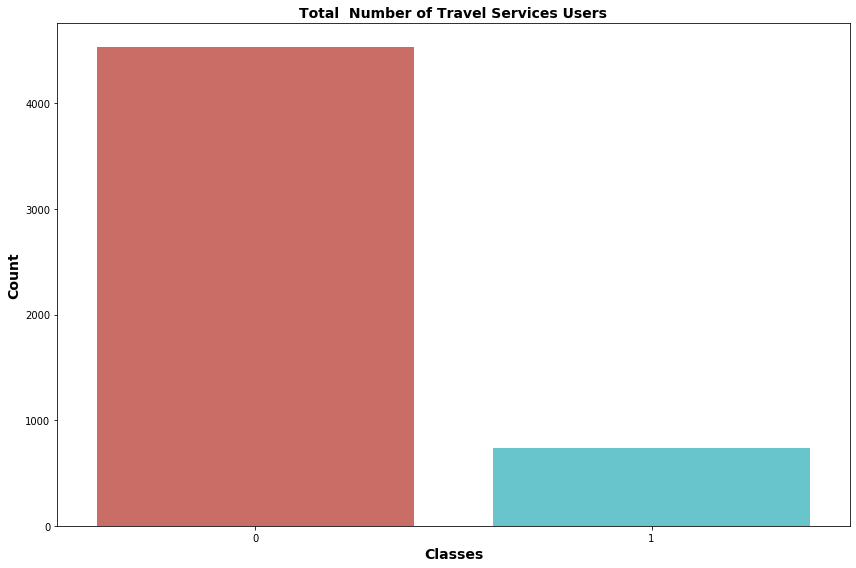

In [7]:
plt.figure(figsize=(12,8))
sns.countplot(x=var_to_predict[0],data=df_household, palette='hls')
plt.title('Total  Number of '+var_to_predict_title + ' Users',loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
plt.ylabel("Count",fontsize=14, fontweight='bold')
plt.xlabel("Classes", fontsize=14, fontweight='bold')
plt.savefig(var_to_predict_save+'_count_plot')
plt.show()

In [8]:
# Number of members in household key
df_household.total_members_in_household.value_counts()

2     1907
1     1523
3      932
4      529
5      234
6       73
7       42
8        9
9        7
10       4
15       1
Name: total_members_in_household, dtype: int64

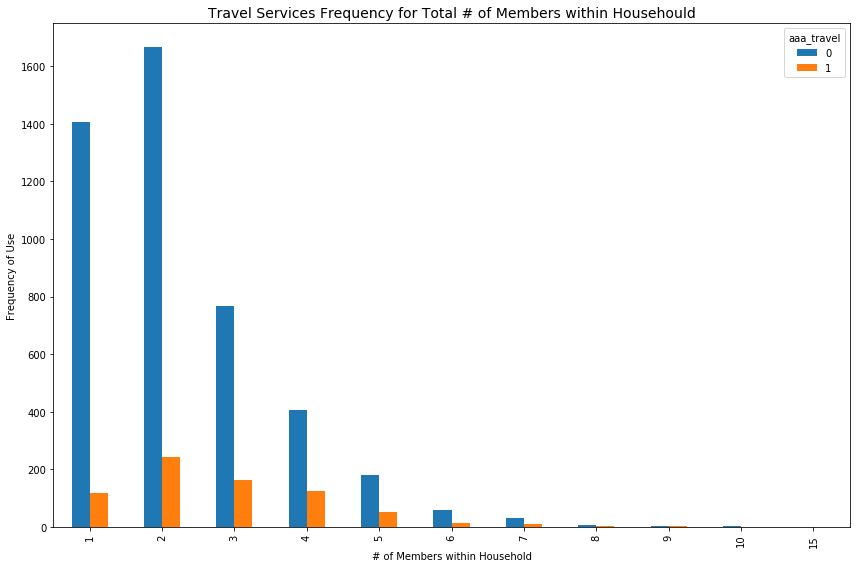

In [9]:
# graph income
pd.crosstab(df_household.total_members_in_household,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title + ' Frequency for Total # of Members within Househould')
plt.xlabel('# of Members within Household')
plt.ylabel('Frequency of Use')
plt.savefig('members_hh_use_'+var_to_predict_save)
plt.show()

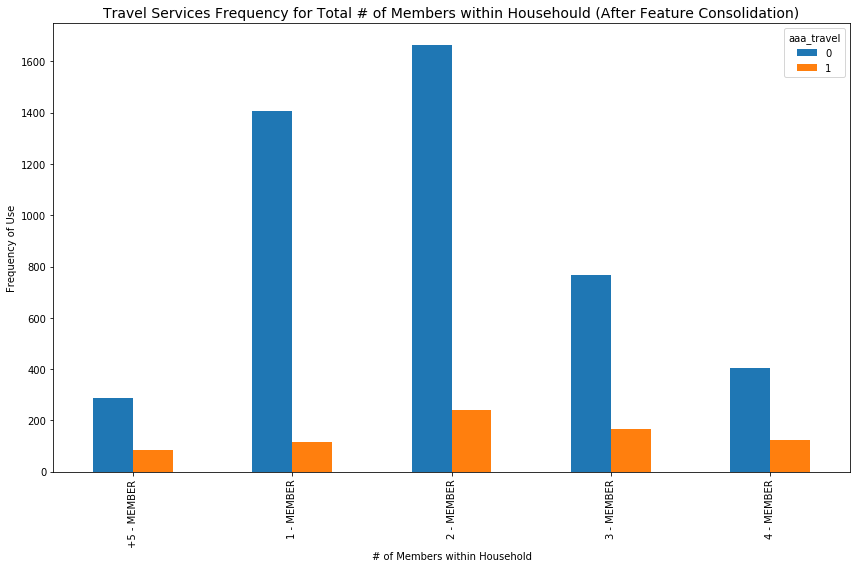

In [10]:
# Number of members

df_household['no_members'] = ' '
df_household['no_members']=np.where(df_household['total_members_in_household']== 1, '1 - MEMBER', 
                                    df_household['no_members'])
df_household['no_members']=np.where(df_household['total_members_in_household']== 2, '2 - MEMBER', 
                                    df_household['no_members'])
df_household['no_members']=np.where(df_household['total_members_in_household']== 3, '3 - MEMBER', 
                                    df_household['no_members'])
df_household['no_members']=np.where(df_household['total_members_in_household']== 4, '4 - MEMBER', 
                                    df_household['no_members'])

df_household['no_members']=np.where(df_household['total_members_in_household']> 4, '5 - MEMBER', 
                                    df_household['no_members'])
group5 = np.arange(5,20,1)
for i in group5:
    df_household['no_members']=np.where(df_household['total_members_in_household']== i, '+5 - MEMBER', 
                                    df_household['no_members'])
    
pd.crosstab(df_household.no_members,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Total # of Members within Househould (After Feature Consolidation)')
plt.xlabel('# of Members within Household')
plt.ylabel('Frequency of Use')
plt.savefig('members_hh_'+var_to_predict_save+'_feat')

In [11]:
# Income
df_household.income.value_counts()

UNKNOWN          2026
100-149,999       655
90-99,999         612
70-79,999         293
50-59,999         274
10-19,999         230
40-49,999         224
30-39,999         156
60-69,999         153
20-29,999         144
175 - 199,999     139
150 - 174,999     102
200 - 249,999      96
250K+              88
UNDER 10K          67
80-89,999           2
Name: income, dtype: int64

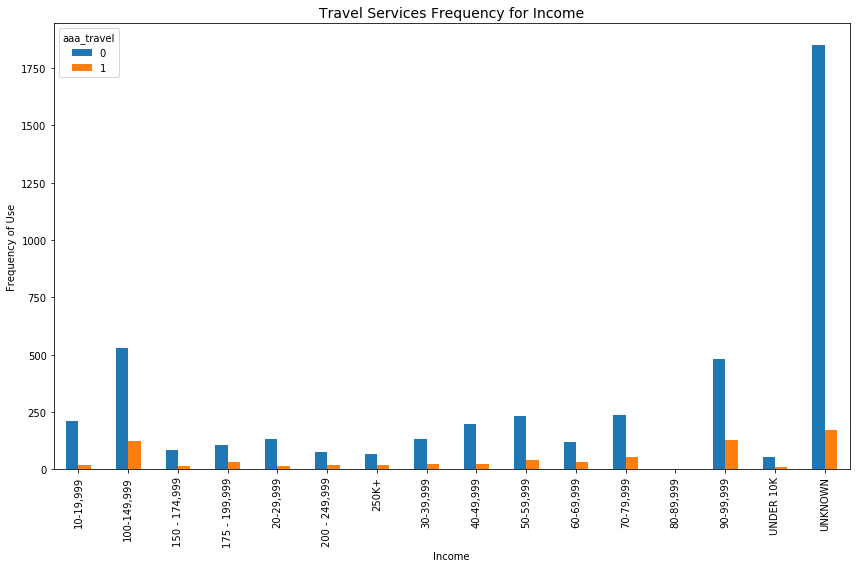

In [12]:
# graph income
pd.crosstab(df_household.income,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Income')
plt.xlabel('Income')
plt.ylabel('Frequency of Use')
plt.savefig('income_use_'+var_to_predict_save)

# Outcomes
The frequency of travel Service use depend heavvily on income. 
Will consolidate income in three categories: 
    * a) under 10k - 39999: Under 39.999
    * b) 40 - 99,999 : 40 - 99,999
    * c) 100k and above : 100+
    

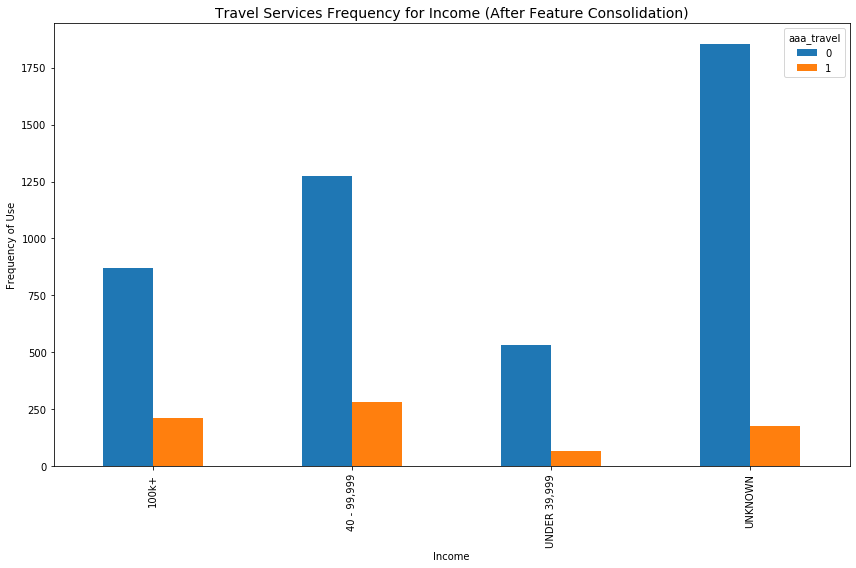

In [13]:
group1 = ['UNDER 10K', '10-19,999','20-29,999', '30-39,999']
group2 = ['40-49,999', '50-59,999', '60-69,999', '70-79,999', '80-89,999', '90-99,999']
group3 = ['100-149,999', '150 - 174,999', '175 - 199,999', '200 - 249,999', '250K+' ]
for i in group1:
    df_household['income']=np.where(df_household['income']== i, 'UNDER 39,999', df_household['income'])
for i in group2:
    df_household['income']=np.where(df_household['income']== i, '40 - 99,999', df_household['income'])
for i in group3:
    df_household['income']=np.where(df_household['income']== i, '100k+', df_household['income'])

pd.crosstab(df_household.income,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Income (After Feature Consolidation)')
plt.xlabel('Income')
plt.ylabel('Frequency of Use')
plt.savefig('income_use_feat_'+var_to_predict_save)

In [14]:
# Tenures
df_household.tenure.value_counts()

+40 YEARS                3772
BETWEEN 31 & 40 YEARS     380
BETWEEN 21 & 30 YEARS     304
BETWEEN 6 & 10 YEARS      235
BETWEEN 11 & 15 YEARS     227
BETWEEN 1 & 5 YEARS       166
BETWEEN 16 & 20 YEARS     165
< 1 YEAR                   12
Name: tenure, dtype: int64

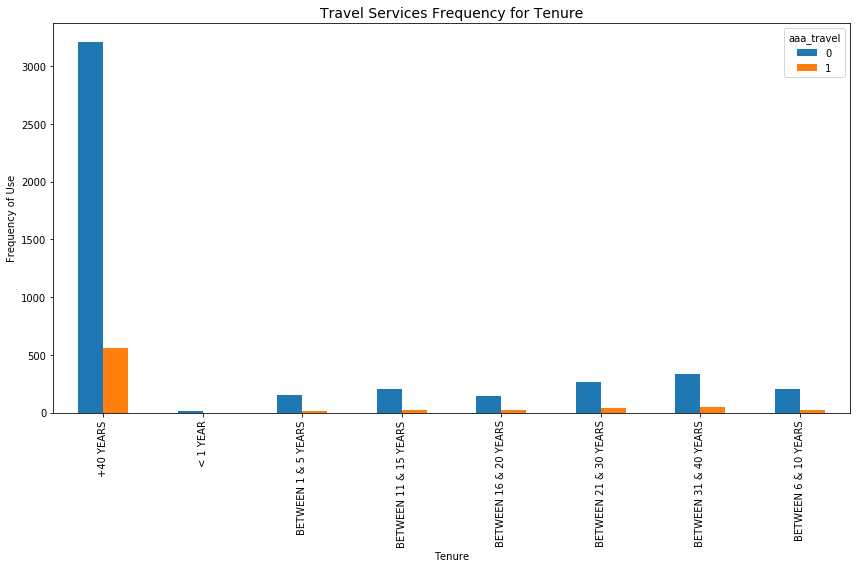

In [15]:
# graph tenure
pd.crosstab(df_household.tenure,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Tenure')
plt.xlabel('Tenure')
plt.ylabel('Frequency of Use')
plt.savefig('tenure_use_'+var_to_predict_save)

# Outcomes
The frequency of Travel Service use depend heavily on tenures. Will consolidate tenure in three categories: 
    * a) above 40 years  
    * b) between 21 - 40 
    * c) Less 21 


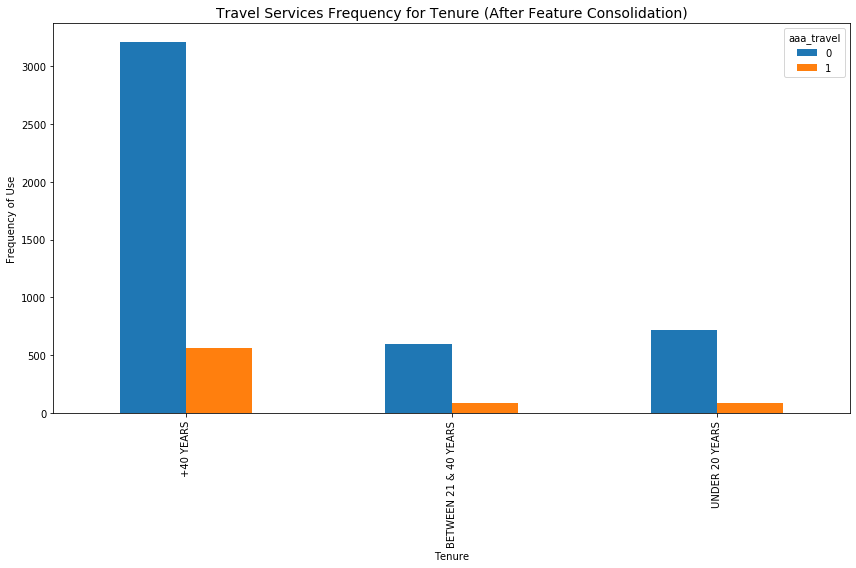

In [16]:
group1 = ['BETWEEN 6 & 10 YEARS', 'BETWEEN 11 & 15 YEARS', 
          'BETWEEN 16 & 20 YEARS', 'BETWEEN 1 & 5 YEARS', '< 1 YEAR']
group2 = ['BETWEEN 31 & 40 YEARS', 'BETWEEN 21 & 30 YEARS']
group3 = ['+40 YEARS']
for i in group1:
    df_household['tenure']=np.where(df_household['tenure']== i, 'UNDER 20 YEARS', df_household['tenure'])
for i in group2:
    df_household['tenure']=np.where(df_household['tenure']== i, 'BETWEEN 21 & 40 YEARS', df_household['tenure'])
for i in group3:
    df_household['tenure']=np.where(df_household['tenure']== i, '+40 YEARS', df_household['tenure'])

pd.crosstab(df_household.tenure,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Tenure (After Feature Consolidation)')
plt.xlabel('Tenure')
plt.ylabel('Frequency of Use')
plt.savefig('tenure_use_feat_'+var_to_predict_save)

In [17]:
# Credit Ranges
df_household.credit_ranges.value_counts()

UNKNOWN       2123
750-799       1143
700-749        688
650-699        503
800+           476
600-649        230
550-599         54
500-549         40
499 & LESS       4
Name: credit_ranges, dtype: int64

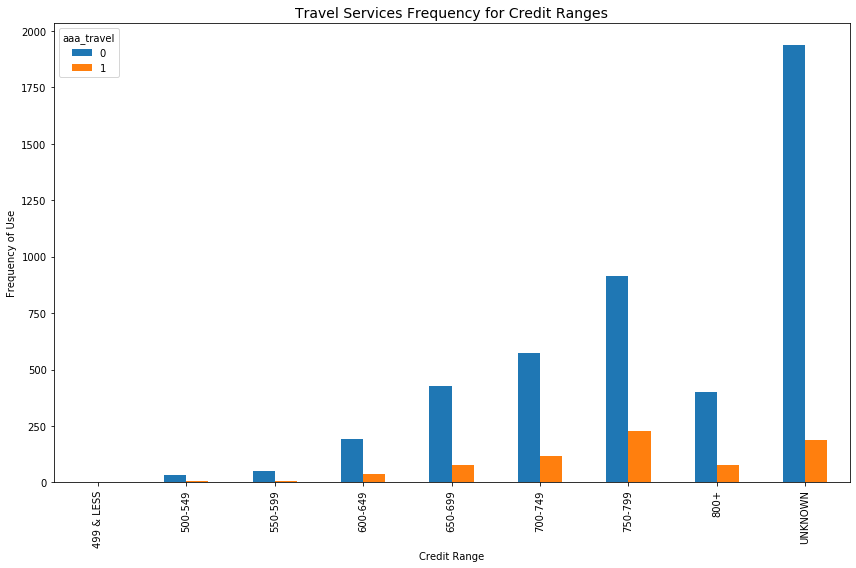

In [18]:
# graph credit ranges
pd.crosstab(df_household.credit_ranges,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Credit Ranges')
plt.xlabel('Credit Range')
plt.ylabel('Frequency of Use')
plt.savefig('credit_ranges_use_'+var_to_predict_save)

# Outcomes
The frequency of travel Service use depend heavily on credit_ranges. Will consolidate tenure in three categories: 
    * a) above 800 years 
    * b) between 700 - 799 
    * c) Below 700

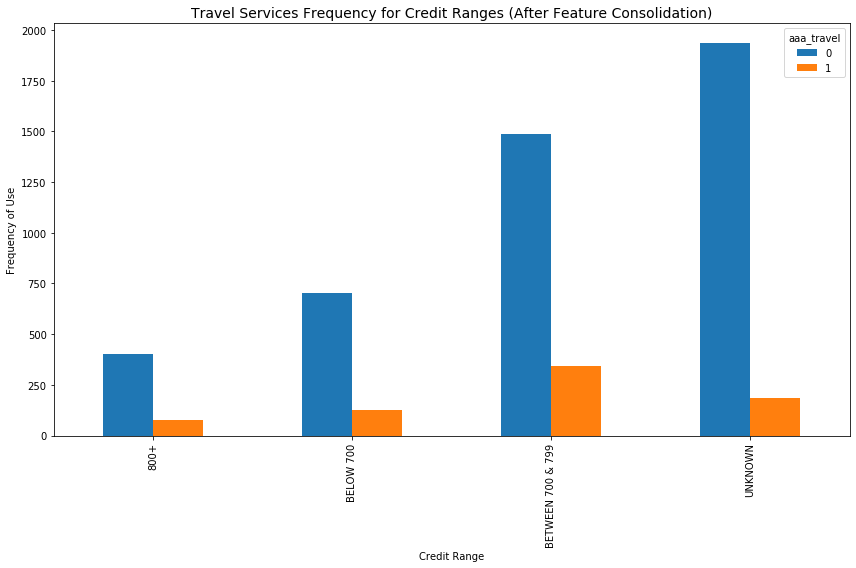

In [19]:
group1 = ['499 & LESS', '500-549','550-599','600-649', '650-699']
group2 = ['700-749', '750-799']
group3 = ['800+']
for i in group1:
    df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, 'BELOW 700', df_household['credit_ranges'])
for i in group2:
    df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, 'BETWEEN 700 & 799', df_household['credit_ranges'])
for i in group3:
    df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, '800+', df_household['credit_ranges'])

pd.crosstab(df_household.credit_ranges,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Credit Ranges (After Feature Consolidation)')
plt.xlabel('Credit Range')
plt.ylabel('Frequency of Use')
plt.savefig('credit_ranges_use_feat_'+var_to_predict_save)

In [20]:
# Education
df_household.education.value_counts()

UNKNOWN              2942
SOME COLLEGE          928
HIGH SCHOOL           853
COMPLETED COLLEGE     486
GRADUATED SCHOOL       52
Name: education, dtype: int64

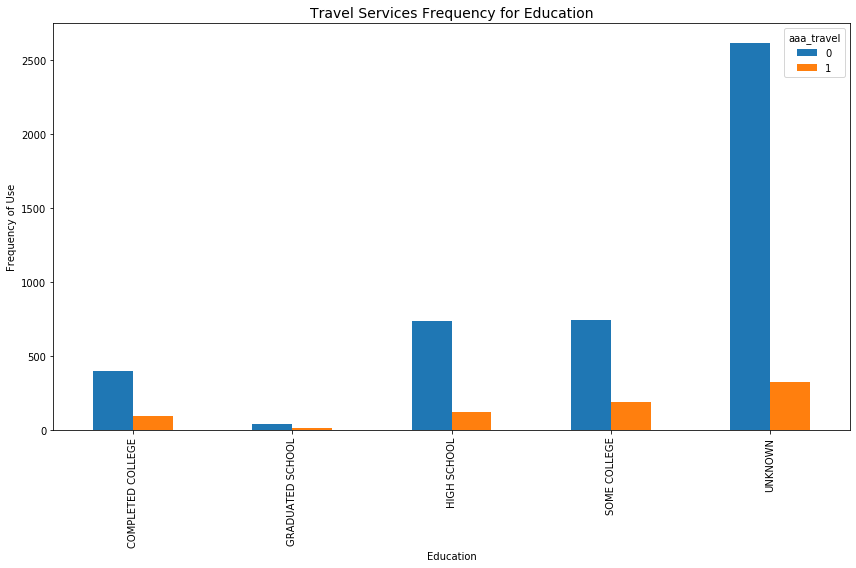

In [21]:
# graph education
pd.crosstab(df_household.education,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Education')
plt.xlabel('Education')
plt.ylabel('Frequency of Use')
plt.savefig('education_use_'+var_to_predict_save)

# Outcomes
The frequency of travel Service use depend heavily on education. Will consolidate graduate with completed collegue

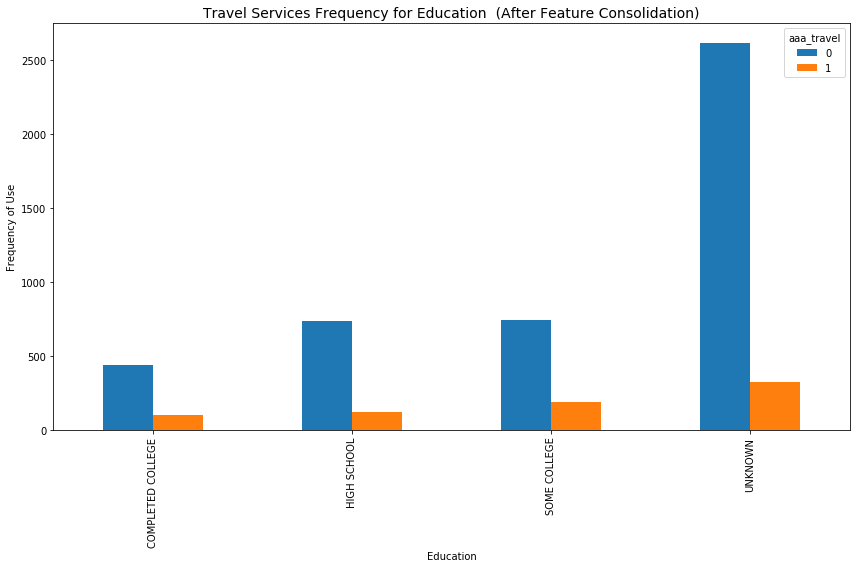

In [22]:
# graph education
df_household['education']=np.where(df_household['education'] =='GRADUATED SCHOOL', 
                                   'COMPLETED COLLEGE', df_household['education']
                                  )
pd.crosstab(df_household.education,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Education  (After Feature Consolidation)')
plt.xlabel('Education')
plt.ylabel('Frequency of Use')
plt.savefig('education_use_feat_'+var_to_predict_save)

In [23]:
# Generation
df_household.generation.value_counts()

POST-WAR (< 1948)             3624
BABY BOOMERS (1948 - 1968)    1157
UNKNOWN                        349
GENERATION X (1969 - 1980)      78
MILLENIALS (1981 - 1993)        48
GENERATION Z (1994 - 2010)       5
Name: generation, dtype: int64

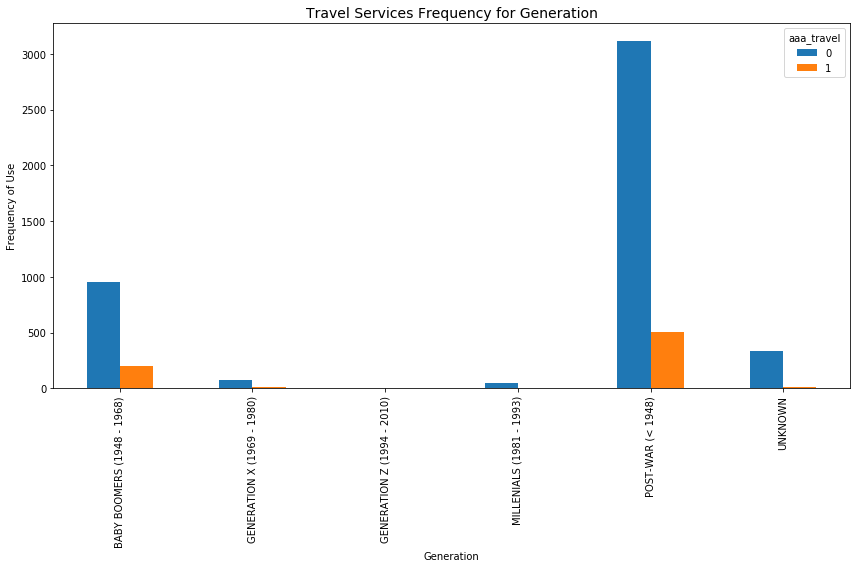

In [24]:
# graph Generation
pd.crosstab(df_household.generation,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Generation')
plt.xlabel('Generation')
plt.ylabel('Frequency of Use')
plt.savefig('generation_use_'+var_to_predict_save)

In [25]:
# Race
df_household.race.value_counts()

UNKNOWN                                   2084
CAUCASION / WHITE - EUROPEAN              1455
CAUCASION / WHITE - ENGLISH                778
CAUCASION / WHITE - WHITE NON-AMERICAN     295
CAUCASION / WHITE - UNKNOWN                127
MIDDLE EASTERN - ARAB                      126
HISPANIC - HISPANIC ORIGIN                 106
CAUCASION / WHITE - EASTERN EUROPEAN        96
HISPANIC - PORTUGUESE ORIGIN                86
CAUCASION / WHITE - JEWISH                  23
ASIAN - CHINESE                             20
CAUCASION / WHITE - GREEK                   16
ASIAN - UNKNOWN                             12
AFRICAN AMERICAN - AFRICAN ORIGIN           10
AMERICAN INDIAN                              7
ASIAN - JAPANESE                             6
ASIAN - INDIAN                               6
MIDDLE EASTERN - EGYPTIAN                    5
CAUCASION / WHITE - DUTCH                    2
ASIAN - ORIENTAL                             1
Name: race, dtype: int64

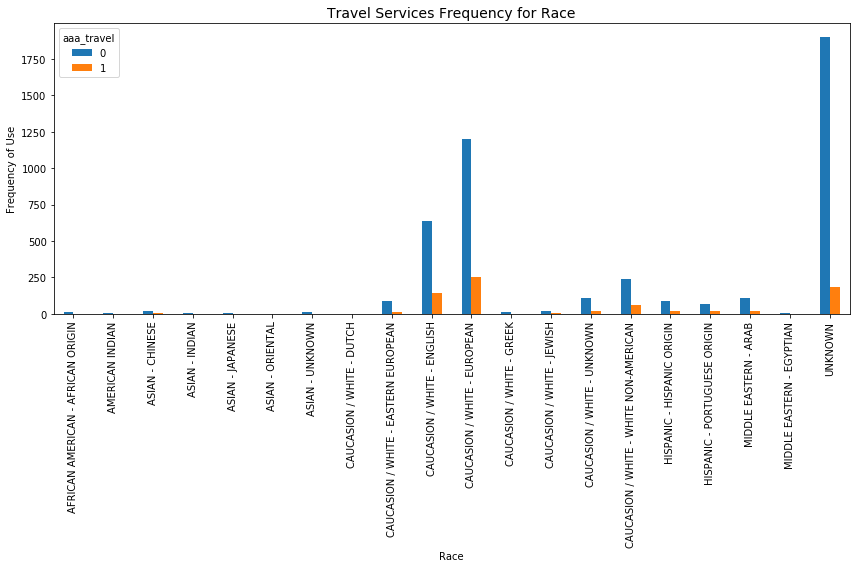

In [26]:
# graph race
pd.crosstab(df_household.race,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Race')
plt.xlabel('Race')
plt.ylabel('Frequency of Use')
plt.savefig('race_use_'+var_to_predict_save)

# Observations
The frequency of travel Service use depend heavily on race being caucasion- white group the predominant. 
I Will consolidate them in more similar groups
    * a) Caucasion - White
    * b) Hispanic
    * c) Asian
    * d) Arabs
    * e) America Africans / Indians

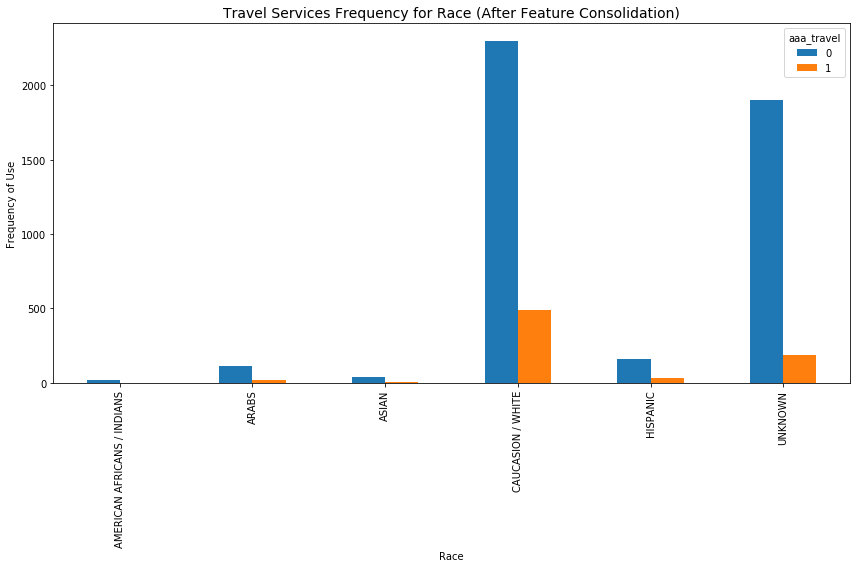

In [27]:
group1 = ['CAUCASION / WHITE - EUROPEAN', 'CAUCASION / WHITE - ENGLISH', 'CAUCASION / WHITE - WHITE NON-AMERICAN',
          'CAUCASION / WHITE - UNKNOWN', 'CAUCASION / WHITE - EASTERN EUROPEAN', 'CAUCASION / WHITE - JEWISH',
          'CAUCASION / WHITE - GREEK', 'CAUCASION / WHITE - DUTCH'
         ]
group2 = ['HISPANIC - HISPANIC ORIGIN', 'HISPANIC - PORTUGUESE ORIGIN']
group3 = ['ASIAN - CHINESE', 'ASIAN - UNKNOWN', 'ASIAN - JAPANESE', 'ASIAN - INDIAN', 'ASIAN - ORIENTAL']
group4 = ['MIDDLE EASTERN - ARAB', 'MIDDLE EASTERN - EGYPTIAN']
group5 = ['AFRICAN AMERICAN - AFRICAN ORIGIN', 'AMERICAN INDIAN']

for i in group1:
    df_household['race']=np.where(df_household['race']== i, 'CAUCASION / WHITE', df_household['race'])
for i in group2:
    df_household['race']=np.where(df_household['race']== i, 'HISPANIC', df_household['race'])
for i in group3:
    df_household['race']=np.where(df_household['race']== i, 'ASIAN', df_household['race'])
for i in group4:
    df_household['race']=np.where(df_household['race']== i, 'ARABS', df_household['race'])
for i in group5:
    df_household['race']=np.where(df_household['race']== i, 'AMERICAN AFRICANS / INDIANS', df_household['race'])

pd.crosstab(df_household.race,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Race (After Feature Consolidation)')
plt.xlabel('Race')
plt.ylabel('Frequency of Use')
plt.savefig('race_use_feat_'+var_to_predict_save)

In [28]:
# Home Owner
df_household.home_owner.value_counts()

HOME OWNER             3003
UNKNOWN                2120
RENTER                  129
PROBABLE RENTER           6
PROBABLE HOME OWNER       3
Name: home_owner, dtype: int64

# Outcomes
The frequency of travel Service use depend heavily on home_owner.  Will leave consolidate probable renter with RENTER and probable home owner with home owner 

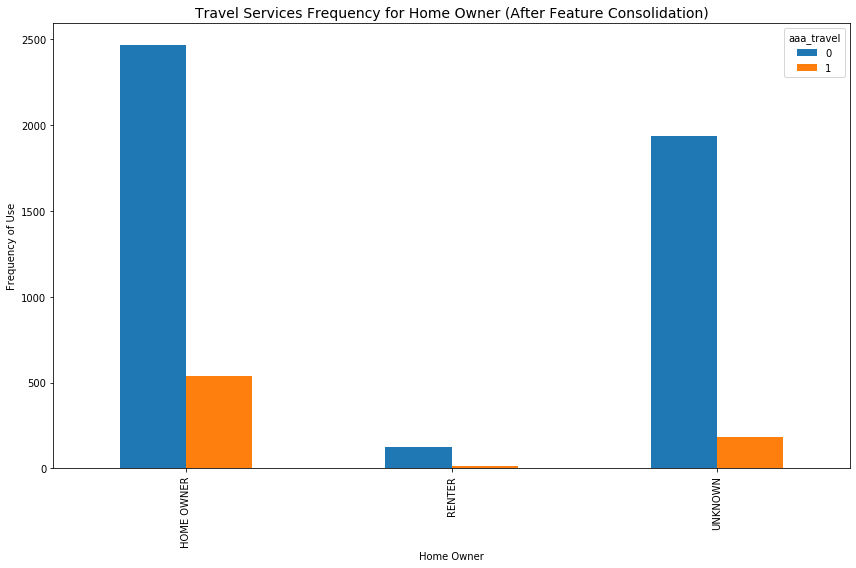

In [29]:
# Home Owner
df_household['home_owner']=np.where(df_household['home_owner']== 'PROBABLE RENTER', 'RENTER', df_household['home_owner'])
df_household['home_owner']=np.where(df_household['home_owner']== 'PROBABLE HOME OWNER', 'HOME OWNER', df_household['home_owner'])

pd.crosstab(df_household.home_owner,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Home Owner (After Feature Consolidation)')
plt.xlabel('Home Owner')
plt.ylabel('Frequency of Use')
plt.savefig('home_owner_use_feat_'+var_to_predict_save)

In [30]:
# Cancel reason
df_household.cancel_reason.value_counts()

UNKNOWN                               3515
NON-PAYMENT                            837
DECEASED                               438
NO LONGER DRIVING                      157
MEMBERS REQUEST                        120
CANCELLED DO NOT RENEW                  53
DATA PROBLEM                            36
DUP MEMBERSHIP                          28
TRANSFER MEMBER                         20
DO NOT RENEW                            19
MOVED OUT OF TERR                       11
TRANSFER MEMBER SUSPEND                 10
ERS DECLINE CC                           3
CANCELLED MBRS REQUEST                   3
*BAD CHECKS*                             2
HEALTH ISSUE                             2
BAD ADD SET BY PO ACS                    2
PO RETURN                                1
CANCEL PROCESS - FUTURE CANCEL DNR       1
MANAGEMENT REQUEST                       1
ERS CNCL MSHIP PROGRAM                   1
NONCOMPLIANT AGE                         1
Name: cancel_reason, dtype: int64

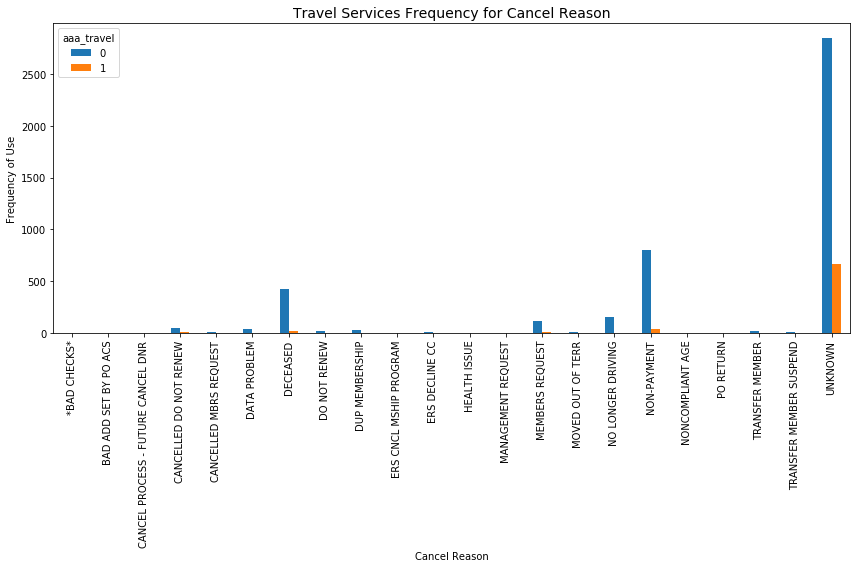

In [31]:
# graph Cancel Reason
pd.crosstab(df_household.cancel_reason,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Cancel Reason')
plt.xlabel('Cancel Reason')
plt.ylabel('Frequency of Use')
plt.savefig('cancel_reason_use_'+var_to_predict_save)

# Observation
This Cancel Reason feature does not seems to be important to weather member choose or not travel. Even though, for instance those member that their suscription was cancelled or CC rejected, there might be an oportunity to get a CC if credit is available to them.  Will consolidate the reason in three main groups:
* a) PAYMENT ISSUES
* b) MEMBER ISSUES
* c) DATA/AAA ISSUES

UKNOWN will be replaced by 'NOT CANCELLED'  It is the largest group and a potential to customer.

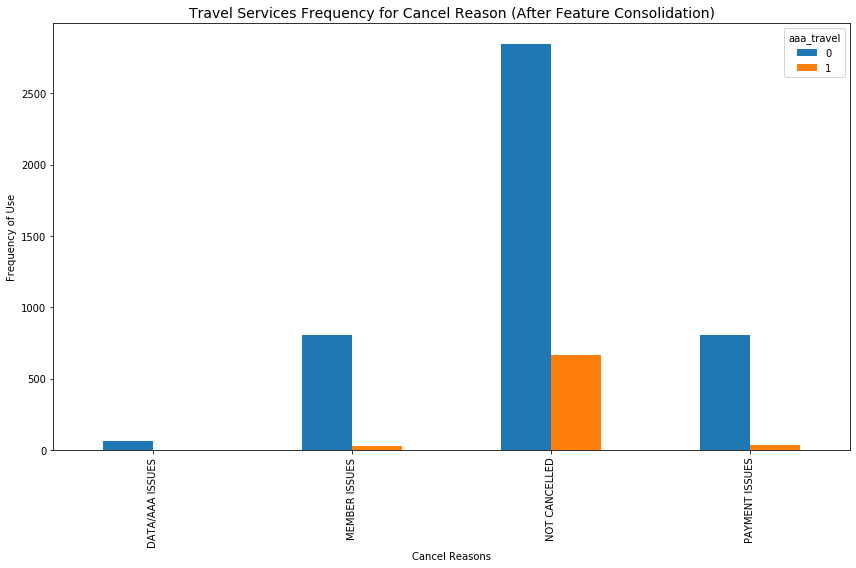

In [32]:
group1 = ['NON-PAYMENT', 'ERS DECLINE CC', 'BAD ADD SET BY PO ACS', '*BAD CHECKS*', 
         ]
group2 = ['DECEASED', 'NO LONGER DRIVING', 'MEMBERS REQUEST', 'CANCELLED DO NOT RENEW', 'TRANSFER MEMBER',
          'DO NOT RENEW', 'MOVED OUT OF TERR', 'TRANSFER MEMBER SUSPEND', 'CANCELLED MBRS REQUEST',
          'HEALTH ISSUE', 'NONCOMPLIANT AGE', 'PO RETURN'
         ]
group3 = ['DATA PROBLEM','DUP MEMBERSHIP','ERS CNCL MSHIP PROGRAM','MANAGEMENT REQUEST', 'CANCEL PROCESS - FUTURE CANCEL DNR']

for i in group1:
    df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'PAYMENT ISSUES', df_household['cancel_reason'])
for i in group2:
    df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'MEMBER ISSUES', df_household['cancel_reason'])
for i in group3:
    df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'DATA/AAA ISSUES', df_household['cancel_reason'])

df_household['cancel_reason']=np.where(df_household['cancel_reason']== 'UNKNOWN', 'NOT CANCELLED', df_household['cancel_reason'])

pd.crosstab(df_household.cancel_reason,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Cancel Reason (After Feature Consolidation)')
plt.xlabel('Cancel Reasons')
plt.ylabel('Frequency of Use')
plt.savefig('cancel_reason_use_feat_'+var_to_predict_save)

In [33]:
# mosaic_household
df_household.mosaic_household.value_counts()

UNKNOWN                       1524
AGING IN PLACE                 693
SILVER SOPHISTICATES           332
REAPING REWARDS                246
NO PLACE LIKE HOME             234
ROOTED FLOWER POWER            219
TOWN ELDERS                    199
SENIOR DISCOUNTS               176
AGING OF AQUARIUS              160
SETTLED IN SUBURBIA            140
FULL POCKETS  EMPTY NESTS      115
DIGITAL DEPENDENTS             105
BOHEMIAN GROOVE                 70
FAST TRACK COUPLES              70
BLUE COLLAR COMFORT             70
PLATINUM PROSPERITY             65
FAMILY FUN-TASTIC               61
AMERICAN ROYALTY                58
PROGRESSIVE POTPOURRI           50
BOOMERS AND BOOMERANGS          45
STATUS SEEKING SINGLES          44
GOLF CARTS AND GOURMETS         42
BIRKENSTOCKS AND BEEMERS        41
UNSPOILED SPLENDOR              40
PICTURE PERFECT FAMILIES        39
MID-SCALE MEDLEY                38
COUPLES WITH CLOUT              28
SETTLED AND SENSIBLE            27
TOUGH TIMES         

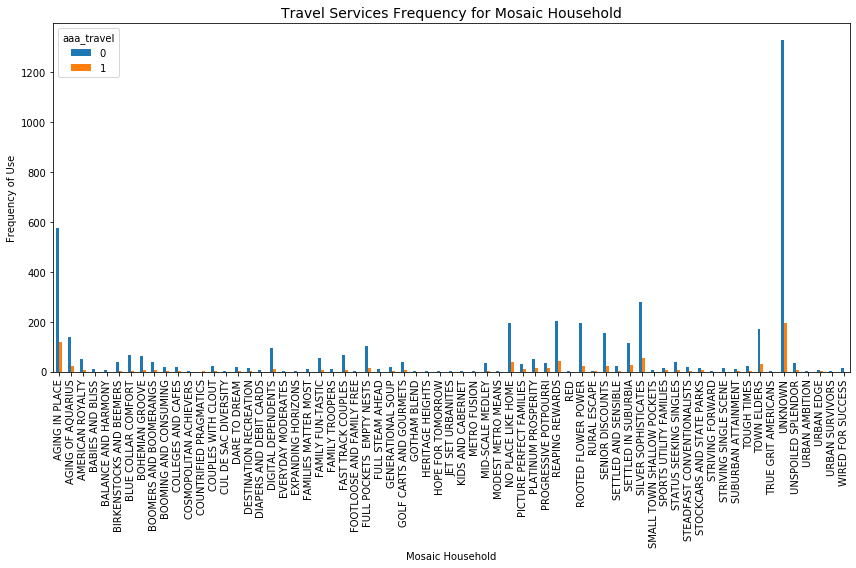

In [34]:
# graph Mosaic household
pd.crosstab(df_household.mosaic_household,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Mosaic Household')
plt.xlabel('Mosaic Household')
plt.ylabel('Frequency of Use')
plt.savefig('mosaic_household_use_'+var_to_predict_save)

In [35]:
# mosaic_household
df_household.mosaic_global_household.value_counts()

UNKNOWN                      1524
COMFORTABLE RETIREMENT       1180
BOURGEOIS PROSPERITY          844
ROUTINE SERVICE WORKERS       543
HARD WORKING BLUE COLLAR      266
CAREER AND FAMILY             244
POST INDUSTRIAL SURVIVORS     228
LOW INCOME ELDERS             226
METROPOLITAN STRUGGLERS       139
SOPHISTICATED SINGLES          64
RURAL INHERITANCE               3
Name: mosaic_global_household, dtype: int64

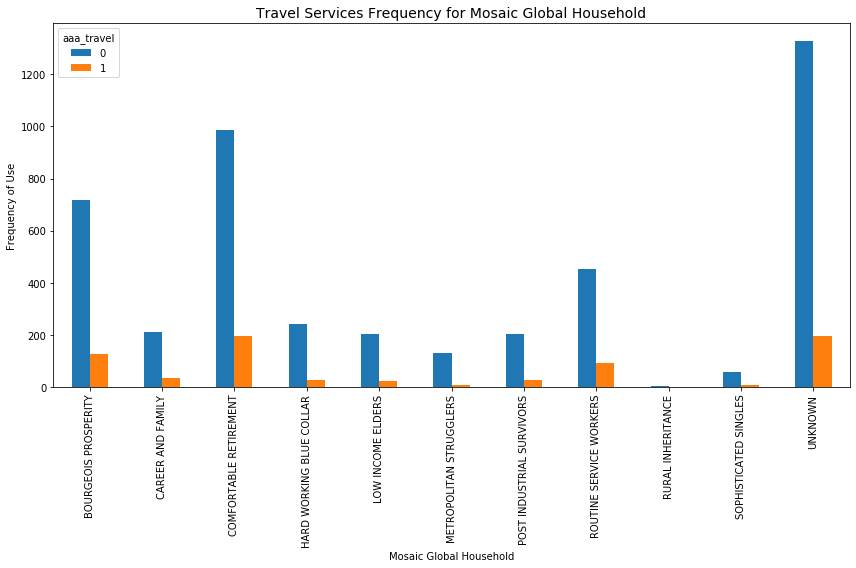

In [36]:
# graph Mosaic Global household
pd.crosstab(df_household.mosaic_global_household,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Mosaic Global Household')
plt.xlabel('Mosaic Global Household')
plt.ylabel('Frequency of Use')
plt.savefig('mosaic_global_household_use_'+var_to_predict_save)

# Observation
Reviewing the graph above, these three groups can be consolidated in:
* a) METROPOLITAN STRUGGLERS into ROUTINE SERVICE WORKERS
* b) SOPHISTICATED SINGLES into BOURGEOIS PROSPERITY
* c) RURAL INHERITANCE into CAREER AND FAMILY
* d) POST INDUSTRIAL SURVIVORS into ROUTINE SERVICE WORKERS

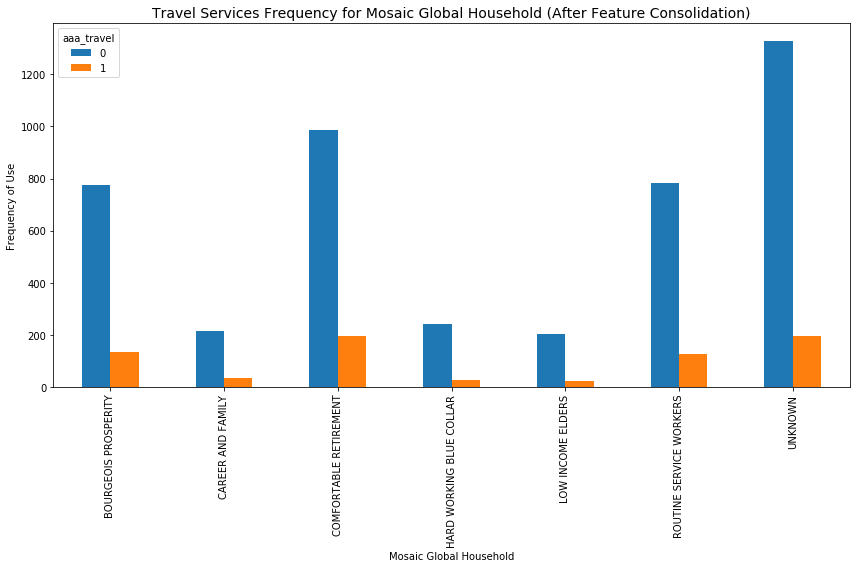

In [37]:
df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'METROPOLITAN STRUGGLERS', 
                                                 'ROUTINE SERVICE WORKERS', df_household['mosaic_global_household']
                                                )

df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'SOPHISTICATED SINGLES', 
                                                 'BOURGEOIS PROSPERITY', df_household['mosaic_global_household']
                                                )

df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'RURAL INHERITANCE', 
                                                 'CAREER AND FAMILY', df_household['mosaic_global_household']
                                                )
df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'POST INDUSTRIAL SURVIVORS', 
                                                 'ROUTINE SERVICE WORKERS', df_household['mosaic_global_household']
                                                )

pd.crosstab(df_household.mosaic_global_household,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))

plt.title(var_to_predict_title+' Frequency for Mosaic Global Household (After Feature Consolidation)')
plt.xlabel('Mosaic Global Household')
plt.ylabel('Frequency of Use')
plt.savefig('mosaic_global_household_use_feat_'+var_to_predict_save)

In [38]:
# kcl_b_ind_mosaicsgrouping
df_household.kcl_b_ind_mosaicsgrouping.value_counts()

UNKNOWN                     1524
AUTUMN YEARS                 724
GOLDEN YEAR GUARDIANS        625
BOOMING WITH CONFIDENCE      579
THRIVING BOOMERS             389
BLUE SKY BOOMERS             240
POWER ELITE                  195
SURBURBAN STYLE              175
SINGLES AND STARTERS         159
FAMILY UNION                 117
MIDDLE CLASS MELTING POT     108
FLOURISHING FAMILIES          95
SIGNIFICANT SINGLES           89
PROMISING FAMILIES            81
YOUNG CITY SOLOS              50
CULTURAL CONNECTIONS          44
ECONOMIC CHALLENGES           34
ASPIRATIONAL FUSION           23
FAMILIES IN MOTION             8
PASTORAL PRIDE                 2
Name: kcl_b_ind_mosaicsgrouping, dtype: int64

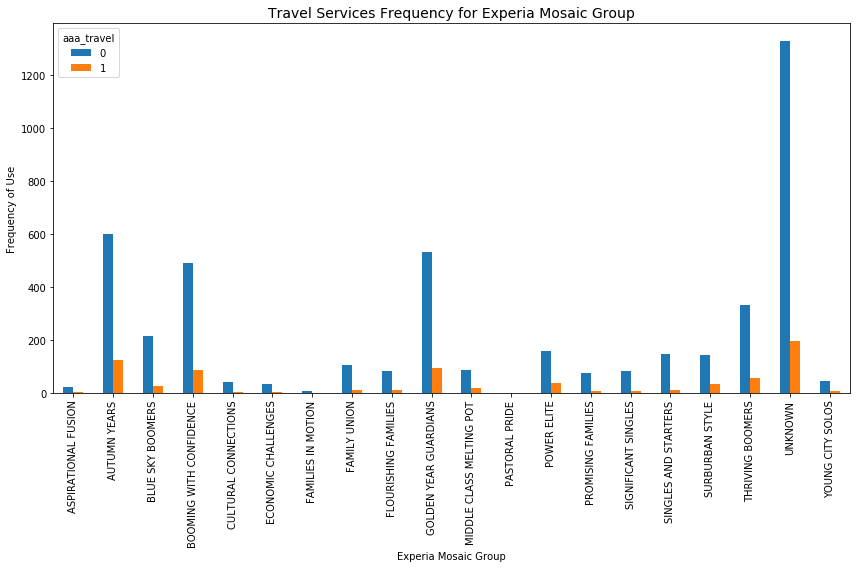

In [39]:
# graph kcl_b_ind_mosaicsgrouping
pd.crosstab(df_household.kcl_b_ind_mosaicsgrouping,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Experia Mosaic Group')
plt.xlabel('Experia Mosaic Group')
plt.ylabel('Frequency of Use')
plt.savefig('kcl_b_ind_mosaicsgrouping_use_'+var_to_predict_save)

# Observation
Reviewing the graph above, there are five dominant group here
* a) GOLDEN YEARS - retired people
* b) BOOMING - well established families
* c) POWER ELITE - powerufull wealth people
* d) FAMILY - middle class families
* e) Singles - singles or single moms.

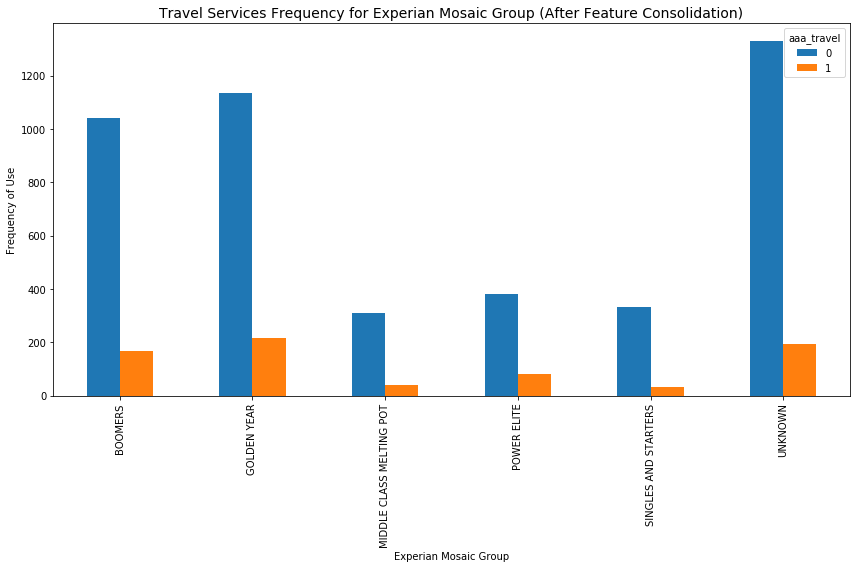

In [40]:
group1 = ['AUTUMN YEARS', 'GOLDEN YEAR GUARDIANS']
group2 = ['BOOMING WITH CONFIDENCE', 'THRIVING BOOMERS', 'BLUE SKY BOOMERS']
group3 = ['POWER ELITE', 'SURBURBAN STYLE', 'FLOURISHING FAMILIES']
group4 = ['FAMILY UNION', 'MIDDLE CLASS MELTING POT', 'PROMISING FAMILIES', 'ECONOMIC CHALLENGES', 'FAMILIES IN MOTION',
          'PASTORAL PRIDE']
group5 = ['SINGLES AND STARTERS', 'SIGNIFICANT SINGLES', 'YOUNG CITY SOLOS', 'CULTURAL CONNECTIONS',
         'ASPIRATIONAL FUSION']
for i in group1:
    df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'GOLDEN YEAR', df_household['kcl_b_ind_mosaicsgrouping'])
for i in group2:
    df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'BOOMERS', df_household['kcl_b_ind_mosaicsgrouping'])
for i in group3:
    df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'POWER ELITE', df_household['kcl_b_ind_mosaicsgrouping'])
for i in group4:
    df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'MIDDLE CLASS MELTING POT', df_household['kcl_b_ind_mosaicsgrouping'])
for i in group5:
    df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'SINGLES AND STARTERS', df_household['kcl_b_ind_mosaicsgrouping'])

pd.crosstab(df_household.kcl_b_ind_mosaicsgrouping,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))

plt.title(var_to_predict_title+' Frequency for Experian Mosaic Group (After Feature Consolidation)')
plt.xlabel('Experian Mosaic Group')
plt.ylabel('Frequency of Use')
plt.savefig('kcl_b_ind_mosaicsgrouping_use_feat_'+var_to_predict_save)

In [41]:
# Vehicle Manufacturer
df_household.sc_vehicle_manufacturer_name.value_counts()

UNKNOWN            2262
TOYOTA              618
FORD                334
HONDA               322
CHEVROLET           186
HYUNDAI             161
NISSAN              147
BUICK               127
SUBARU              116
JEEP                 82
DODGE                75
LEXUS                75
MERCURY              73
CHRYSLER             68
VOLKSWAGEN           68
VOLVO                61
MERCEDES-BENZ        53
KIA                  45
GMC                  39
MAZDA                38
CADILLAC             38
LINCOLN              38
ACURA                31
SATURN               29
PONTIAC              26
OLDSMOBILE           22
SAAB                 20
BMW                  20
AUDI                 16
INFINITI             14
SCION                 9
LAND ROVER            8
MITSUBISHI            7
RAM                   5
SUZUKI                4
PLYMOUTH              4
MINI                  4
JAGUAR                3
PORSCHE               3
BICYCLE               2
GEO                   2
CRYSLER         

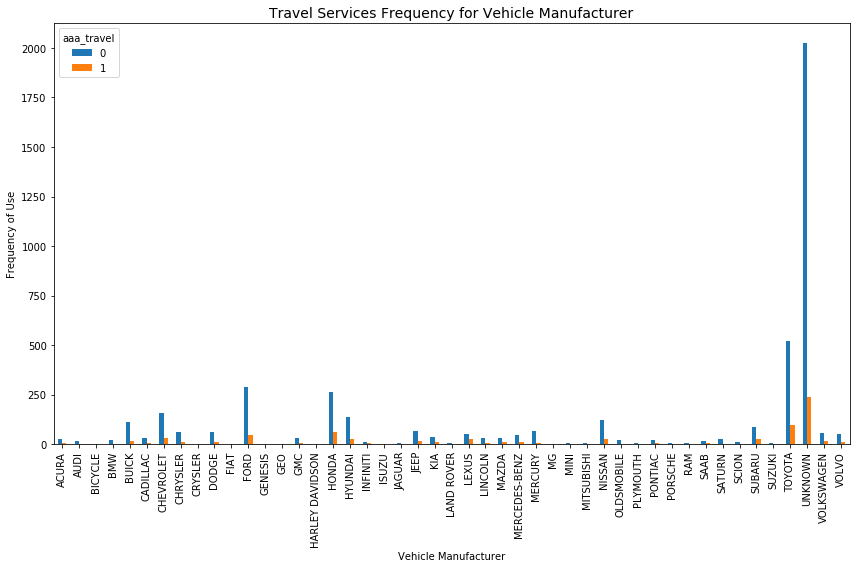

In [42]:
# graph Vehicle manufacturer
pd.crosstab(df_household.sc_vehicle_manufacturer_name,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Vehicle Manufacturer')
plt.xlabel('Vehicle Manufacturer')
plt.ylabel('Frequency of Use')
plt.savefig('vehicle_manufacturer_use_'+var_to_predict_save)

# Observation
Reviewing the graph above, there are four main group of car.  

* a) Standard for small families, and young professional, 
* b) Middle End - Middle class families and middle management
* c) High End - Success and upper management or people above 55 years no debts and no kids at school

Going to group the vehicle manufacturer in those three groups.

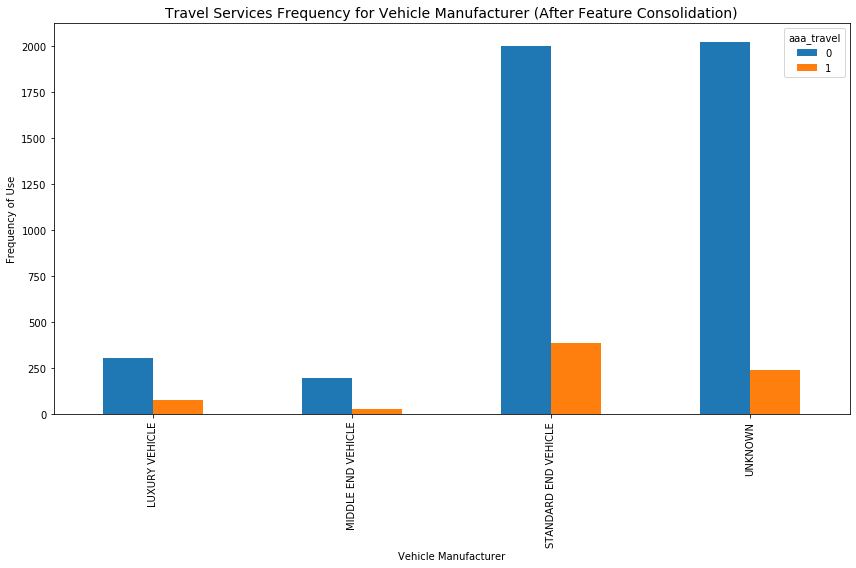

In [43]:
group1 = [ 'TOYOTA', 'FORD', 'HONDA', 'CHEVROLET', 'HYUNDAI', 'NISSAN', 'BUICK', 'SUBARU', 'SUZUKI',
         'DODGE', 'CHRYSLER', 'VOLKSWAGEN','KIA', 'MAZDA', 'SATURN', 'PONTIAC', 'SCION', 'MITSUBISHI',
          'GEO', 'CRYSLER', 'MG', 'FIAT', 'BICYCLE', 'ISUZU']
group2 = ['JEEP', 'MERCURY','GMC', 'OLSMOBILE', 'RAM', 'PLYMOUTH', 'GENESIS', 'OLDSMOBILE']
          
group3 = ['LEXUS', 'VOLVO', 'MERCEDES-BENZ', 'CADILLAC','LINCOLN', 'ACURA', 'BMW', 'SAAB', 'AUDI', 'INFINITI',
          'LAND ROVER', 'MINI', 'JAGUAR', 'PORSCHE', 'HARLEY DAVIDSON']

for i in group1:
    df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'STANDARD END VEHICLE', df_household['sc_vehicle_manufacturer_name'])
for i in group2:
    df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'MIDDLE END VEHICLE', df_household['sc_vehicle_manufacturer_name'])
for i in group3:
    df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'LUXURY VEHICLE', df_household['sc_vehicle_manufacturer_name'])


pd.crosstab(df_household.sc_vehicle_manufacturer_name,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Vehicle Manufacturer (After Feature Consolidation)')
plt.xlabel('Vehicle Manufacturer')
plt.ylabel('Frequency of Use')
plt.savefig('vehicle_manufacturer_use_feat_'+var_to_predict_save)

In [44]:
# Occupation Code
df_household.occupation_code.value_counts()

UNKNOWN                            4195
RETIRED                             256
PROFESSIONAL/TECHNICAL              141
UPPER MANAGEMENT/EXECUTIVE           82
NURSE                                79
SKILLEDTRADE/MACHINE/LABORER         70
CLERICAL/OFFICE                      69
TEACHER/EDUCATOR                     68
MIDDLE MANAGEMENT                    65
SALES/MARKETING                      33
BEAUTY                               22
REAL ESTATE                          21
SELF EMPLOYED                        17
ATTORNEYS                            14
EXECUTIVE/ADMINISTRATOR              13
HEALTH SERVICES                      11
PHARMACIST                            9
COUNSELORS                            8
ACCOUNTANTS/CPA                       7
RETAIL SALES                          7
DENTIST/DENTAL HYGIENIST              7
COMPUTER PROFESSIONAL                 6
ENGINEERS                             6
PROFESSIONAL DRIVER                   6
CIVIL SERVANT                         6


In [45]:
df_household.occupation_group.value_counts()

UNKNOWN                             3043
RETIRED - INFERRED                   773
PROFESSIONAL - KNOWN                 357
RETIRED - KNOWN                      256
MANAGEMENT - KNOWN                   177
BLUE COLLAR - KNOWN                   77
OTHER - INFERRED                      71
MANAGEMENT - INFERRED                 70
OFFICE ADMINISTRATION - KNOWN         69
BLUE COLLAR - INFERRED                67
SALES - KNOWN                         61
OFFICE ADMINISTRATION - INFERRED      60
PROFESSIONAL - INFERRED               56
OTHER - KNOWN                         51
TECHNICAL - INFERRED                  34
SALES - INFERRED                      21
TECHNICAL - KNOWN                     18
Name: occupation_group, dtype: int64

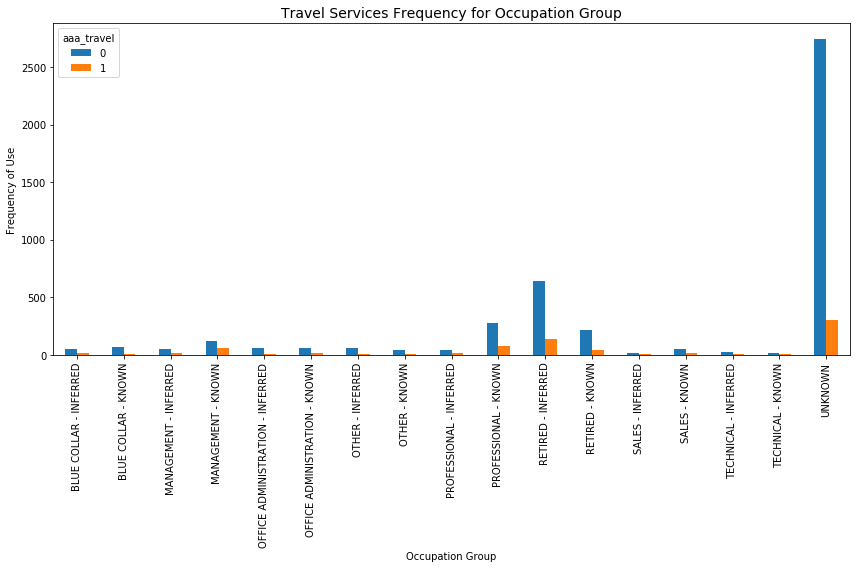

In [46]:
# graph ocuppation group
pd.crosstab(df_household.occupation_group,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Occupation Group')
plt.xlabel('Occupation Group')
plt.ylabel('Frequency of Use')
plt.savefig('occupation_group_use_'+var_to_predict_save)

# Observation
Reviewing the graph above, there are 4 prodominat group
* a) PROFESSIONAL
* b) MANAGEMENT
* c) RETIRED
* d) OTHERS

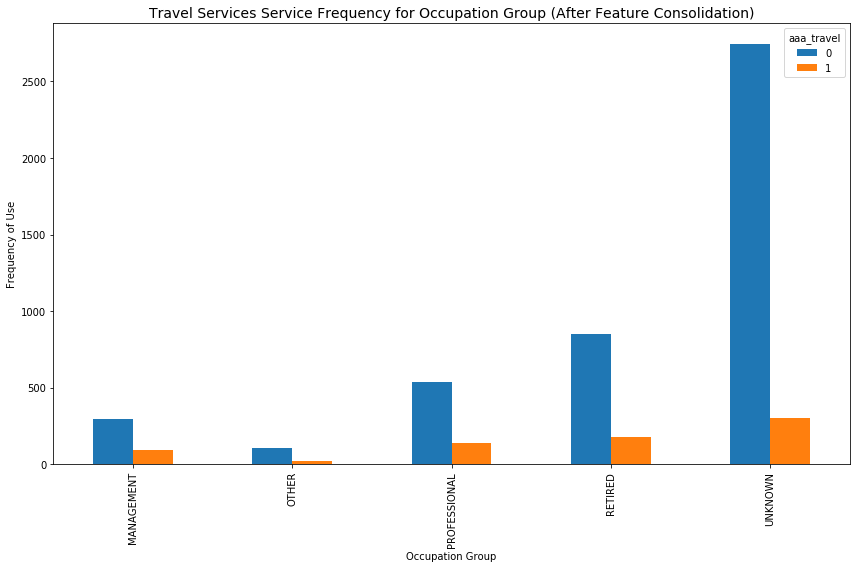

In [47]:
group1 = ['PROFESSIONAL - KNOWN', 'PROFESSIONAL - INFERRED', 'OFFICE ADMINISTRATION - KNOWN',
         'SALES - KNOWN', 'OFFICE ADMINISTRATION - INFERRED', 'TECHNICAL - INFERRED',
         'SALES - INFERRED', 'TECHNICAL - KNOWN']
group2 = ['MANAGEMENT - KNOWN', 'BLUE COLLAR - KNOWN', 'MANAGEMENT - INFERRED', 'BLUE COLLAR - INFERRED']
group3 = ['RETIRED - INFERRED', 'RETIRED - KNOWN']
group4 = ['OTHER - INFERRED', 'OTHER - KNOWN']

for i in group1:
    df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'PROFESSIONAL', df_household['occupation_group'])
for i in group2:
    df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'MANAGEMENT', df_household['occupation_group'])
for i in group3:
    df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'RETIRED', df_household['occupation_group'])
for i in group4:
    df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'OTHER', df_household['occupation_group'])


pd.crosstab(df_household.occupation_group,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Service Frequency for Occupation Group (After Feature Consolidation)')
plt.xlabel('Occupation Group')
plt.ylabel('Frequency of Use')
plt.savefig('occupation_group_use_feat_'+var_to_predict_save)

In [48]:
# graph occupant type
df_household.occupant_type.value_counts()

UNKNOWN      5062
HOMEOWNER     140
RENTER         59
Name: occupant_type, dtype: int64

In [49]:
# graph member status
df_household.member_status.value_counts()

ACTIVE       3194
CANCELLED    1746
PENDING       321
Name: member_status, dtype: int64

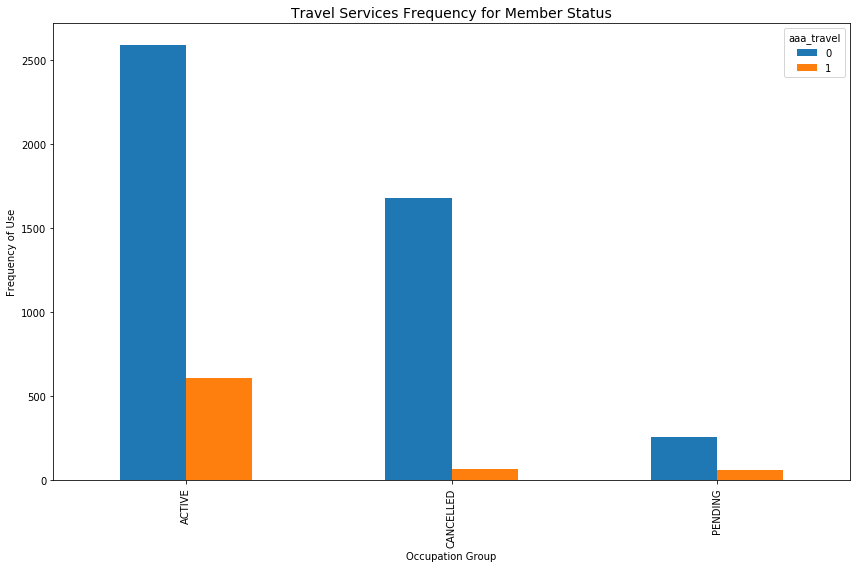

In [50]:
# graph member status group
pd.crosstab(df_household.member_status,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Member Status')
plt.xlabel('Occupation Group')
plt.ylabel('Frequency of Use')
plt.savefig('member_status_use_'+var_to_predict_save)

In [51]:
# graph deposit
df_household.aaa_deposit.value_counts()

0    5233
1      28
Name: aaa_deposit, dtype: int64

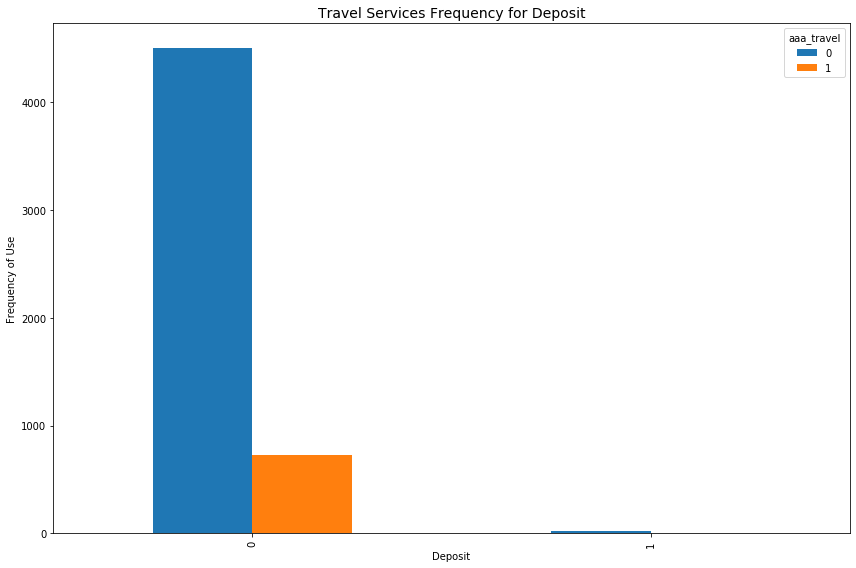

In [52]:
# graph Deposit
pd.crosstab(df_household.aaa_deposit,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Deposit')
plt.xlabel('Deposit')
plt.ylabel('Frequency of Use')
plt.savefig('deposit_use_'+var_to_predict_save)

In [53]:
# graph Financial service
df_household.aaa_financial_service.value_counts()

0    4893
1     368
Name: aaa_financial_service, dtype: int64

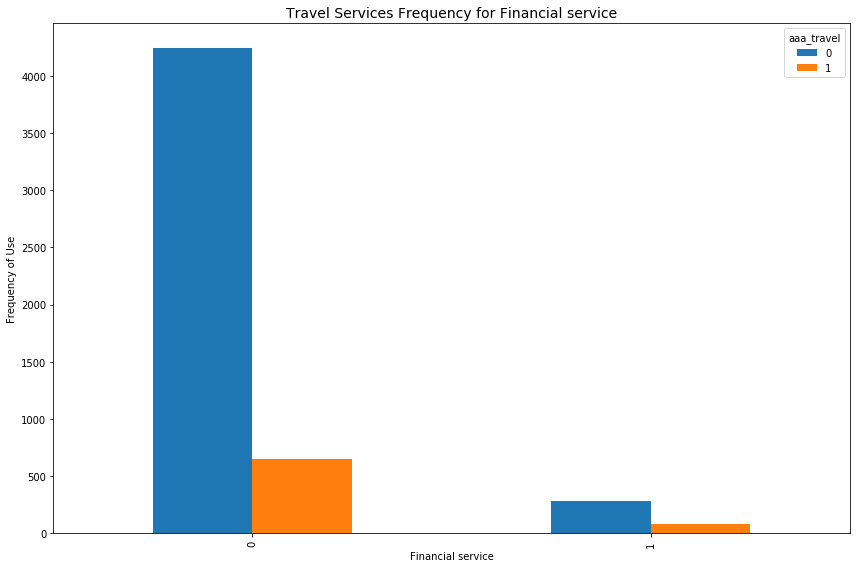

In [54]:
# graph Financial service
pd.crosstab(df_household.aaa_financial_service,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Financial service')
plt.xlabel('Financial service')
plt.ylabel('Frequency of Use')
plt.savefig('financial_service_use_'+var_to_predict_save)

In [55]:
# graph home_equity
df_household.aaa_home_equity.value_counts()

0    5255
1       6
Name: aaa_home_equity, dtype: int64

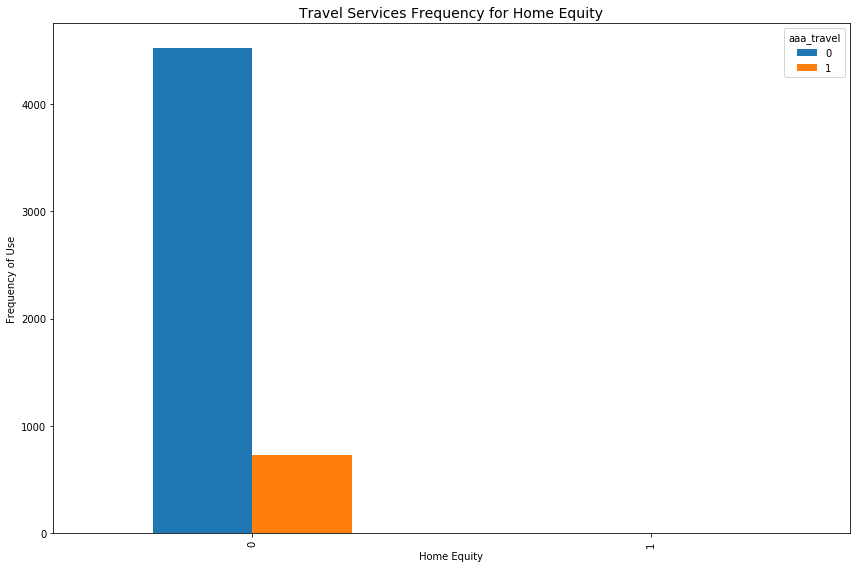

In [56]:
# graph home_equity
pd.crosstab(df_household.aaa_home_equity,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Home Equity')
plt.xlabel('Home Equity')
plt.ylabel('Frequency of Use')
plt.savefig('home_equity_use_'+var_to_predict_save)

In [57]:
# graph mortgage
df_household.aaa_mortgage.value_counts()

0    4893
1     368
Name: aaa_mortgage, dtype: int64

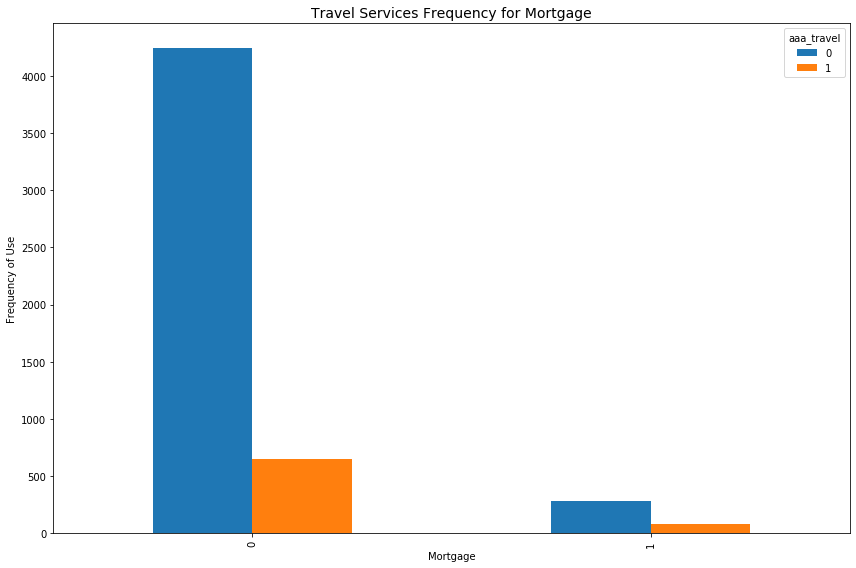

In [58]:
# graph Mortgage group
pd.crosstab(df_household.aaa_mortgage,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Mortgage')
plt.xlabel('Mortgage')
plt.ylabel('Frequency of Use')
plt.savefig('mortgage_use_'+var_to_predict_save)

In [59]:
# graph credit card
df_household.aaa_credit_card.value_counts()

0    4681
1     580
Name: aaa_credit_card, dtype: int64

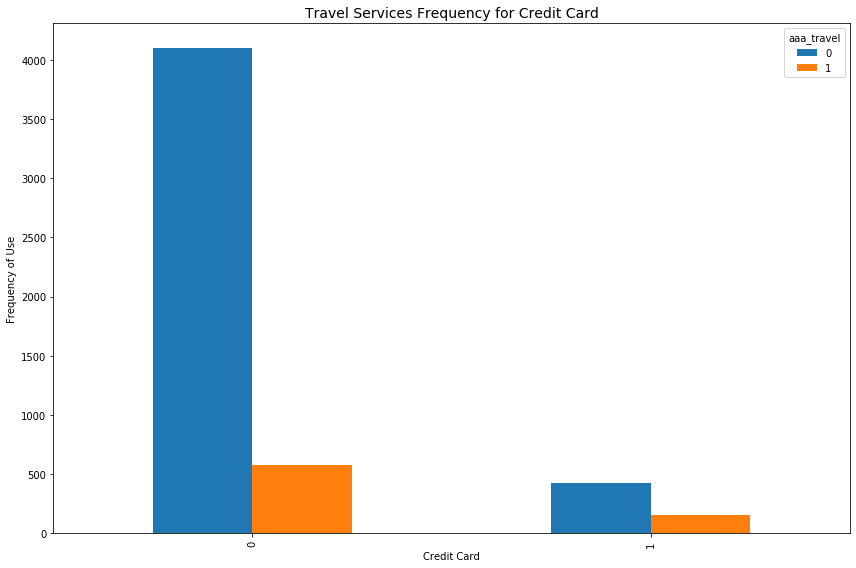

In [60]:
# graph Credit card group
pd.crosstab(df_household.aaa_credit_card,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Credit Card')
plt.xlabel('Credit Card')
plt.ylabel('Frequency of Use')
plt.savefig('credit_card_use_'+var_to_predict_save)

In [61]:
# graph auto insurance
df_household.aaa_auto_insurance.value_counts()

0    3816
1    1445
Name: aaa_auto_insurance, dtype: int64

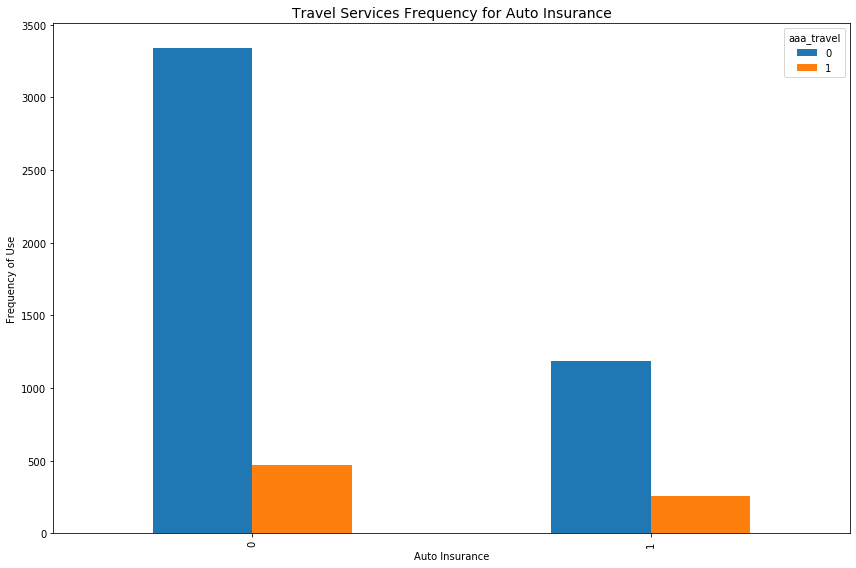

In [62]:
# graph auto insurance group
pd.crosstab(df_household.aaa_auto_insurance,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Auto Insurance')
plt.xlabel('Auto Insurance')
plt.ylabel('Frequency of Use')
plt.savefig('auto_insurance_use_'+var_to_predict_save)

# Model to predict Travel Service Usage by household key

Previous Columns Used
* cols_house_dummmies = ['income', 'tenure', 'credit_ranges','education', 'generation', 'cancel_reason',
                       'race', 'home_owner', 'dwelling_type', 'mosaic_global_household',
                       'plus_indicator_description', 'gender', 'mosaic_household',
                       'kcl_b_ind_mosaicsgrouping', 'sc_vehicle_manufacturer_name'
                       occupation_code, occupation_group, occupant_type, vehicle, sc_vehicle_model_name

* feature_cols = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                    'total_calls', 'total_member_cost', 'total_cost', 'mean_total_member_cost', 'mean_total_cost'
* feature_cols = ['no_members', 'total_calls', 'mean_total_member_cost', 'mean_total_cost',
               'mean_basic_cost', 'mean_plus_cost', 'mean_premier_cost']

# Final Observation (Need update)

Based on the previous anlysis, these are the most important feature:
* income
* tenure
* credit_ranges
* education
* generation
* race
* home_owner
* cancel_reason
* mosaic_global_household
* plus_indicator_description
* Gender
* kcl_b_ind_mosaicsgrouping
* sc_vehicle_manufacturer_name
* occupation_group


In [63]:
# Re initiate all features and data
def reiniciar(df_household):
    df_household = read_data('household_view.csv')
    
    # Regroup Group Income
    group1 = ['UNDER 10K','10-19,999' , '20-29,999', '30-39,999']
    group2 = ['40-49,999', '50-59,999', '60-69,999', '70-79,999', '80-89,999', '90-99,999']
    group3 = ['100-149,999', '150 - 174,999', '175 - 199,999', '200 - 249,999', '250K+' ]
    for i in group1:
        df_household['income']=np.where(df_household['income']== i, 'UNDER 39,999', df_household['income'])
    for i in group2:
        df_household['income']=np.where(df_household['income']== i, '40 - 99,999', df_household['income'])
    for i in group3:
        df_household['income']=np.where(df_household['income']== i, '100k+', df_household['income'])
    
    # Regroup tenures
    group1 = ['BETWEEN 6 & 10 YEARS', 'BETWEEN 11 & 15 YEARS', 
          'BETWEEN 16 & 20 YEARS', 'BETWEEN 1 & 5 YEARS', '< 1 YEAR']
    group2 = ['BETWEEN 31 & 40 YEARS', 'BETWEEN 21 & 30 YEARS']
    group3 = ['+40 YEARS']
    for i in group1:
        df_household['tenure']=np.where(df_household['tenure']== i, 'UNDER 20 YEARS', df_household['tenure'])
    for i in group2:
        df_household['tenure']=np.where(df_household['tenure']== i, 'BETWEEN 21 & 40 YEARS', df_household['tenure'])
    for i in group3:
        df_household['tenure']=np.where(df_household['tenure']== i, '+40 YEARS', df_household['tenure'])
    
    # Regroup credit ranges
    group1 = ['499 & LESS', '500-549','550-599','600-649', '650-699']
    group2 = ['700-749', '750-799']
    group3 = ['800+']
    for i in group1:
        df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, 'BELOW 700', df_household['credit_ranges'])
    for i in group2:
        df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, 'BETWEEN 700 & 799', df_household['credit_ranges'])
    for i in group3:
        df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, '800+', df_household['credit_ranges'])
    
    # Regroup Education
    df_household['education']=np.where(df_household['education'] =='GRADUATED SCHOOL', 
                                   'COMPLETED COLLEGE', df_household['education']
                                  )
    # Regroup Race
    group1 = ['CAUCASION / WHITE - EUROPEAN', 'CAUCASION / WHITE - ENGLISH', 'CAUCASION / WHITE - WHITE NON-AMERICAN',
          'CAUCASION / WHITE - UNKNOWN', 'CAUCASION / WHITE - EASTERN EUROPEAN', 'CAUCASION / WHITE - JEWISH',
          'CAUCASION / WHITE - GREEK', 'CAUCASION / WHITE - DUTCH'
         ]
    group2 = ['HISPANIC - HISPANIC ORIGIN', 'HISPANIC - PORTUGUESE ORIGIN']
    group3 = ['ASIAN - CHINESE', 'ASIAN - UNKNOWN', 'ASIAN - JAPANESE', 'ASIAN - INDIAN', 'ASIAN - ORIENTAL']
    group4 = ['MIDDLE EASTERN - ARAB', 'MIDDLE EASTERN - EGYPTIAN']
    group5 = ['AFRICAN AMERICAN - AFRICAN ORIGIN', 'AMERICAN INDIAN']

    for i in group1:
        df_household['race']=np.where(df_household['race']== i, 'CAUCASION / WHITE', df_household['race'])
    for i in group2:
        df_household['race']=np.where(df_household['race']== i, 'HISPANIC', df_household['race'])
    for i in group3:
        df_household['race']=np.where(df_household['race']== i, 'ASIAN', df_household['race'])
    for i in group4:
        df_household['race']=np.where(df_household['race']== i, 'ARABS', df_household['race'])
    for i in group5:
        df_household['race']=np.where(df_household['race']== i, 'AMERICAN AFRICANS / INDIANS', df_household['race'])

    # Regroup Home Owner
    df_household['home_owner']=np.where(df_household['home_owner']== 'PROBABLE RENTER', 'RENTER', df_household['home_owner'])
    df_household['home_owner']=np.where(df_household['home_owner']== 'PROBABLE HOME OWNER', 'HOME OWNER', df_household['home_owner'])
    
    # Regroup Cancel reason
    group1 = ['NON-PAYMENT', 'ERS DECLINE CC', 'BAD ADD SET BY PO ACS', '*BAD CHECKS*', 
         ]
    group2 = ['DECEASED', 'NO LONGER DRIVING', 'MEMBERS REQUEST', 'CANCELLED DO NOT RENEW', 'TRANSFER MEMBER',
              'DO NOT RENEW', 'MOVED OUT OF TERR', 'TRANSFER MEMBER SUSPEND', 'CANCELLED MBRS REQUEST',
              'HEALTH ISSUE', 'NONCOMPLIANT AGE', 'PO RETURN'
             ]
    group3 = ['DATA PROBLEM','DUP MEMBERSHIP','ERS CNCL MSHIP PROGRAM','MANAGEMENT REQUEST', 'CANCEL PROCESS - FUTURE CANCEL DNR']

    for i in group1:
        df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'PAYMENT ISSUES', df_household['cancel_reason'])
    for i in group2:
        df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'MEMBER ISSUES', df_household['cancel_reason'])
    for i in group3:
        df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'DATA/AAA ISSUES', df_household['cancel_reason'])

    # Regroup Mosaic Global household
    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'METROPOLITAN STRUGGLERS', 
                                                 'ROUTINE SERVICE WORKERS', df_household['mosaic_global_household']
                                                )

    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'SOPHISTICATED SINGLES', 
                                                     'BOURGEOIS PROSPERITY', df_household['mosaic_global_household']
                                                    )

    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'RURAL INHERITANCE', 
                                                     'CAREER AND FAMILY', df_household['mosaic_global_household']
                                                    )
    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'POST INDUSTRIAL SURVIVORS', 
                                                     'ROUTINE SERVICE WORKERS', df_household['mosaic_global_household']
                                                    )
    # Regroup Experian Group
    group1 = ['AUTUMN YEARS', 'GOLDEN YEAR GUARDIANS']
    group2 = ['BOOMING WITH CONFIDENCE', 'THRIVING BOOMERS', 'BLUE SKY BOOMERS']
    group3 = ['POWER ELITE', 'SURBURBAN STYLE', 'FLOURISHING FAMILIES']
    group4 = ['FAMILY UNION', 'MIDDLE CLASS MELTING POT', 'PROMISING FAMILIES', 'ECONOMIC CHALLENGES', 'FAMILIES IN MOTION',
              'PASTORAL PRIDE']
    group5 = ['SINGLES AND STARTERS', 'SIGNIFICANT SINGLES', 'YOUNG CITY SOLOS', 'CULTURAL CONNECTIONS',
             'ASPIRATIONAL FUSION']
    for i in group1:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'GOLDEN YEAR', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group2:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'BOOMERS', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group3:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'POWER ELITE', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group4:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'MIDDLE CLASS MELTING POT', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group5:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'SINGLES AND STARTERS', df_household['kcl_b_ind_mosaicsgrouping'])
    
    # Regroup Vehicle Manufaturer
    group1 = [ 'TOYOTA', 'FORD', 'HONDA', 'CHEVROLET', 'HYUNDAI', 'NISSAN', 'BUICK', 'SUBARU', 'SUZUKI',
         'DODGE', 'CHRYSLER', 'VOLKSWAGEN','KIA', 'MAZDA', 'SATURN', 'PONTIAC', 'SCION', 'MITSUBISHI',
          'GEO', 'CRYSLER', 'MG', 'FIAT', 'BICYCLE', 'ISUZU']
    group2 = ['JEEP', 'MERCURY','GMC', 'OLSMOBILE', 'RAM', 'PLYMOUTH', 'GENESIS', 'OLDSMOBILE']

    group3 = ['LEXUS', 'VOLVO', 'MERCEDES-BENZ', 'CADILLAC','LINCOLN', 'ACURA', 'BMW', 'SAAB', 'AUDI', 'INFINITI',
              'LAND ROVER', 'MINI', 'JAGUAR', 'PORSCHE', 'HARLEY DAVIDSON']

    for i in group1:
        df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'STANDARD END VEHICLE', df_household['sc_vehicle_manufacturer_name'])
    for i in group2:
        df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'MIDDLE END VEHICLE', df_household['sc_vehicle_manufacturer_name'])
    for i in group3:
        df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'LUXURY VEHICLE', df_household['sc_vehicle_manufacturer_name'])

    # Regroup Occupation Group
    group1 = ['PROFESSIONAL - KNOWN', 'PROFESSIONAL - INFERRED', 'OFFICE ADMINISTRATION - KNOWN',
         'SALES - KNOWN', 'OFFICE ADMINISTRATION - INFERRED', 'TECHNICAL - INFERRED',
         'SALES - INFERRED', 'TECHNICAL - KNOWN']
    group2 = ['MANAGEMENT - KNOWN', 'BLUE COLLAR - KNOWN', 'MANAGEMENT - INFERRED', 'BLUE COLLAR - INFERRED']
    group3 = ['RETIRED - INFERRED', 'RETIRED - KNOWN']
    group4 = ['OTHER - INFERRED', 'OTHER - KNOWN']

    for i in group1:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'PROFESSIONAL', df_household['occupation_group'])
    for i in group2:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'MANAGEMENT', df_household['occupation_group'])
    for i in group3:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'RETIRED', df_household['occupation_group'])
    for i in group4:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'OTHER', df_household['occupation_group'])

    # Regroup Total members inside a household
    df_household['no_members'] = ' '
    df_household['no_members']=np.where(df_household['total_members_in_household']== 1, '1 - MEMBER', 
                                        df_household['no_members'])
    df_household['no_members']=np.where(df_household['total_members_in_household']== 2, '2 - MEMBER', 
                                        df_household['no_members'])
    df_household['no_members']=np.where(df_household['total_members_in_household']== 3, '3 - MEMBER', 
                                        df_household['no_members'])
    df_household['no_members']=np.where(df_household['total_members_in_household']== 4, '4 - MEMBER', 
                                        df_household['no_members'])

    df_household['no_members']=np.where(df_household['total_members_in_household']> 4, '5 - MEMBER', 
                                        df_household['no_members'])
    group5 = np.arange(5,20,1)
    for i in group5:
        df_household['no_members']=np.where(df_household['total_members_in_household']== i, '+5 - MEMBER', 
                                        df_household['no_members'])
    
    return df_household

In [64]:
df_household.groupby(by=var_to_predict)['total_cost'].mean()

aaa_travel
0   118.9327
1   164.6699
Name: total_cost, dtype: float64

In [65]:
df_household.groupby(by=var_to_predict)['total_calls'].mean()

aaa_travel
0   7.3557
1   9.4932
Name: total_calls, dtype: float64

In [66]:
df_household.groupby(by=var_to_predict)['total_member_cost'].mean()

aaa_travel
0   389.8191
1   516.6612
Name: total_member_cost, dtype: float64

In [67]:
df_household.groupby(by=var_to_predict)['basic_cost'].mean()

aaa_travel
0   106.9953
1   150.0622
Name: basic_cost, dtype: float64

In [68]:
df_household.groupby(by=var_to_predict)['plus_cost'].mean()

aaa_travel
0    8.5831
1   12.6325
Name: plus_cost, dtype: float64

In [69]:
df_household.groupby(by=var_to_predict)['premier_cost'].mean()

aaa_travel
0   0.0212
1   0.0000
Name: premier_cost, dtype: float64

# Reload data to conduct another experiment

In [70]:
df_household.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5261 entries, 0 to 5260
Data columns (total 78 columns):
membership_id                        int64
household_key                        int64
income                               object
member_status                        object
state_grouped                        object
credit_ranges                        object
cancel_reason                        object
renew_method                         object
plus_indicator_description           object
zip                                  int64
sc_vehicle_manufacturer_name         object
sc_vehicle_model_name                object
race                                 object
home_owner                           object
education                            object
dwelling_type                        object
gender                               object
occupation_code                      object
occupation_group                     object
occupant_type                        object
mosaic_household

In [ ]:
cols_house_dummmies = ['income', 'credit_ranges','education', 'generation', 'aaa_financial_service',
                       'aaa_deposit', 'plus_indicator_description', 'aaa_credit_card', 'home_owner',
                       'kcl_b_ind_mosaicsgrouping', 'occupation_group', 'aaa_travel', 'gender',
                       'no_members', 'sc_vehicle_manufacturer_name', 'dwelling_type', 
                       'aaa_motorcycle_indicator', 'mosaic_global_household', 'tenure'
             ]
feature_cols = ['total_calls', 'mean_total_member_cost', 'mean_total_cost', 'aaa_mean_child',
               'mean_basic_cost', 'mean_plus_cost', 'mean_premier_cost', 
               ]


In [71]:
df_household.groupby(by=['aaa_travel', 'length_of_residence']).count()

membership_id  household_key  income  member_status  state_grouped  credit_ranges  cancel_reason  renew_method  plus_indicator_description   zip  sc_vehicle_manufacturer_name  sc_vehicle_model_name  race  home_owner  education  dwelling_type  gender  occupation_code  occupation_group  occupant_type  mosaic_household  mosaic_global_household  kcl_b_ind_mosaicsgrouping  generation  tenure  aaa_no_tenure  aaa_member_tenure_years  aaa_mean_age  aaa_mortgage  aaa_credit_card  aaa_deposit  aaa_home_equity  aaa_financial_service  aaa_auto_insurance  aaa_id_theft  aaa_motorcycle_indicator  aaa_mean_child  aaa_mean_total_cost  aaa_no_race  aaa_no_home_owner  aaa_no_education  aaa_no_income  aaa_no_dwelling_type  aaa_no_credit_ranges  aaa_no_gender  aaa_no_language  aaa_no_reason_joined  aaa_cancel_reason  aaa_no_mosaic_household  aaa_no_mosaic_global_household  aaa_no_kcl_b_ind_mosaicsgrouping  aaa_no_occupation_code  aaa_no_occupation_group  \
aaa_travel length_of_residence                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
0          0.0000                        1610           1610    1610           1610           1610           1610           1610          1610                        1610  1610                          1610                   1610  1610        1610       1610           1610    1610             1610              1610           1610              1610                     1610                       1610        1610    1610           1610                     1610          1380          1610             1610         1610             1610                   1610                1610          1610                       615              67                 1610           59                 34                26             60                   946                    49            245               58                    30               1392                      948                             948                               948                     102                      248   
           0.1111                           1              1       1              1              1              1              1             1                           1     1                             1                      1     1           1          1              1       1                1                 1              1                 1                        1                          1           1       1              1                        1             1             1                1            1                1                      1                   1             1                         1               1                    1            1                  1                 0              1                     1                     1              0                1                     0                  1                        1                               1                                 1                       0                        0   
           0.1429                           1              1       1              1              1      

In [121]:
# Reload data to conduct another experiment
df_household = reiniciar(df_household)
cols_house_dummmies = ['income', 'credit_ranges','education', 'generation', 'aaa_financial_service',
                       'aaa_deposit', 'plus_indicator_description', 'aaa_credit_card', 'occupation_group',
                       'sc_vehicle_manufacturer_name', 'kcl_b_ind_mosaicsgrouping','dwelling_type',
                       'aaa_motorcycle_indicator', 'mosaic_global_household', 'tenure', 'aaa_auto_insurance',
                       'aaa_id_theft', 'no_members'
             ]
feature_cols = ['total_calls', 'mean_total_member_cost', 'mean_total_cost', 'aaa_mean_child',
               'mean_basic_cost', 'mean_plus_cost', 'mean_premier_cost', 'length_of_residence'
               ]

# Build Dummies Variables
df_dummies = pd.get_dummies(df_household, columns=cols_house_dummmies)
for i in cols_house_dummmies:
    cols = [j for j in df_dummies.columns if j.startswith(i)]
    feature_cols += cols

# construct Dataframe for prediction
feature_cols += var_to_predict
df_prediction = pd.DataFrame(df_dummies, columns=feature_cols)

# Stripping out spaces from ends of names, and replacing internal spaces with "_"
df_prediction.columns = [col.strip().replace(' ', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('&', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('+', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace(',', '').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('(', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace(')', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('<', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('.', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('/', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('-', '_').lower() for col in df_prediction.columns]

# Fix Nans
# Number of child
df_prediction.aaa_mean_child.fillna(value=0, inplace=True)
# Drop records with no age
#df_prediction = df_prediction[~df_prediction.aaa_mean_age.isna()]
# Drop Unknown Columns 
cols_to_drop = [j for j in df_prediction.columns if j.endswith('unknown')]
df_prediction.drop(labels=cols_to_drop,axis=1, inplace=True)

# Save columns name for future use in modelling to split X-Input and y-Output
X_cols = df_prediction.columns[:-1]
y_cols = var_to_predict.copy()

df_prediction.head(5)

,total_calls,mean_total_member_cost,mean_total_cost,aaa_mean_child,mean_basic_cost,mean_plus_cost,mean_premier_cost,length_of_residence,income_100k_,income_40___99999,income_under_39999,credit_ranges_800_,credit_ranges_below_700,credit_ranges_between_700___799,education_completed_college,education_high_school,education_some_college,generation_baby_boomers__1948___1968_,generation_generation_x__1969___1980_,generation_generation_z__1994___2010_,generation_millenials__1981___1993_,generation_post_war____1948_,aaa_financial_service_0,aaa_financial_service_1,aaa_deposit_0,aaa_deposit_1,plus_indicator_description_basic_membership,plus_indicator_description_plus_membership,plus_indicator_description_plus_membership_with_motorcycle_coverage,plus_indicator_description_premier_membership,aaa_credit_card_0,aaa_credit_card_1,occupation_group_management,occupation_group_other,occupation_group_professional,occupation_group_retired,sc_vehicle_manufacturer_name_luxury_vehicle,sc_vehicle_manufacturer_name_middle_end_vehicle,sc_vehicle_manufacturer_name_standard_end_vehicle,kcl_b_ind_mosaicsgrouping_boomers,kcl_b_ind_mosaicsgrouping_golden_year,kcl_b_ind_mosaicsgrouping_middle_class_melting_pot,kcl_b_ind_mosaicsgrouping_power_elite,kcl_b_ind_mosaicsgrouping_singles_and_starters,dwelling_type_large_multi_family_w_o_apt_number,dwelling_type_p_o__box,dwelling_type_sfdu,dwelling_type_small_or_large_multi_family_w_apt_number,aaa_motorcycle_indicator_0_0,aaa_motorcycle_indicator_1_0,mosaic_global_household_bourgeois_prosperity,mosaic_global_household_career_and_family,mosaic_global_household_comfortable_retirement,mosaic_global_household_hard_working_blue_collar,mosaic_global_household_low_income_elders,mosaic_global_household_routine_service_workers,tenure__40_years,tenure_between_21___40_years,tenure_under_20_years,aaa_auto_insurance_0,aaa_auto_insurance_1,aaa_id_theft_0,aaa_id_theft_1,no_members__5___member,no_members_1___member,no_members_2___member,no_members_3___member,no_members_4___member,aaa_travel
0,18.0000,65.0000,33.8333,2.0000,33.8333,0.0000,0.0000,15.0000,0,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0
2,9.0000,58.8500,39.2056,1.0000,39.2056,0.0000,0.0000,8.5556,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0
3,0.0000,0.0000,28.0000,1.0000,28.0000,0.0000,0.0000,15.0000,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0
4,1.0000,9.8083,53.9750,2.0000,53.9750,0.0000,0.0000,15.0000,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1


In [122]:
df_prediction.describe()

,total_calls,mean_total_member_cost,mean_total_cost,aaa_mean_child,mean_basic_cost,mean_plus_cost,mean_premier_cost,length_of_residence,income_100k_,income_40___99999,income_under_39999,credit_ranges_800_,credit_ranges_below_700,credit_ranges_between_700___799,education_completed_college,education_high_school,education_some_college,generation_baby_boomers__1948___1968_,generation_generation_x__1969___1980_,generation_generation_z__1994___2010_,generation_millenials__1981___1993_,generation_post_war____1948_,aaa_financial_service_0,aaa_financial_service_1,aaa_deposit_0,aaa_deposit_1,plus_indicator_description_basic_membership,plus_indicator_description_plus_membership,plus_indicator_description_plus_membership_with_motorcycle_coverage,plus_indicator_description_premier_membership,aaa_credit_card_0,aaa_credit_card_1,occupation_group_management,occupation_group_other,occupation_group_professional,occupation_group_retired,sc_vehicle_manufacturer_name_luxury_vehicle,sc_vehicle_manufacturer_name_middle_end_vehicle,sc_vehicle_manufacturer_name_standard_end_vehicle,kcl_b_ind_mosaicsgrouping_boomers,kcl_b_ind_mosaicsgrouping_golden_year,kcl_b_ind_mosaicsgrouping_middle_class_melting_pot,kcl_b_ind_mosaicsgrouping_power_elite,kcl_b_ind_mosaicsgrouping_singles_and_starters,dwelling_type_large_multi_family_w_o_apt_number,dwelling_type_p_o__box,dwelling_type_sfdu,dwelling_type_small_or_large_multi_family_w_apt_number,aaa_motorcycle_indicator_0_0,aaa_motorcycle_indicator_1_0,mosaic_global_household_bourgeois_prosperity,mosaic_global_household_career_and_family,mosaic_global_household_comfortable_retirement,mosaic_global_household_hard_working_blue_collar,mosaic_global_household_low_income_elders,mosaic_global_household_routine_service_workers,tenure__40_years,tenure_between_21___40_years,tenure_under_20_years,aaa_auto_insurance_0,aaa_auto_insurance_1,aaa_id_theft_0,aaa_id_theft_1,no_members__5___member,no_members_1___member,no_members_2___member,no_members_3___member,no_members_4___member,aaa_travel
count,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000
mean,7.6531,55.1985,22.5209,1.1809,20.8161,1.4547,0.0059,5.9915,0.2053,0.2961,0.1135,0.0905,0.1580,0.3480,0.1023,0.1621,0.1764,0.2199,0.0148,0.0010,0.0091,0.6888,0.9301,0.0699,0.9947,0.0053,0.3247,0.2287,0.0008,0.0169,0.8898,0.1102,0.0743,0.0232,0.1285,0.1956,0.0732,0.0430,0.4539,0.2296,0.2564,0.0665,0.0884,0.0694,0.0038,0.0150,0.5811,0.1106,0.2868,0.3535,0.1726,0.0469,0.2243,0.0506,0.0430,0.1730,0.7170,0.1300,0.1530,0.7253,0.2747,0.9553,0.0447,0.0703,0.2895,0.3625,0.1772,0.1006,0.1391
std,18.9576,88.0371,21.7579,1.1207,18.7942,8.1297,0.3748,5.8162,0.4039,0.4566,0.3172,0.2869,0.3647,0.4764,0.3030,0.3686,0.3812,0.4142,0.1209,0.0308,0.0951,0.4630,0.2551,0.2551,0.0728,0.0728,0.4683,0.4200,0.0276,0.1290,0.3132,0.3132,0.2623,0.1505,0.3347,0.3967,0.2605,0.2028,0.4979,0.4206,0.4367,0.2492,0.2839,0.2541,0.0615,0.1216,0.4934,0.3137,0.4523,0.4781,0.3779,0.2116,0.4172,0.2191,0.2028,0.3783,0.4505,0.3364,0.3600,0.4464,0.4464,0.2066,0.2066,0.2557,0.4536,0.4808,0.3818,0.3008,0.3461
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00

In [123]:
#  Correlation of AAA Mortage Service 
df_prediction.corr()

,total_calls,mean_total_member_cost,mean_total_cost,aaa_mean_child,mean_basic_cost,mean_plus_cost,mean_premier_cost,length_of_residence,income_100k_,income_40___99999,income_under_39999,credit_ranges_800_,credit_ranges_below_700,credit_ranges_between_700___799,education_completed_college,education_high_school,education_some_college,generation_baby_boomers__1948___1968_,generation_generation_x__1969___1980_,generation_generation_z__1994___2010_,generation_millenials__1981___1993_,generation_post_war____1948_,aaa_financial_service_0,aaa_financial_service_1,aaa_deposit_0,aaa_deposit_1,plus_indicator_description_basic_membership,plus_indicator_description_plus_membership,plus_indicator_description_plus_membership_with_motorcycle_coverage,plus_indicator_description_premier_membership,aaa_credit_card_0,aaa_credit_card_1,occupation_group_management,occupation_group_other,occupation_group_professional,occupation_group_retired,sc_vehicle_manufacturer_name_luxury_vehicle,sc_vehicle_manufacturer_name_middle_end_vehicle,sc_vehicle_manufacturer_name_standard_end_vehicle,kcl_b_ind_mosaicsgrouping_boomers,kcl_b_ind_mosaicsgrouping_golden_year,kcl_b_ind_mosaicsgrouping_middle_class_melting_pot,kcl_b_ind_mosaicsgrouping_power_elite,kcl_b_ind_mosaicsgrouping_singles_and_starters,dwelling_type_large_multi_family_w_o_apt_number,dwelling_type_p_o__box,dwelling_type_sfdu,dwelling_type_small_or_large_multi_family_w_apt_number,aaa_motorcycle_indicator_0_0,aaa_motorcycle_indicator_1_0,mosaic_global_household_bourgeois_prosperity,mosaic_global_household_career_and_family,mosaic_global_household_comfortable_retirement,mosaic_global_household_hard_working_blue_collar,mosaic_global_household_low_income_elders,mosaic_global_household_routine_service_workers,tenure__40_years,tenure_between_21___40_years,tenure_under_20_years,aaa_auto_insurance_0,aaa_auto_insurance_1,aaa_id_theft_0,aaa_id_theft_1,no_members__5___member,no_members_1___member,no_members_2___member,no_members_3___member,no_members_4___member,aaa_travel
total_calls,1.0000,0.7964,0.3414,0.1586,0.3486,0.1002,-0.0057,0.0728,0.0266,0.0379,0.0168,0.0189,0.0508,0.0208,0.0205,0.0088,0.0205,0.1059,0.0237,0.0286,0.0454,-0.0682,-0.0987,0.0987,0.0233,-0.0233,0.0968,0.2050,-0.0100,0.0142,-0.0323,0.0323,0.0301,0.0487,0.0307,0.0170,0.1113,0.0920,0.1697,0.0123,-0.0401,0.0339,0.0328,0.0278,-0.0078,0.0344,0.0262,-0.0126,-0.1020,0.3869,-0.0023,0.0303,-0.0394,0.0608,-0.0185,0.0365,-0.0481,0.0261,0.0358,-0.0996,0.0996,-0.0013,0.0013,0.2090,-0.1416,-0.0868,0.0355,0.1296,0.0390
mean_total_member_cost,0.7964,1.0000,0.4995,0.1153,0.4967,0.1739,-0.0079,0.1153,0.0287,0.0512,0.0425,0.0266,0.0598,0.0390,0.0220,0.0158,0.0348,0.0889,0.0354,0.0206,0.0287,-0.0296,-0.0639,0.0639,0.0298,-0.0298,0.1509,0.2519,0.0055,0.0389,-0.0259,0.0259,0.0230,0.0599,0.0193,0.0376,0.1127,0.0987,0.2644,0.0082,-0.0096,0.0171,0.0064,0.0182,-0.0052,0.0272,0.0186,-0.0067,-0.0643,0.4518,0.0050,-0.0068,-0.0091,0.0257,-0.0157,0.0287,-0.0364,0.0274,0.0199,-0.1014,0.1014,-0.0074,0.0074,0.0917,-0.0598,-0.0415,0.0126,0.0626,0.0342
mean_total_cost,0.3414,0.4995,1.0000,0.1920,0.9120,0.4756,0.1204,0.2558,0.1001,0.1091,0.0682,0.0666,0.1043,0.1153,0.0707,0.0706,0.1022,0.1298,-0.0120,0.0165,-0.0044,0.0039,-0.0739,0.0739,0.0095,-0.0095,0.3706,0.3888,0.0409,0.1045,-0.0646,0.0646,0.0492,0.0445,0.0793,0.1161,0.1824,0.1020,0.5689,0.0288,0.0591,0.0024,-0.0035,-0.0199,-0.0056,0.0203,0.0610,0.0024,0.2233,0.5444,0.0293,-0.0259,0.0644,-0.0245,-0.0123,0.0206,0.0276,0.0058,-0.0399,-0.0927,0.0927,-0.0509,0.0509,0.0355,-0.0482,-0.0300,0.0283,0.0545,0.0820
aaa_mean_child,0.1586,0.1153,0.1920,1.0000,0.2060,0.0310,-0.0017,0.4622,0.3076,0.2809,0.0863,0.1309,0.1688,0.3744,0.1619,0.2187,0.2224,0.1944,0.0343,0.0281,0.0205,-0.0924,-0.1477,0.1477,-0.0045,0.0045,0.1289,0.0934,-0.0003,-0.0053,-0.0970,0.0970,0.1338,0.0110,0.1674,0.1433,0.0509,0.0381,0.1561,0.0587,0.0296,0.0511,0.1583,-0.0549,-0.0127,-0.0310,0.2146,-0.0621,0.0692,0.2290,0.0248,0.1020,0.0532,0.0122,-0.0448,0.0916,-0.0021,-0

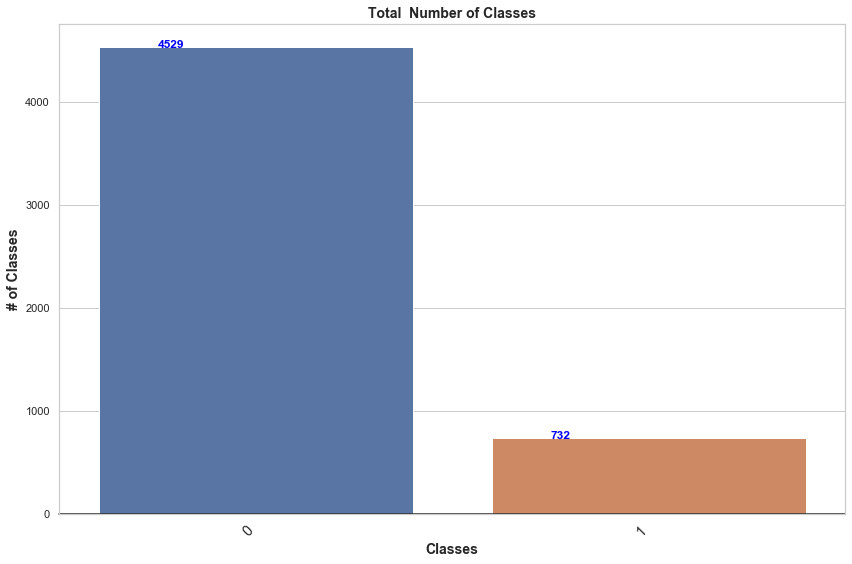

In [124]:
%matplotlib inline
pd.plotting.register_matplotlib_converters()
pd.options.display.float_format = '{:.4f}'.format
rcParams.update({'figure.autolayout': True, 'figure.figsize':(12,8),'axes.titlesize':14})
draw_col_shape(df_prediction,var_to_predict)

Random over-sampling:
1    4529
0    4529
Name: aaa_travel, dtype: int64


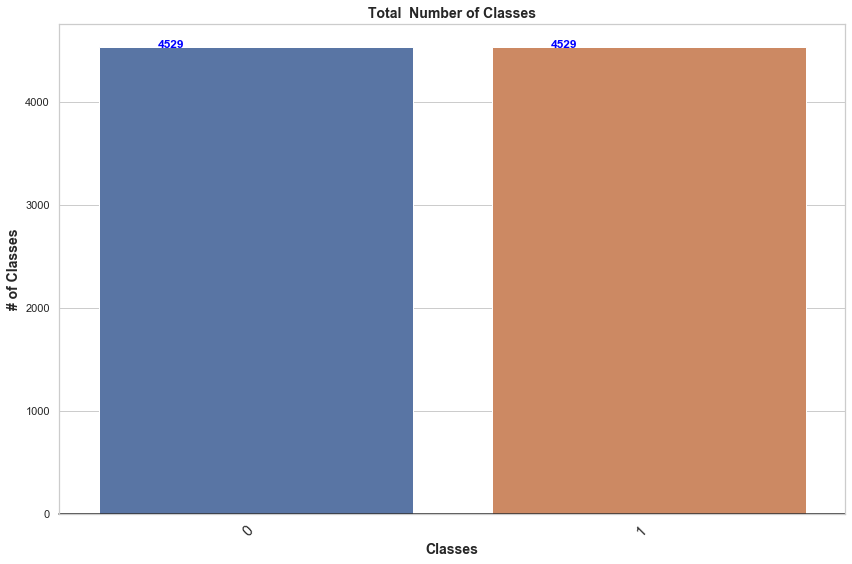

In [125]:
# Balance class Up Sampling
# As there is only 28 members that are using the Deposit Service.
# Will upsample the 11 (yes) to 5233
# Evaluate imbalanced classification model with different metrics

np.random.seed(42)
# Class count
count_class_0, count_class_1 = df_prediction[var_to_predict[0]].value_counts()

# Divide by class
df_class_0 = df_prediction[df_prediction[var_to_predict[0]] == 0]
df_class_1 = df_prediction[df_prediction[var_to_predict[0]] == 1]


df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over[var_to_predict[0]].value_counts())

draw_col_shape(df_test_over,var_to_predict)
plt.show()

Random down-sampling:
1    732
0    732
Name: aaa_travel, dtype: int64


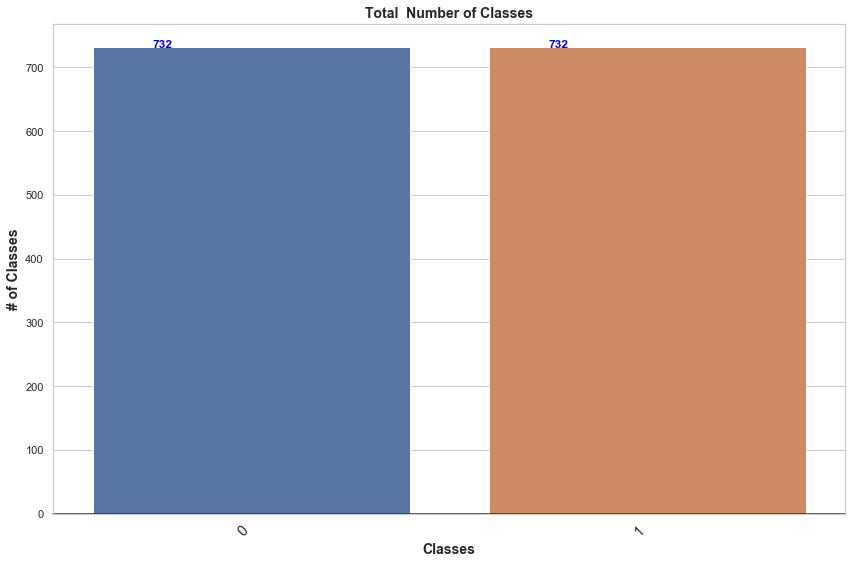

In [126]:
# Down sample Majority Class To Match Minority Class
# Indicies of each class' observations

np.random.seed(42)
count_class_0, count_class_1 = df_prediction[var_to_predict[0]].value_counts()

# Divide by class
df_class_0 = df_prediction[df_prediction[var_to_predict[0]] == 0]
df_class_1 = df_prediction[df_prediction[var_to_predict[0]] == 1]

df_class_0_down = df_class_0.sample(count_class_1, replace=True)
df_test_down = pd.concat([df_class_1, df_class_0_down], axis=0)

print('Random down-sampling:')
print(df_test_down[var_to_predict[0]].value_counts())

draw_col_shape(df_test_down,var_to_predict)
plt.show()

In [127]:
df_test_over.corr()

,total_calls,mean_total_member_cost,mean_total_cost,aaa_mean_child,mean_basic_cost,mean_plus_cost,mean_premier_cost,length_of_residence,income_100k_,income_40___99999,income_under_39999,credit_ranges_800_,credit_ranges_below_700,credit_ranges_between_700___799,education_completed_college,education_high_school,education_some_college,generation_baby_boomers__1948___1968_,generation_generation_x__1969___1980_,generation_generation_z__1994___2010_,generation_millenials__1981___1993_,generation_post_war____1948_,aaa_financial_service_0,aaa_financial_service_1,aaa_deposit_0,aaa_deposit_1,plus_indicator_description_basic_membership,plus_indicator_description_plus_membership,plus_indicator_description_plus_membership_with_motorcycle_coverage,plus_indicator_description_premier_membership,aaa_credit_card_0,aaa_credit_card_1,occupation_group_management,occupation_group_other,occupation_group_professional,occupation_group_retired,sc_vehicle_manufacturer_name_luxury_vehicle,sc_vehicle_manufacturer_name_middle_end_vehicle,sc_vehicle_manufacturer_name_standard_end_vehicle,kcl_b_ind_mosaicsgrouping_boomers,kcl_b_ind_mosaicsgrouping_golden_year,kcl_b_ind_mosaicsgrouping_middle_class_melting_pot,kcl_b_ind_mosaicsgrouping_power_elite,kcl_b_ind_mosaicsgrouping_singles_and_starters,dwelling_type_large_multi_family_w_o_apt_number,dwelling_type_p_o__box,dwelling_type_sfdu,dwelling_type_small_or_large_multi_family_w_apt_number,aaa_motorcycle_indicator_0_0,aaa_motorcycle_indicator_1_0,mosaic_global_household_bourgeois_prosperity,mosaic_global_household_career_and_family,mosaic_global_household_comfortable_retirement,mosaic_global_household_hard_working_blue_collar,mosaic_global_household_low_income_elders,mosaic_global_household_routine_service_workers,tenure__40_years,tenure_between_21___40_years,tenure_under_20_years,aaa_auto_insurance_0,aaa_auto_insurance_1,aaa_id_theft_0,aaa_id_theft_1,no_members__5___member,no_members_1___member,no_members_2___member,no_members_3___member,no_members_4___member,aaa_travel
total_calls,1.0000,0.7930,0.3327,0.1581,0.3336,0.1081,-0.0045,0.0697,0.0143,0.0384,-0.0106,0.0081,0.0377,0.0147,0.0213,-0.0161,-0.0104,0.1100,-0.0067,0.0676,0.0273,-0.0785,-0.0653,0.0653,0.0245,-0.0245,0.0306,0.1997,-0.0131,0.0231,-0.0075,0.0075,-0.0131,0.0234,0.0632,-0.0078,0.0869,0.1354,0.1049,0.0383,-0.0573,0.0114,0.0366,0.0009,-0.0076,0.0195,0.0178,-0.0213,-0.1442,0.3716,-0.0070,0.0492,-0.0566,0.0204,-0.0202,0.0551,-0.0617,0.0653,0.0163,-0.0939,0.0939,0.0299,-0.0299,0.2009,-0.1152,-0.1031,-0.0072,0.1312,0.0569
mean_total_member_cost,0.7930,1.0000,0.4891,0.1088,0.4822,0.1785,-0.0066,0.0875,0.0213,0.0405,0.0064,0.0183,0.0441,0.0204,0.0160,-0.0091,0.0076,0.0933,-0.0039,0.0543,0.0189,-0.0440,-0.0359,0.0359,0.0341,-0.0341,0.0736,0.2437,-0.0086,0.0553,-0.0142,0.0142,-0.0065,0.0289,0.0376,0.0042,0.1029,0.1105,0.1951,0.0152,-0.0236,0.0135,0.0169,-0.0090,-0.0062,0.0310,0.0025,-0.0105,-0.1288,0.4495,-0.0036,0.0085,-0.0181,-0.0028,-0.0212,0.0372,-0.0696,0.0785,0.0137,-0.0809,0.0809,0.0140,-0.0140,0.0728,-0.0396,-0.0441,-0.0219,0.0774,0.0617
mean_total_cost,0.3327,0.4891,1.0000,0.1702,0.9230,0.4632,0.0947,0.2119,0.0973,0.0771,0.0315,0.0600,0.0747,0.0841,0.0695,0.0409,0.0642,0.1105,-0.0520,0.0263,-0.0147,0.0007,-0.0305,0.0305,0.0124,-0.0124,0.3097,0.3713,0.0298,0.1013,-0.0393,0.0393,0.0608,0.0097,0.0562,0.0799,0.1816,0.0714,0.5183,0.0245,0.0487,-0.0092,0.0030,-0.0151,-0.0091,0.0372,0.0384,0.0203,0.1471,0.5427,0.0375,-0.0034,0.0581,-0.0366,-0.0220,-0.0000,0.0169,0.0309,-0.0509,-0.0690,0.0690,-0.0374,0.0374,0.0208,-0.0271,-0.0350,0.0077,0.0573,0.1336
aaa_mean_child,0.1581,0.1088,0.1702,1.0000,0.1798,0.0396,-0.0029,0.4057,0.2740,0.2162,0.0558,0.1161,0.1243,0.3196,0.1271,0.1877,0.1901,0.1722,0.0341,0.0467,0.0168,-0.1000,-0.1310,0.1310,0.0036,-0.0036,0.0913,0.0822,0.0050,-0.0232,-0.0845,0.0845,0.1072,0.0055,0.1394,0.1044,0.0230,0.0537,0.1177,0.0572,-0.0036,0.0621,0.1776,-0.0307,-0.0159,-0.0233,0.2214,-0.0661,0.0476,0.1956,0.0228,0.1497,0.0094,0.0386,-0.0462,0.

In [128]:
df_test_down.describe()

,total_calls,mean_total_member_cost,mean_total_cost,aaa_mean_child,mean_basic_cost,mean_plus_cost,mean_premier_cost,length_of_residence,income_100k_,income_40___99999,income_under_39999,credit_ranges_800_,credit_ranges_below_700,credit_ranges_between_700___799,education_completed_college,education_high_school,education_some_college,generation_baby_boomers__1948___1968_,generation_generation_x__1969___1980_,generation_generation_z__1994___2010_,generation_millenials__1981___1993_,generation_post_war____1948_,aaa_financial_service_0,aaa_financial_service_1,aaa_deposit_0,aaa_deposit_1,plus_indicator_description_basic_membership,plus_indicator_description_plus_membership,plus_indicator_description_plus_membership_with_motorcycle_coverage,plus_indicator_description_premier_membership,aaa_credit_card_0,aaa_credit_card_1,occupation_group_management,occupation_group_other,occupation_group_professional,occupation_group_retired,sc_vehicle_manufacturer_name_luxury_vehicle,sc_vehicle_manufacturer_name_middle_end_vehicle,sc_vehicle_manufacturer_name_standard_end_vehicle,kcl_b_ind_mosaicsgrouping_boomers,kcl_b_ind_mosaicsgrouping_golden_year,kcl_b_ind_mosaicsgrouping_middle_class_melting_pot,kcl_b_ind_mosaicsgrouping_power_elite,kcl_b_ind_mosaicsgrouping_singles_and_starters,dwelling_type_large_multi_family_w_o_apt_number,dwelling_type_p_o__box,dwelling_type_sfdu,dwelling_type_small_or_large_multi_family_w_apt_number,aaa_motorcycle_indicator_0_0,aaa_motorcycle_indicator_1_0,mosaic_global_household_bourgeois_prosperity,mosaic_global_household_career_and_family,mosaic_global_household_comfortable_retirement,mosaic_global_household_hard_working_blue_collar,mosaic_global_household_low_income_elders,mosaic_global_household_routine_service_workers,tenure__40_years,tenure_between_21___40_years,tenure_under_20_years,aaa_auto_insurance_0,aaa_auto_insurance_1,aaa_id_theft_0,aaa_id_theft_1,no_members__5___member,no_members_1___member,no_members_2___member,no_members_3___member,no_members_4___member,aaa_travel
count,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000,1464.0000
mean,9.1223,60.9396,25.4450,1.3502,23.4419,1.6774,0.0369,6.8406,0.2520,0.3361,0.0997,0.1038,0.1605,0.4016,0.1175,0.1673,0.2056,0.2514,0.0102,0.0014,0.0034,0.6844,0.9126,0.0874,0.9945,0.0055,0.3552,0.2596,0.0007,0.0212,0.8545,0.1455,0.1038,0.0239,0.1605,0.2268,0.0949,0.0362,0.5041,0.2384,0.2739,0.0587,0.1004,0.0574,0.0041,0.0184,0.6141,0.0936,0.3122,0.4119,0.1851,0.0512,0.2459,0.0362,0.0355,0.1749,0.7309,0.1332,0.1359,0.6865,0.3135,0.9419,0.0581,0.0902,0.2329,0.3497,0.1906,0.1366,0.5000
std,21.2464,87.4239,21.3625,1.1223,18.1232,8.4650,0.9976,5.6560,0.4343,0.4725,0.2997,0.3051,0.3672,0.4904,0.3221,0.3734,0.4043,0.4339,0.1007,0.0369,0.0584,0.4649,0.2826,0.2826,0.0737,0.0737,0.4787,0.4385,0.0261,0.1440,0.3527,0.3527,0.3051,0.1528,0.3672,0.4189,0.2932,0.1869,0.5002,0.4262,0.4461,0.2352,0.3006,0.2326,0.0639,0.1346,0.4870,0.2913,0.4635,0.4923,0.3885,0.2205,0.4308,0.1869,0.1852,0.3800,0.4437,0.3399,0.3428,0.4641,0.4641,0.2339,0.2339,0.2865,0.4228,0.4770,0.3929,0.3436,0.5002
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00

# Setting Up the Training and Test data for up Sampling the minority class
To use the same split in all models

In [129]:
num_folds = 10
np.random.seed(42)
scoring = 'accuracy'
test_size = 0.5

# Create input and output dataframes
X_df = pd.DataFrame(df_test_over,columns=X_cols)
y_df = pd.DataFrame(df_test_over,columns=y_cols)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df_mm = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=X_cols)

# Split Train and test
trainX, testX, trainy, testy = train_test_split(scaled_df_mm, y_df, test_size=test_size)

# Algorithms Search and Testing

Travel Services - Algorithm Comparison - Over Sampling
LR: Accuracy : 0.659522 - Std. Dev.: (0.015771)
LDA: Accuracy : 0.659080 - Std. Dev.: (0.015311)
KNN: Accuracy : 0.718483 - Std. Dev.: (0.022665)
CART: Accuracy : 0.846542 - Std. Dev.: (0.011936)
NB: Accuracy : 0.525061 - Std. Dev.: (0.028001)
SVM: Accuracy : 0.655770 - Std. Dev.: (0.018189)
SGD: Accuracy : 0.640097 - Std. Dev.: (0.015940)
AB: Accuracy : 0.653782 - Std. Dev.: (0.017940)
GBM: Accuracy : 0.706333 - Std. Dev.: (0.015205)
RF: Accuracy : 0.903292 - Std. Dev.: (0.016052)
ET: Accuracy : 0.918742 - Std. Dev.: (0.010430)
XGB: Accuracy : 0.702798 - Std. Dev.: (0.024328)


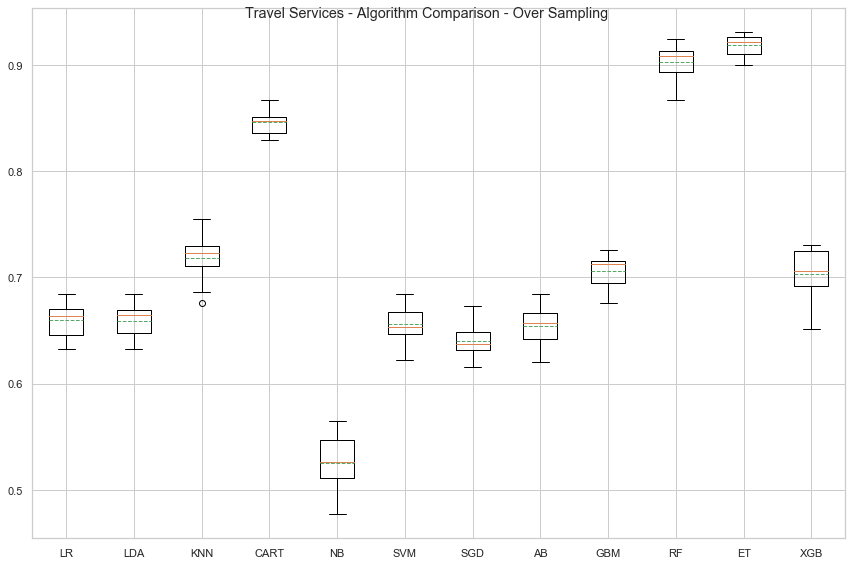

In [130]:
# Algorithms Search
# Spot Check Algorithms

print(var_to_predict_title+' - Algorithm Comparison - Over Sampling')
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('SGD', SGDClassifier(loss='log')))
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, trainX, trainy, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: Accuracy : %f - Std. Dev.: (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Ensembles Methods
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier(n_estimators=10)))
ensembles.append(('ET', ExtraTreesClassifier(n_estimators=10)))
ensembles.append(('XGB', XGBClassifier()))
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, trainX, trainy, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: Accuracy : %f - Std. Dev.: (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Compare Algorithms
fig = plt.figure()
fig.suptitle(var_to_predict_title+' - Algorithm Comparison - Over Sampling')
ax = fig.add_subplot(111)
plt.boxplot(results, meanline=True, showmeans=True)
ax.set_xticklabels(names)
plt.savefig(var_to_predict_save+'_algorithms')
plt.show()

# Setting Up the Training and Test data for Down Sampling the mayority class
To use the same split in all models

In [131]:
num_folds = 10
np.random.seed(42)
scoring = 'accuracy'
test_size = 0.5

# Create input and output dataframes
X_df = pd.DataFrame(df_test_down,columns=X_cols)
y_df = pd.DataFrame(df_test_down,columns=y_cols)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df_mm = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=X_cols)

# Split Train and test
trainX, testX, trainy, testy = train_test_split(scaled_df_mm, y_df, test_size=test_size)

Travel Services - Algorithm Comparison - Down Sampling
LR: Accuracy : 0.596872 - Std. Dev.: (0.067803)
LDA: Accuracy : 0.588652 - Std. Dev.: (0.050934)
KNN: Accuracy : 0.547853 - Std. Dev.: (0.041238)
CART: Accuracy : 0.564421 - Std. Dev.: (0.060561)
NB: Accuracy : 0.501370 - Std. Dev.: (0.048949)
SVM: Accuracy : 0.592743 - Std. Dev.: (0.072571)
SGD: Accuracy : 0.579211 - Std. Dev.: (0.041103)
AB: Accuracy : 0.609182 - Std. Dev.: (0.052861)
GBM: Accuracy : 0.614698 - Std. Dev.: (0.037536)
RF: Accuracy : 0.571140 - Std. Dev.: (0.058576)
ET: Accuracy : 0.590170 - Std. Dev.: (0.067716)
XGB: Accuracy : 0.595483 - Std. Dev.: (0.046489)


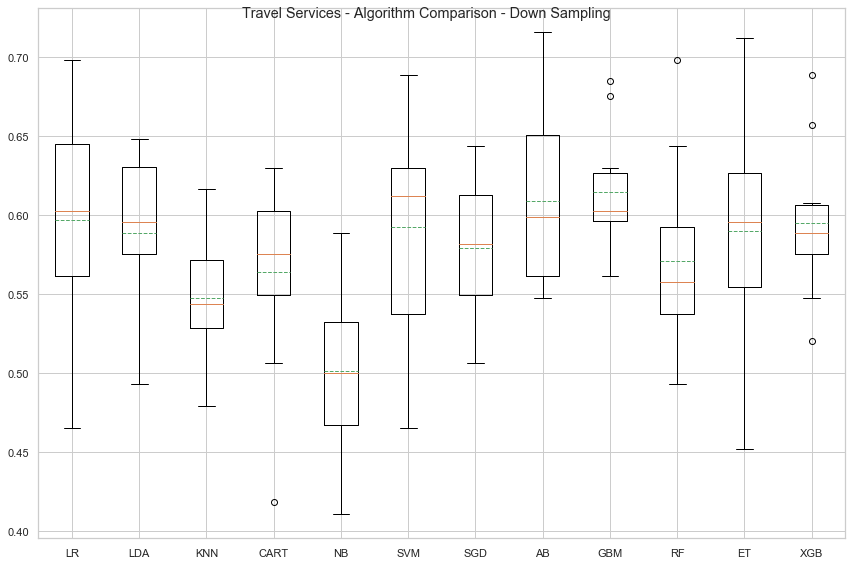

In [132]:
# Spot Check Algorithms
print(var_to_predict_title+' - Algorithm Comparison - Down Sampling')
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('SGD', SGDClassifier(loss='log')))
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, trainX, trainy, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: Accuracy : %f - Std. Dev.: (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Ensembles Methods
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier(n_estimators=10)))
ensembles.append(('ET', ExtraTreesClassifier(n_estimators=10)))
ensembles.append(('XGB', XGBClassifier()))
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, trainX, trainy, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: Accuracy : %f - Std. Dev.: (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Compare Algorithms
fig = plt.figure()
fig.suptitle(var_to_predict_title+' - Algorithm Comparison - Down Sampling')
ax = fig.add_subplot(111)
plt.boxplot(results, meanline=True, showmeans=True)
ax.set_xticklabels(names)
plt.savefig(var_to_predict_save+'_algorithms_down')
plt.show()

# Observation
Based on the previous graph, the model performs better by up sampling the minority class.  the rest of the analysis will be performed using the up sampling data.

In [133]:
num_folds = 10
np.random.seed(42)
scoring = 'accuracy'
test_size = 0.5

# Create input and output dataframes
X_df = pd.DataFrame(df_test_over,columns=X_cols)
y_df = pd.DataFrame(df_test_over,columns=y_cols)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df_mm = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=X_cols)

# Split Train and test
trainX, testX, trainy, testy = train_test_split(scaled_df_mm, y_df, test_size=test_size)

# Grid Search Logistic Regression

In [136]:
# Grid Search with Up Sampling
# Logistic regression
np.random.seed(42)
logregpipe = Pipeline([('scale', MinMaxScaler(feature_range=(0, 1))),
                   ('logreg',LogisticRegression(penalty='l2',multi_class="auto"))])
# Grid search to determine the value of C and solver
param_grid = {'logreg__C':np.arange(79,101,1), 'logreg__solver':['lbfgs','liblinear','newton-cg']}
logreg_cv = GridSearchCV(logregpipe,param_grid,cv=num_folds,return_train_score=True, scoring=scoring)
logreg_cv.fit(trainX, trainy)
print('Logistic regression - Over Sampling the minority class')
print('Logistic Regression - Best Parameters       : ', logreg_cv.best_params_)

bestlogreg = logreg_cv.best_estimator_
bestlogreg.fit(trainX,trainy)
bestlogreg.coef_ = bestlogreg.named_steps['logreg'].coef_
print('Logistic Regression - Accuracy Training Data : %.3f' % bestlogreg.score(trainX,trainy))
print('Logistic Regression - Accuracy Test Data     : %.3f' % bestlogreg.score(testX,testy))

Logistic regression - Over Sampling the minority class
Logistic Regression - Best Parameters       :  {'logreg__C': 98, 'logreg__solver': 'lbfgs'}
Logistic Regression - Accuracy Training Data : 0.672
Logistic Regression - Accuracy Test Data     : 0.659


# Observation
These are the best parameters:

First run identifying C
    * Logistic regression - Over Sampling the minority class
    * Logistic Regression - Best Parameters       :  {'logreg__C': 90.01, 'logreg__solver': 'lbfgs'}
    * Logistic Regression - Accuracy Training Data : 0.673
    * Logistic Regression - Accuracy Test Data     : 0.659
    
Narrowing the C paramenters to find the best having incremental of 1 instead of 10 around the best found previously
    * Logistic regression - Over Sampling the minority class
    * Logistic Regression - Best Parameters       :  {'logreg__C': 98, 'logreg__solver': 'lbfgs'}
    * Logistic Regression - Accuracy Training Data : 0.672
    * Logistic Regression - Accuracy Test Data     : 0.659


Logistic Regression - Accuracy training          : 0.673
Logistic Regression - Accuracy test              : 0.660
Logistic Regression - Precision                  : 0.645
Logistic Regression - Recall                     : 0.700
Logistic Regression - F-measure                  : 0.672
Logistic Regression - Log-Loss                   : 11.744
Logistic Regression - Cross Entropy Loss         : 1.713
Logistic Regression - No Skill - ROC AUC         : 0.500
Logistic Regression - ROC AUC                    : 0.714
Logistic Regression - Cross Validation Accuracy  : 0.650 (+/- 0.029)


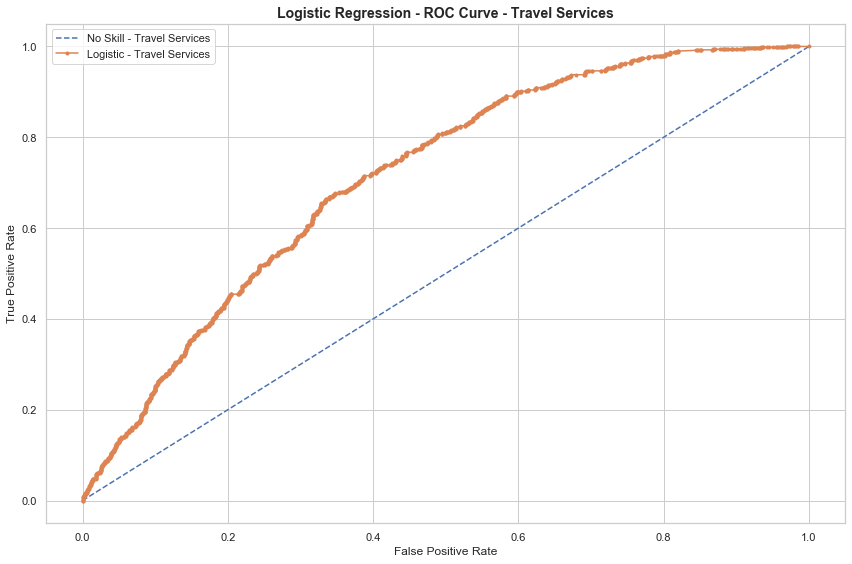

In [147]:
# Use Logistic Regression algorithms to classify which customers are going to use Deposit Service or not (0 = No, 1 = Yes)
# Using Oversample Dataframe with transformation MinMax Scaler

np.random.seed(42)
# Define model 
lr = LogisticRegression(penalty='l2',multi_class="multinomial", solver="lbfgs", C=98)

# Fit model
lr.fit(trainX, trainy)

# Predict on test set
yhat = lr.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
lr_probs = lr.predict_proba(testX)

# Keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)

# Calculate Cross valdation scores
lr_scores = cross_val_score(lr, testX, testy, cv=num_folds)

# Evaluate predictions
print('Logistic Regression - Accuracy training          : %.3f' % accuracy_score(lr.predict(trainX), trainy))
print('Logistic Regression - Accuracy test              : %.3f' % accuracy_score(testy, yhat))
print('Logistic Regression - Precision                  : %.3f' % precision_score(testy, yhat))
print('Logistic Regression - Recall                     : %.3f' % recall_score(testy, yhat))
print('Logistic Regression - F-measure                  : %.3f' % f1_score(testy, yhat))
print('Logistic Regression - Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('Logistic Regression - Cross Entropy Loss         : %.3f' % cross_entropy(yhat, testy[var_to_predict[0]]))
print('Logistic Regression - No Skill - ROC AUC         : %.3f' % (ns_auc))
print('Logistic Regression - ROC AUC                    : %.3f' % (lr_auc))
print('Logistic Regression - Cross Validation Accuracy  : %0.3f (+/- %0.3f)' % (lr_scores.mean(), lr_scores.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - '+var_to_predict_title)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic - '+var_to_predict_title)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# Show title
plt.title('Logistic Regression - ROC Curve - '+var_to_predict_title, loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
# show the plot
plt.savefig(var_to_predict_save+'_lr_roc')
plt.show()

Confusion matrix - Travel Services, without normalization - Logistic Regression
[[1414  866]
 [ 674 1575]]


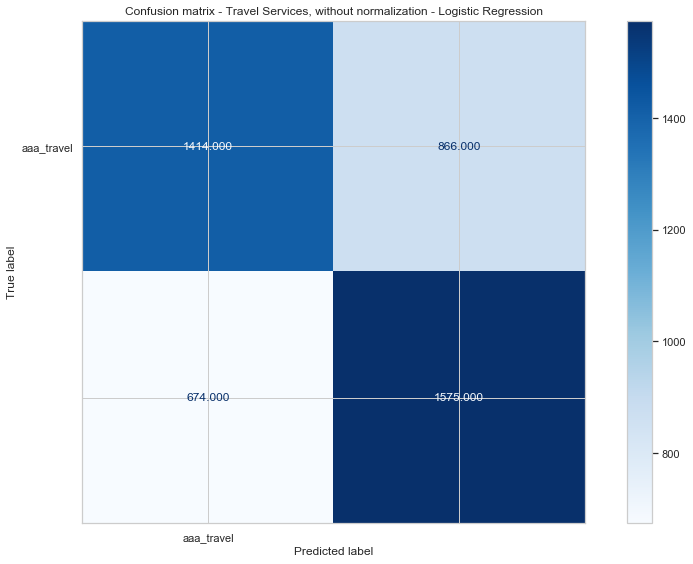

Normalized confusion matrix - Travel Services - Logistic Regression
[[0.62 0.38]
 [0.3  0.7 ]]


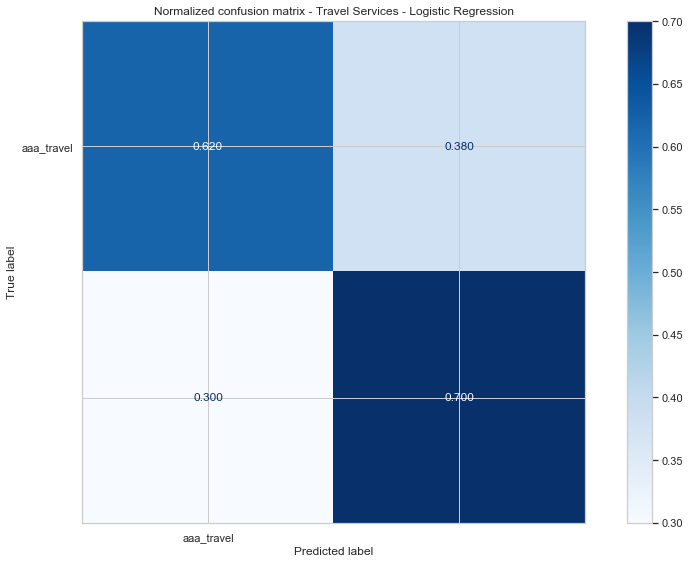

In [148]:
# Confusion Metrics
np.set_printoptions(precision=2)
i = 1
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix - "+var_to_predict_title+", without normalization - Logistic Regression", None),
                  ("Normalized confusion matrix - "+var_to_predict_title + " - Logistic Regression", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(lr, testX, testy,
                                 display_labels=testy,
                                 values_format='.3f',
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
    if i==1: plt.savefig(var_to_predict_save+'_lr_cm')
    else: plt.savefig(var_to_predict_save+'_lr_cm_1')
    i +=1
    plt.show()

In [149]:
coef_df_lgr = pd.DataFrame({'feature':testX.columns, 'coefs': lr.coef_[0]})
coef_df_lgr["abs_coeff"] = coef_df_lgr['coefs'].abs()
coef_df_lgr.sort_values("abs_coeff",ascending=False,inplace=True)
coef_df_lgr.nlargest(30,columns=["abs_coeff"])
counts_df_lgr = pd.DataFrame(coef_df_lgr.nlargest(30,columns=["abs_coeff"]), index=None)
#counts.reset_index(inplace=True)
counts_df_lgr.rename(columns={"feature": "Features (MinMax Transformer)", 'coefs':'Coefficients', 'abs_coeff': "ABS of Coeffs."}, inplace=True)
fig = ff.create_table(counts_df_lgr, height_constant=30, index=False)
fig.write_image(var_to_predict_save+'_lr_coef.png')
py.iplot(fig)

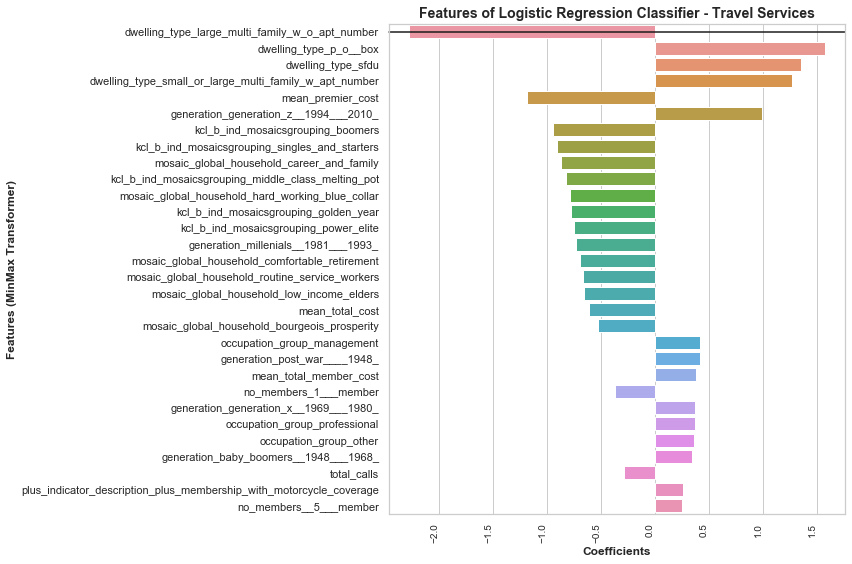

In [150]:
# Bar graph of Coefficients
sns.set(style="whitegrid")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Coefs",fontsize=12, fontweight='bold')
plt.xlabel("Features", fontsize=12, fontweight='bold')
plt.title('Features of Logistic Regression Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
sns.barplot(y=counts_df_lgr['Features (MinMax Transformer)'], x=counts_df_lgr['Coefficients'], orient='h')
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small')
plt.savefig(var_to_predict_save+'_lr_coef_1')
plt.show()

# k-Nearest Neighbors

In [151]:
# KNN Model - Grid search
np.random.seed(42)
num_folds = 10
scoring='accuracy'
weight_options = ['uniform', 'distance']
algorithm_options = ['ball_tree', 'kd_tree', 'brute']
neighbors_settings = list(range(1, 20))
leaf_options = list(range(1, 50))
param_grid = dict(n_neighbors=neighbors_settings, weights=weight_options, algorithm=algorithm_options, leaf_size=leaf_options)

knn = KNeighborsClassifier()
best_scores = []
for _ in range(10):
    rand = RandomizedSearchCV(knn, param_grid, cv=num_folds, scoring=scoring, n_iter=10)
    rand.fit(trainX,trainy)
    best_scores.append([rand.best_params_,rand.best_score_])

for i in range(len(best_scores)):
    print('The best parameters : ',best_scores[i])

The best parameters :  [{'weights': 'distance', 'n_neighbors': 12, 'leaf_size': 39, 'algorithm': 'brute'}, 0.8171716579733929]
The best parameters :  [{'weights': 'distance', 'n_neighbors': 1, 'leaf_size': 16, 'algorithm': 'kd_tree'}, 0.8646496317568229]
The best parameters :  [{'weights': 'distance', 'n_neighbors': 2, 'leaf_size': 41, 'algorithm': 'kd_tree'}, 0.8668566488894098]
The best parameters :  [{'weights': 'distance', 'n_neighbors': 2, 'leaf_size': 31, 'algorithm': 'kd_tree'}, 0.8670773994412861]
The best parameters :  [{'weights': 'distance', 'n_neighbors': 2, 'leaf_size': 16, 'algorithm': 'kd_tree'}, 0.8670773994412861]
The best parameters :  [{'weights': 'distance', 'n_neighbors': 8, 'leaf_size': 21, 'algorithm': 'ball_tree'}, 0.8169528609662231]
The best parameters :  [{'weights': 'distance', 'n_neighbors': 2, 'leaf_size': 43, 'algorithm': 'kd_tree'}, 0.8668566488894098]
The best parameters :  [{'weights': 'distance', 'n_neighbors': 2, 'leaf_size': 16, 'algorithm': 'brute'

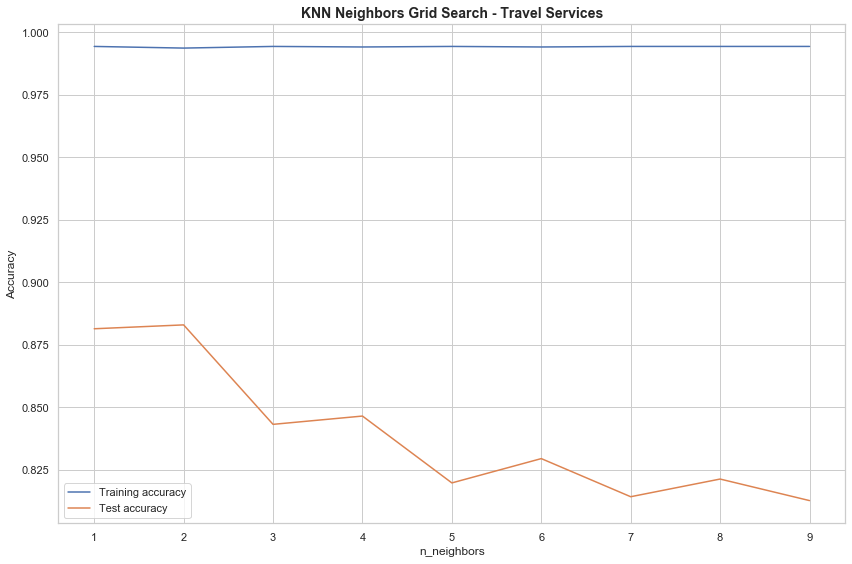

In [152]:
# KNN Model - Grid search
# The best parameters :
    # :  [{'weights': 'distance', 'n_neighbors': 2, 'leaf_size': 16, 'algorithm': 'kd_tree'}, 0.8670773994412861]
np.random.seed(42)

training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 20
neighbors_settings = range(1, 10)

for n_neighbors in neighbors_settings:
    # build the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors,  weights='distance', leaf_size=16, algorithm='kd_tree')
    knn.fit(trainX, trainy)
    # record training set accuracy
    training_accuracy.append(knn.score(trainX, trainy))
    # record test set accuracy
    test_accuracy.append(knn.score(testX, testy))

plt.plot(neighbors_settings, training_accuracy, label="Training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="Test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
# Show title
plt.title('KNN Neighbors Grid Search - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
plt.savefig(var_to_predict_save+'_knn_compare_model')

# Observations
The plot shows the training and test set accuracy on the y-axis against the setting of n_neighbors on the x-axis. Considering a single nearest neighbor, the prediction on the training set is perfect. But when more neighbors are considered, the training accuracy drops, indicating that using more than 2 neighbor leads to a model that is too complex.

The best performance is somewhere around 2 neighbors. Still, it is good to keep the scale of the plot in mind. The worst performance is more than 82% accuracy, which might still be pretty good.

The above plot suggests that we should choose n_neighbors= where the model gets its stability. 
Outcome of the Grid Search above 
* The best parameters : [{'weights':'distance', 'n_neighbors': 2, 'leaf_size': 16, 'algorithm': 'kd_tree'}, 0.8670773994412861]
    

Accuracy of K-NN classifier on training set: 0.994
Accuracy of K-NN classifier on test set: 0.883
K-NN classifier - Precision                  : 0.830
K-NN classifier - Recall                     : 0.961
K-NN classifier - F-measure                  : 0.891
K-NN classifier - Log-Loss                   : 4.042
K-NN Classifier - Cross Entropy Loss         : 0.224
K-NN classifier - No Skill - ROC AUC         : 0.500
K-NN classifier - ROC AUC                    : 0.897
K-NN classifier - Cross Validation Accuracy  : 0.867 (+/- 0.032)


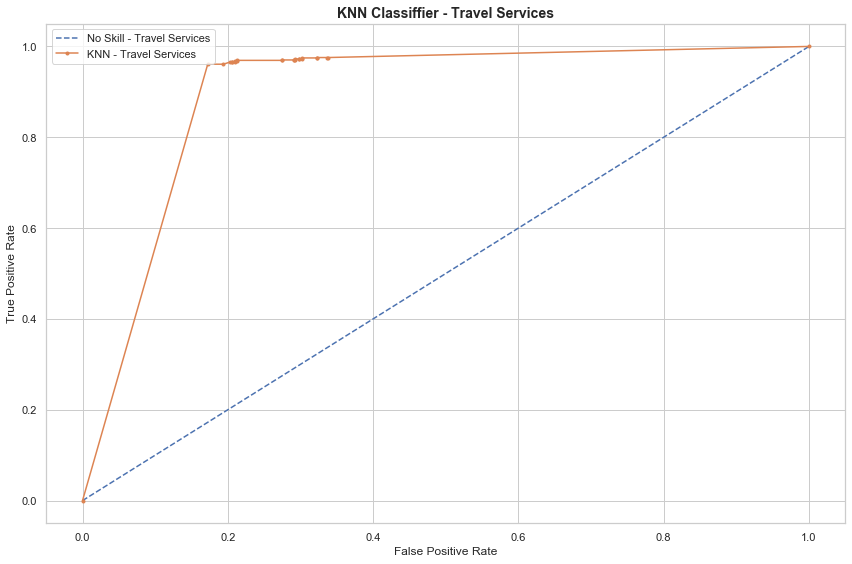

In [153]:
# Best model
knn = KNeighborsClassifier(n_neighbors=2, weights='distance', leaf_size=16, algorithm='kd_tree')
knn.fit(trainX, trainy)


print('Accuracy of K-NN classifier on training set: {:.3f}'.format(knn.score(trainX, trainy)))
print('Accuracy of K-NN classifier on test set: {:.3f}'.format(knn.score(testX, testy)))

# Predict on test set
yhat = knn.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
knn_probs = knn.predict_proba(testX)

# Keep probabilities for the positive outcome only
knn_probs = knn_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
knn_auc = roc_auc_score(testy, knn_probs)

# Calculate Cross valdation scores
knn_scores = cross_val_score(knn, testX, testy, cv=num_folds)

# Evaluate predictions
print('K-NN classifier - Precision                  : %.3f' % precision_score(testy, yhat))
print('K-NN classifier - Recall                     : %.3f' % recall_score(testy, yhat))
print('K-NN classifier - F-measure                  : %.3f' % f1_score(testy, yhat))
print('K-NN classifier - Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('K-NN Classifier - Cross Entropy Loss         : %.3f' % cross_entropy(yhat, testy[var_to_predict[0]]))
print('K-NN classifier - No Skill - ROC AUC         : %.3f' % (ns_auc))
print('K-NN classifier - ROC AUC                    : %.3f' % (knn_auc))
print("K-NN classifier - Cross Validation Accuracy  : %0.3f (+/- %0.3f)" % (knn_scores.mean(), knn_scores.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
knn_fpr, knn_tpr, _ = roc_curve(testy, knn_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - '+var_to_predict_title)
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN - '+var_to_predict_title)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# Show title
plt.title('KNN Classiffier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
# show the plot
plt.savefig(var_to_predict_save+'_knn_roc')
plt.show()

Confusion matrix - Travel Services, without normalization - KNN Classiffier
[[1838  442]
 [  88 2161]]


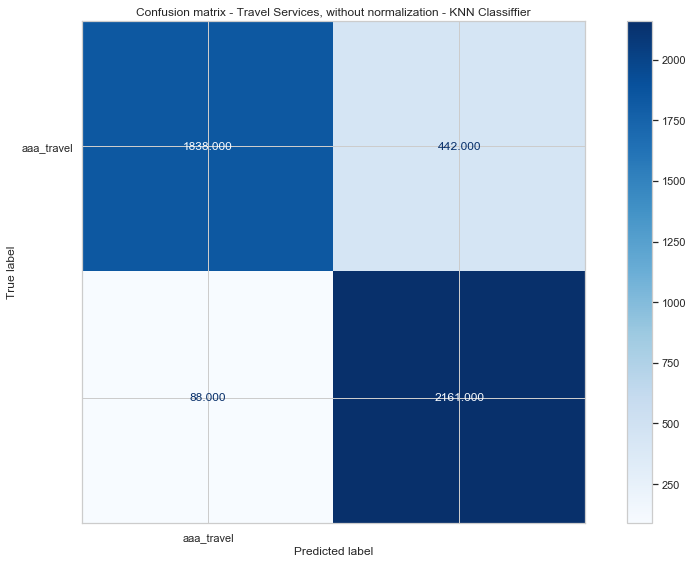

Normalized confusion matrix - Travel Services - KNN Classiffier
[[0.81 0.19]
 [0.04 0.96]]


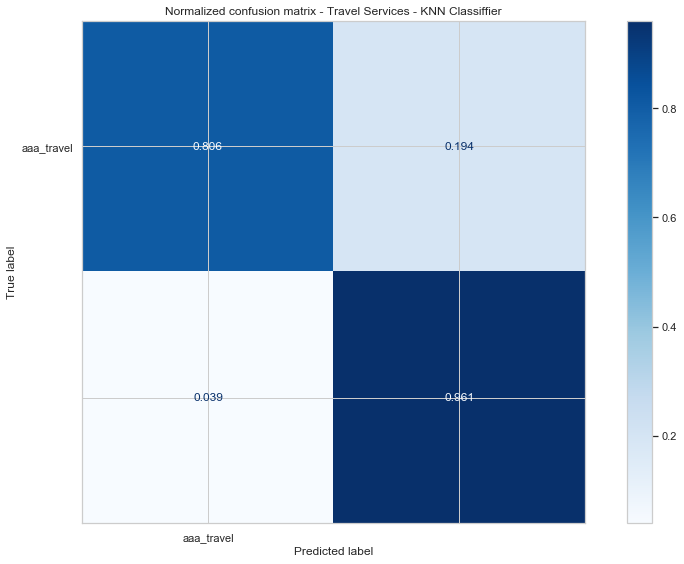

In [154]:
# Confusion Metrics
np.set_printoptions(precision=2)
i = 1
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix - "+var_to_predict_title+", without normalization - KNN Classiffier", None),
                  ("Normalized confusion matrix - "+var_to_predict_title+" - KNN Classiffier", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(knn, testX, testy,
                                 display_labels=testy,
                                 values_format='.3f',
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    if i==1: plt.savefig(var_to_predict_save+'_knn_cm')
    else: plt.savefig(var_to_predict_save+'_knn_cm_1')
    i +=1
    plt.show()

# CART  Model - DecisionTreeClassifier

In [156]:
# DecisionTreeClasifier
np.random.seed(42)

#create a dictionary of all values we want to test
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(82, 105,1)}

# decision tree model
cart = DecisionTreeClassifier()

#use gridsearch to test all values
cart_gscv = GridSearchCV(cart, param_grid, cv=num_folds)

#fit model to data
cart_gscv.fit(trainX, trainy)
print('Best parameters : ', cart_gscv.best_params_)
print('Best Score      : ', cart_gscv.best_score_)

Best parameters :  {'criterion': 'entropy', 'max_depth': 89}
Best Score      :  0.8540545820391099


# Observation

Based on the grid search above, the best parameter for the Decission Tree Classifier is:
* The 1st run showed 
    * Best parameters :  {'criterion': 'entropy', 'max_depth': 92}
    * Best Score      :  0.8551554044814316
    * As I am using an increment of 10, rerun it, using increment of 1 from +-10

* Narrowing the parameters
    * Best parameters :  {'criterion': 'entropy', 'max_depth': 89}
    * Best Score      :  0.8540545820391099

CART - Accuracy on training set: 0.994
CART - Accuracy on test set: 0.876
CART - Precision                  : 0.819
CART - Recall                     : 0.963
CART - F-measure                  : 0.885
CART - Log-Loss                   : 4.278
CART - Cross Entropy Loss         : 0.211
CART - No Skill - ROC AUC         : 0.500
CART - ROC AUC                    : 0.880
CART - Cross Validation Accuracy  : 0.859 (+/- 0.022)


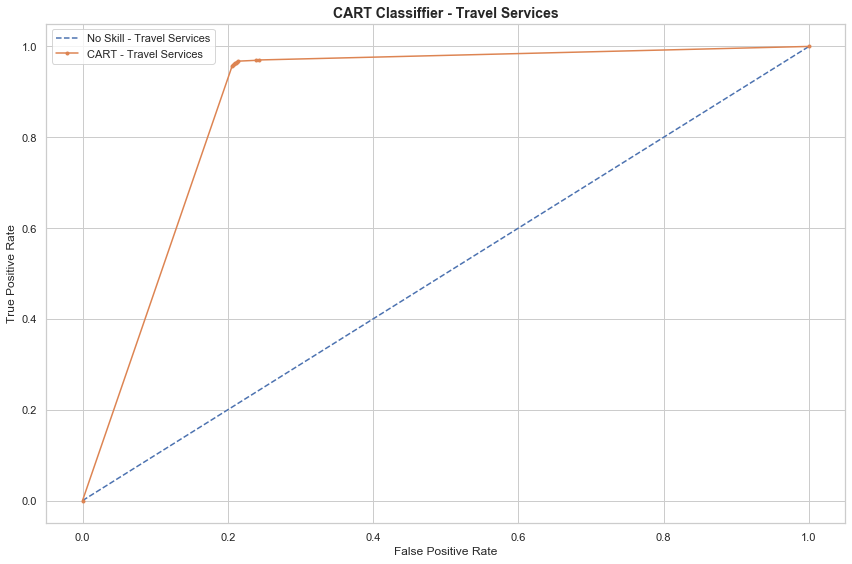

In [157]:
# Modeling based on the outcome of the grid serach
cart = DecisionTreeClassifier(criterion = 'entropy', max_depth=89)
cart.fit(trainX, trainy)

# Predict on test set
yhat = cart.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
cart_probs = cart.predict_proba(testX)

# Keep probabilities for the positive outcome only
cart_probs = cart_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
cart_auc = roc_auc_score(testy, cart_probs)

# Calculate Cross valdation scores
cart_scores = cross_val_score(cart, testX, testy, cv=num_folds)

print("CART - Accuracy on training set: {:.3f}".format(cart.score(trainX, trainy)))
print("CART - Accuracy on test set: {:.3f}".format(cart.score(testX, testy)))

# Evaluate predictions
print('CART - Precision                  : %.3f' % precision_score(testy, yhat))
print('CART - Recall                     : %.3f' % recall_score(testy, yhat))
print('CART - F-measure                  : %.3f' % f1_score(testy, yhat))
print('CART - Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('CART - Cross Entropy Loss         : %.3f' % cross_entropy(yhat, testy[var_to_predict[0]]))
print('CART - No Skill - ROC AUC         : %.3f' % (ns_auc))
print('CART - ROC AUC                    : %.3f' % (cart_auc))
print("CART - Cross Validation Accuracy  : %0.3f (+/- %0.3f)" % (cart_scores.mean(), cart_scores.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
cart_fpr, cart_tpr, _ = roc_curve(testy, cart_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - '+var_to_predict_title)
plt.plot(cart_fpr, cart_tpr, marker='.', label='CART - '+var_to_predict_title)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title('CART Classiffier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
# show the plot
plt.savefig(var_to_predict_save+'_cart_roc')
# show the plot
plt.show()

Confusion matrix - Travel Services, without normalization - CART
[[1802  478]
 [  83 2166]]


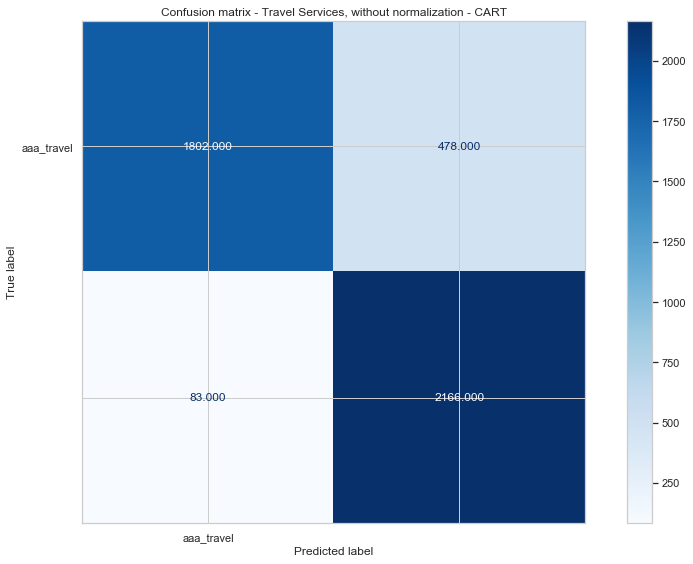

CART - Normalized confusion matrix - Travel Services
[[0.79 0.21]
 [0.04 0.96]]


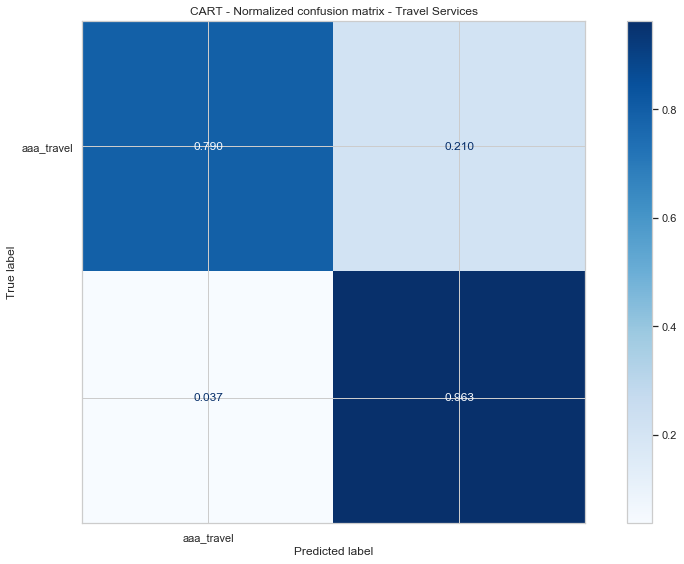

In [158]:
# Confusion Metrics
np.set_printoptions(precision=2)

i = 1
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix - "+var_to_predict_title+", without normalization - CART", None),
                  ("CART - Normalized confusion matrix - "+var_to_predict_title, 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(cart, testX, testy,
                                 display_labels=testy,
                                 values_format='.3f',
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

    if i==1: plt.savefig(var_to_predict_save+'_cart_cm')
    else: plt.savefig(var_to_predict_save+'_cart_cm_1')
    i +=1
    plt.show()

# Feature importance in trees
feature importance rates how important each feature is for the decision a tree makes. It is a number between 0 and 1 for each feature, where 0 means “not used at all” and 1 means “perfectly predicts the target.” The feature importances always sum to 1:

In [159]:
coef_df_cart = pd.DataFrame({'feature':testX.columns, 'coefs': cart.feature_importances_})
coef_df_cart["abs_coeff"] = coef_df_cart['coefs'].abs()
coef_df_cart.sort_values("abs_coeff",ascending=False,inplace=True)
coef_df_cart.nlargest(30,columns=["abs_coeff"])
counts_cart = pd.DataFrame(coef_df_cart.nlargest(30,columns=["abs_coeff"]), index=None)
counts_cart.rename(columns={"feature": "Features (MinMax Transformer)", 'coefs':'Coefficients', 'abs_coeff': "ABS of Coeffs."}, inplace=True)
fig = ff.create_table(counts_cart, height_constant=30, index=False)
fig.write_image(var_to_predict_save+'_cart_coef.png')
py.iplot(fig)

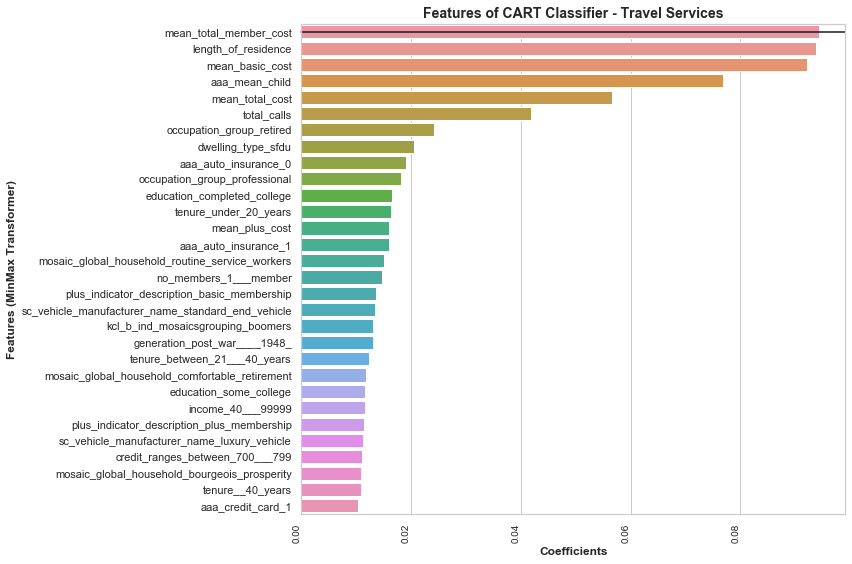

In [160]:
# Bar graph of Coefficients
sns.set(style="whitegrid")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Coefs",fontsize=12, fontweight='bold')
plt.xlabel("Features", fontsize=12, fontweight='bold')
plt.title('Features of CART Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
sns.barplot(y=counts_cart['Features (MinMax Transformer)'], x=counts_cart['Coefficients'], orient='h')
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small')
plt.savefig(var_to_predict_save+'_cart_coef_1')
plt.show()

# Random Forest Classifier Model

In [162]:
np.random.seed(42)
num_folds = 10
scoring = 'accuracy'
#create a dictionary of all values we want to test
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(102, 125, 1)}

# Random Forest Classifier model
rf = RandomForestClassifier()

#use gridsearch to test all values
rf_gscv = GridSearchCV(rf, param_grid, cv=num_folds, scoring=scoring)

#fit model to data
rf_gscv.fit(trainX, trainy)
print('Best parameters : ', rf_gscv.best_params_)
print('Best score      : ', rf_gscv.best_score_)

Best parameters :  {'criterion': 'entropy', 'max_depth': 106}
Best score      :  0.9185259528414308


# Observation
Based on the grid search above, th best parameter for the Random Forest Classifier is:
* The 1st run showed a max_depth of 112, with gini, as I am using an increment of 10, rerun it, using increment of 1 from +-10
    * Best parameters :  {'criterion': 'gini', 'max_depth': 112}
    * Best score      :  0.9174226884682255
* Narrowing the search around the best parameter of the 1st search
    * Best parameters :  {'criterion': 'entropy', 'max_depth': 106}
    * Best score      :  0.9185259528414308

Random Forest - Accuracy on training set: 0.994
Random Forest - Accuracy on test set: 0.874
Random Forest - Precision                  : 0.816
Random Forest - Recall                     : 0.964
Random Forest - F-measure                  : 0.883
Random Forest - Log-Loss                   : 4.362
Random Forest - Cross Entropy Loss         : 0.208
Random Forest - No Skill - ROC AUC         : 0.500
Random Forest - ROC AUC                    : 0.878
Random Forest - Cross Validation Accuracy  : 0.860 (+/- 0.022)


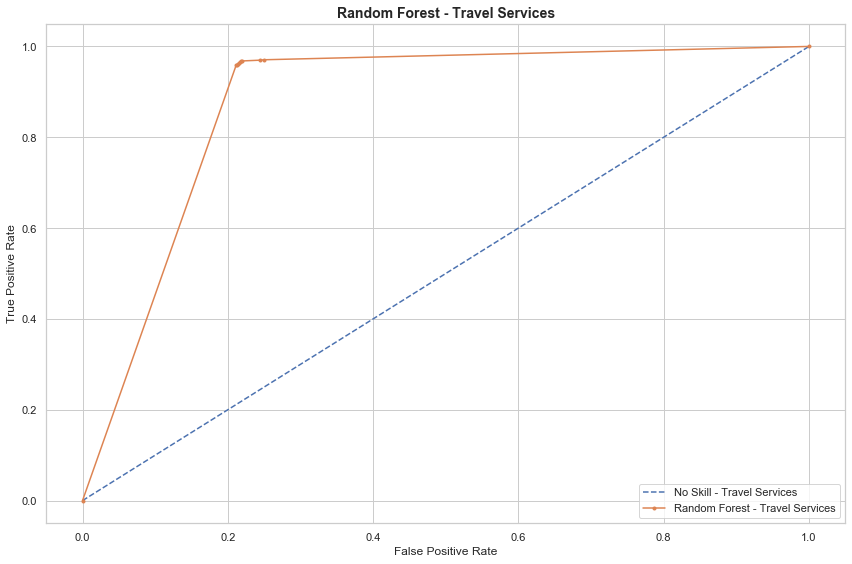

In [165]:
# Modeling based on the outcome of the grid serach of the random forest
rf = DecisionTreeClassifier(criterion = 'entropy', max_depth=106)
rf.fit(trainX, trainy)

# Predict on test set
yhat = rf.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
rf_probs = rf.predict_proba(testX)

# Keep probabilities for the positive outcome only
rf_probs = rf_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
rf_auc = roc_auc_score(testy, rf_probs)

# Calculate Cross valdation scores
rf_scores = cross_val_score(rf, testX, testy, cv=num_folds)

print("Random Forest - Accuracy on training set: {:.3f}".format(rf.score(trainX, trainy)))
print("Random Forest - Accuracy on test set: {:.3f}".format(rf.score(testX, testy)))

# Evaluate predictions
#print('Accuracy                   : %.3f' % accuracy_score(testy, yhat))
print('Random Forest - Precision                  : %.3f' % precision_score(testy, yhat))
print('Random Forest - Recall                     : %.3f' % recall_score(testy, yhat))
print('Random Forest - F-measure                  : %.3f' % f1_score(testy, yhat))
print('Random Forest - Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('Random Forest - Cross Entropy Loss         : %.3f' % cross_entropy(yhat, testy[var_to_predict[0]]))
print('Random Forest - No Skill - ROC AUC         : %.3f' % (ns_auc))
print('Random Forest - ROC AUC                    : %.3f' % (rf_auc))
print("Random Forest - Cross Validation Accuracy  : %0.3f (+/- %0.3f)" % (rf_scores.mean(), rf_scores.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(testy, rf_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - '+var_to_predict_title)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest - '+var_to_predict_title)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title('Random Forest - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
# show the plot
plt.savefig(var_to_predict_save+'_rf_roc')
plt.show()

Confusion matrix - Travel Services, without normalization - Random Forest
[[1790  490]
 [  82 2167]]


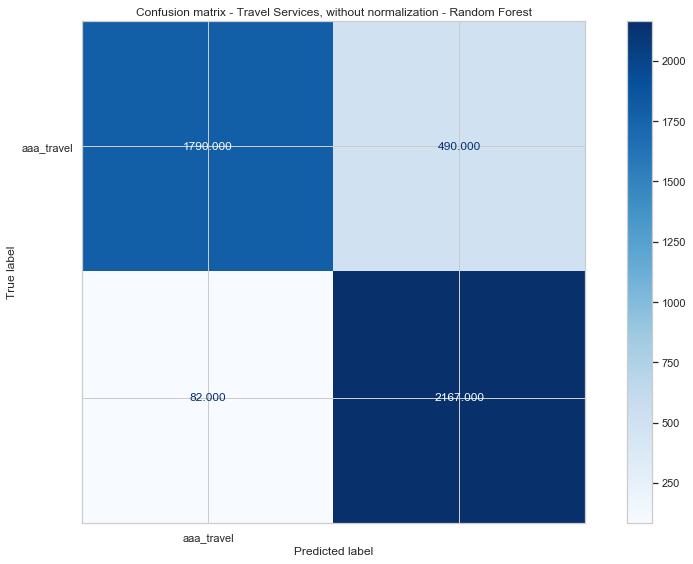

Normalized confusion matrix - Travel Services - Random Forest
[[0.79 0.21]
 [0.04 0.96]]


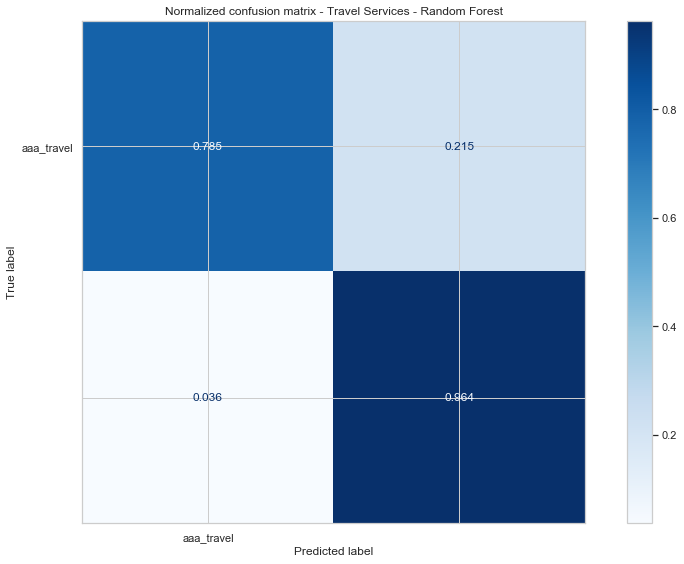

In [166]:
# Confusion Metrics
np.set_printoptions(precision=2)
i = 1 
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix - "+var_to_predict_title+ ", without normalization - Random Forest", None),
                  ("Normalized confusion matrix - "+var_to_predict_title+" - Random Forest", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rf, testX, testy,
                                 display_labels=testy,
                                 values_format='.3f',
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    if i==1: plt.savefig(var_to_predict_save+'_rf_cm')
    else: plt.savefig(var_to_predict_save+'_rf_cm_1')
    i +=1
    plt.show()

# Feature importance
feature importance rates how important each feature is for the random forest tree makes. It is a number between 0 and 1 for each feature, where 0 means “not used at all” and 1 means “perfectly predicts the target.” The feature importances always sum to 1:

In [167]:
coef_df_rf = pd.DataFrame({'feature':testX.columns, 'coefs': rf.feature_importances_})
coef_df_rf["abs_coeff"] = coef_df_rf['coefs'].abs()
coef_df_rf.sort_values("abs_coeff",ascending=False,inplace=True)
coef_df_rf.nlargest(30,columns=["abs_coeff"])
counts_rf = pd.DataFrame(coef_df_rf.nlargest(30,columns=["abs_coeff"]), index=None)
counts_rf.rename(columns={"feature": "Features (MinMax Transformer)", 'coefs':'Coefficients', 'abs_coeff': "ABS of Coeffs."}, inplace=True)
fig = ff.create_table(counts_rf, height_constant=30, index=False)
fig.write_image(var_to_predict_save+'_rf_coef.png')
py.iplot(fig)

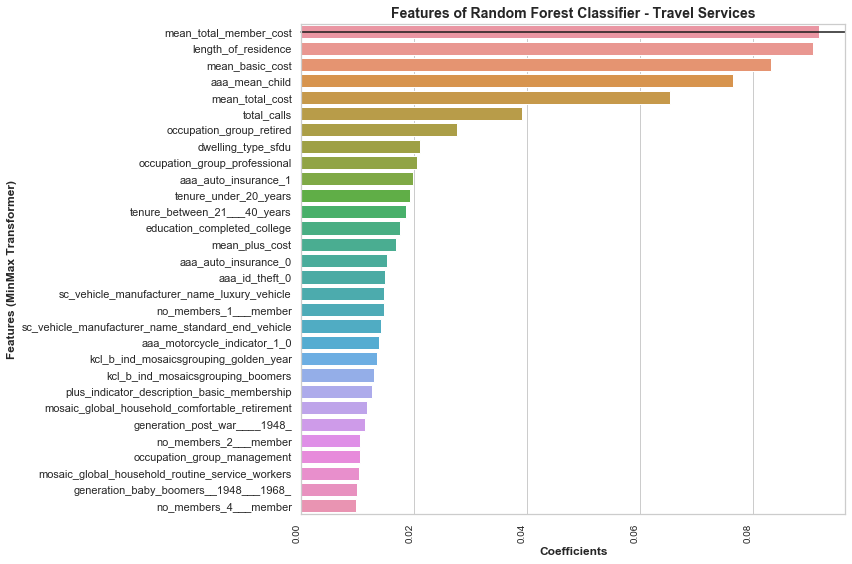

In [168]:
# Bar graph of Coefficients
sns.set(style="whitegrid")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Coefs",fontsize=12, fontweight='bold')
plt.xlabel("Features", fontsize=12, fontweight='bold')
plt.title('Features of Random Forest Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
sns.barplot(y=counts_rf['Features (MinMax Transformer)'], x=counts_rf['Coefficients'], orient='h')
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small')
plt.savefig(var_to_predict_save+'_rf_coef_1')
plt.show()

# ExtraTreesClassifier Classifier

In [170]:
np.random.seed(42)
#create a dictionary of all values we want to test
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(20, 44,1)}

# Random Forest Classifier model
et = ExtraTreesClassifier()

#use gridsearch to test all values
et_gscv = GridSearchCV(et, param_grid, cv=num_folds, scoring=scoring)

#fit model to data
et_gscv.fit(trainX, trainy)
print('Best parameters : ', et_gscv.best_params_)
print('Best score      : ', et_gscv.best_score_)

Best parameters :  {'criterion': 'gini', 'max_depth': 34}
Best score      :  0.9317719627263669


# Observation
Based on the grid search above, th best parameter for the Random Forest Classifier is:
* The 1st run showed a max_depth of 32, with gini, as I am using an increment of 10, rerun it, using increment of 1 from +-10
    * Best parameters :  {'criterion': 'gini', 'max_depth': 32}
    * Best score      :  0.9328766922581023
* Narrowing the search around the best parameter of the 1st search
    * Best parameters :  {'criterion': 'gini', 'max_depth': 34}
    * Best score      :  0.9317719627263669

Extra Tree Classifier - Accuracy on training set: 0.994
Extra Tree Classifier - Accuracy on test set: 0.955
Extra Tree Classifier - Precision                  : 0.952
Extra Tree Classifier - Recall                     : 0.957
Extra Tree Classifier - F-measure                  : 0.955
Extra Tree Classifier - Log-Loss                   : 1.563
Extra Tree Classifier - Cross Entropy Loss         : 0.244
Extra Tree Classifier - No Skill - ROC AUC         : 0.500
Extra Tree Classifier - ROC AUC                    : 0.981
Extra Tree Classifier - Cross Validation Accuracy  : 0.936 (+/- 0.026)


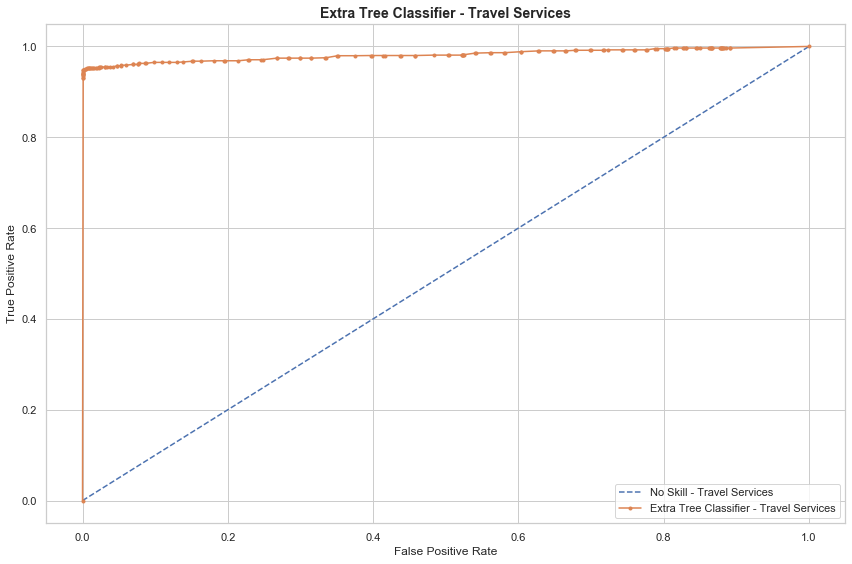

In [171]:
# Modeling based on the outcome of the grid serach of the random forest
et = ExtraTreesClassifier(criterion = 'gini', max_depth=34)
et.fit(trainX, trainy)

# Predict on test set
yhat = et.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
et_probs = et.predict_proba(testX)

# Keep probabilities for the positive outcome only
et_probs = et_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
et_auc = roc_auc_score(testy, et_probs)

# Calculate Cross valdation scores
scores_et = cross_val_score(et, testX, testy, cv=num_folds)

print("Extra Tree Classifier - Accuracy on training set: {:.3f}".format(et.score(trainX, trainy)))
print("Extra Tree Classifier - Accuracy on test set: {:.3f}".format(et.score(testX, testy)))

# Evaluate predictions
#print('Accuracy                   : %.3f' % accuracy_score(testy, yhat))
print('Extra Tree Classifier - Precision                  : %.3f' % precision_score(testy, yhat))
print('Extra Tree Classifier - Recall                     : %.3f' % recall_score(testy, yhat))
print('Extra Tree Classifier - F-measure                  : %.3f' % f1_score(testy, yhat))
print('Extra Tree Classifier - Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('Extra Tree Classifier - Cross Entropy Loss         : %.3f' % cross_entropy(yhat, testy[var_to_predict[0]]))
print('Extra Tree Classifier - No Skill - ROC AUC         : %.3f' % (ns_auc))
print('Extra Tree Classifier - ROC AUC                    : %.3f' % (et_auc))
print("Extra Tree Classifier - Cross Validation Accuracy  : %0.3f (+/- %0.3f)" % (scores_et.mean(), scores_et.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
et_fpr, et_tpr, _ = roc_curve(testy, et_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - '+var_to_predict_title)
plt.plot(et_fpr, et_tpr, marker='.', label='Extra Tree Classifier - '+var_to_predict_title)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title('Extra Tree Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
# show the plot
plt.savefig(var_to_predict_save+'_et_roc')
plt.show()

Confusion matrix - Travel Services, without normalization - Extra Tree Classifier
[[2171  109]
 [  96 2153]]


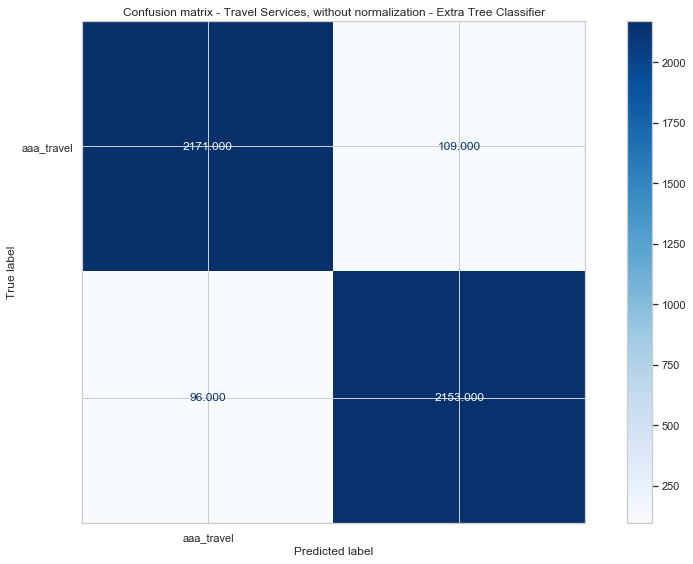

Extra Tree Classifier - Normalized confusion matrix - Travel Services
[[0.95 0.05]
 [0.04 0.96]]


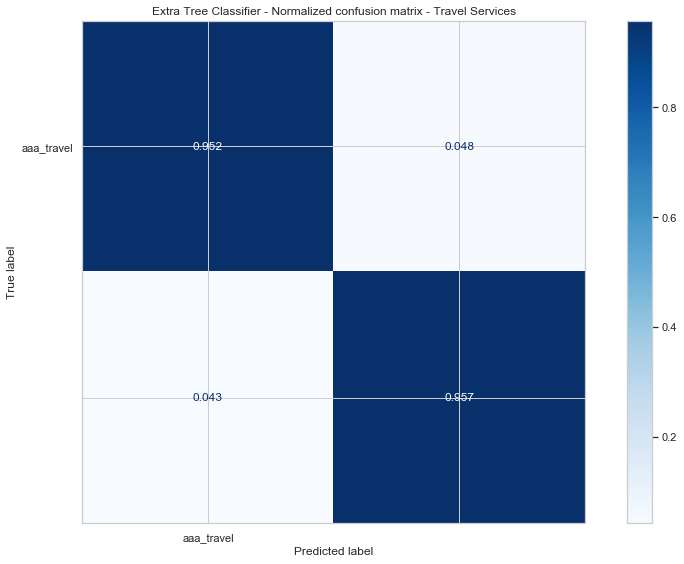

In [172]:
# Confusion Metrics
np.set_printoptions(precision=2)
i = 1
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix - "+var_to_predict_title+", without normalization - Extra Tree Classifier", None),
                  ("Extra Tree Classifier - Normalized confusion matrix - "+var_to_predict_title, 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(et, testX, testy,
                                 display_labels=testy,
                                 values_format='.3f',
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    if i==1: plt.savefig(var_to_predict_save+'_et_cm')
    else: plt.savefig(var_to_predict_save+'_et_cm_1')
    i +=1
    plt.show()

In [173]:
coef_df_et = pd.DataFrame({'feature':testX.columns, 'coefs': et.feature_importances_})
coef_df_et["abs_coeff"] = coef_df_et['coefs'].abs()
coef_df_et.sort_values("abs_coeff",ascending=False,inplace=True)
coef_df_et.nlargest(30,columns=["abs_coeff"])
counts_et = pd.DataFrame(coef_df_et.nlargest(30,columns=["abs_coeff"]), index=None)
counts_et.rename(columns={"feature": "Features (MinMax Transformer)", 'coefs':'Coefficients', 'abs_coeff': "ABS of Coeffs."}, inplace=True)
fig = ff.create_table(counts_et, height_constant=30, index=False)
fig.write_image(var_to_predict_save+'_et_coef.png')
py.iplot(fig)

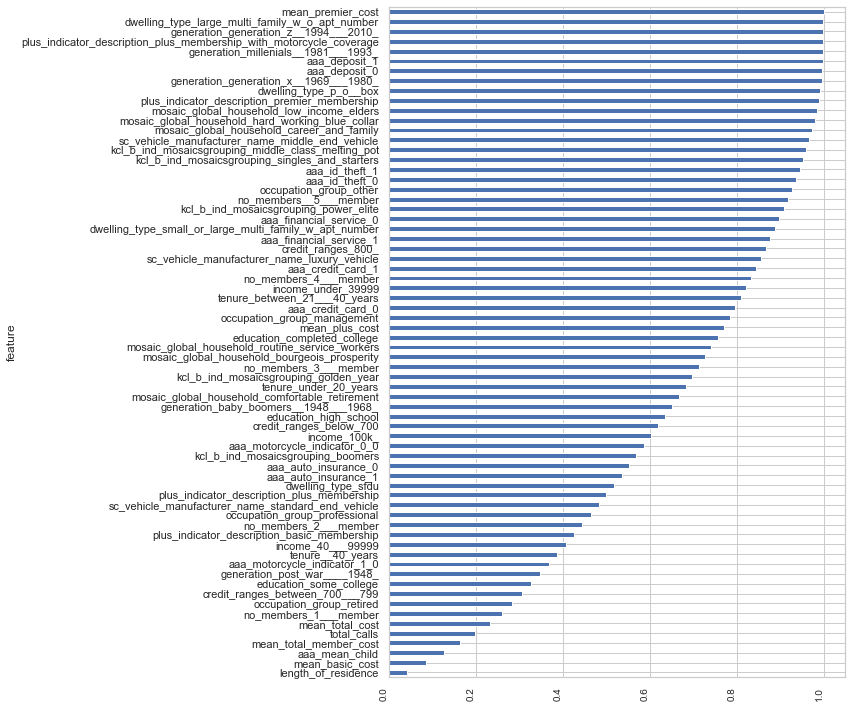

In [174]:
df_cumsum = coef_df_et.copy()
df_cumsum.set_index('feature', inplace=True)
df_cumsum.abs_coeff.cumsum().plot(kind='barh', figsize=(12,10))
plt.xticks(
            rotation=90, 
            horizontalalignment='right',
            fontweight='light',
            fontsize='small')
plt.show()

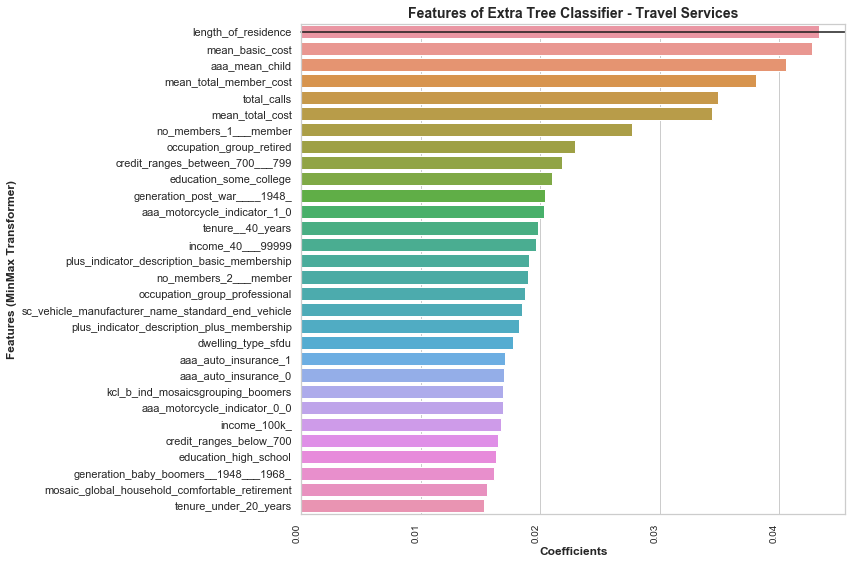

In [175]:
# Bar graph of Coefficients
sns.set(style="whitegrid")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Coefs",fontsize=12, fontweight='bold')
plt.xlabel("Features", fontsize=12, fontweight='bold')
plt.title('Features of Extra Tree Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
sns.barplot(y=counts_et['Features (MinMax Transformer)'], x=counts_et['Coefficients'], orient='h')
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small')
plt.savefig(var_to_predict_save+'_et_coef_1')
plt.show()

# XGBOOSTING Modeling

In [203]:
np.random.seed(42)
scoring = 'accuracy'
#create a dictionary of all values we want to test
param_grid = {'max_depth': [5,6,7], 'n_estimators': range(50, 260, 50), 
              'learning_rate': [0.1, 0.01, 0.05], 'min_child_weight':[2,4],
              'gamma':[0.1]
             }
# CV model
xgb = XGBClassifier(objective= 'binary:logistic',nthread=4)
kfold = KFold(n_splits=num_folds)
xgb_gscv = GridSearchCV(estimator=xgb,param_grid=param_grid, scoring = scoring, 
                        n_jobs = 10, cv = kfold,verbose=True
                       )
xgb_gscv.fit(trainX, trainy)
print('Best parameters - : ', xgb_gscv.best_params_)
print('Best score      : ', xgb_gscv.best_score_)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   44.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  5.2min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed: 11.9min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed: 21.8min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed: 39.5min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed: 65.6min
[Parallel(n_jobs=10)]: Done 1800 out of 1800 | elapsed: 67.2min finished


Best parameters - :  {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 250}
Best score      :  0.8657553380609114


# Observation
Best parameters - :  {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 250}
Best score      :  0.8657553380609114

XGBoost Classifier - Accuracy on training set: 0.983
XGBoost Classifier - Accuracy on test set: 0.879
XGBoost Classifier - Precision                  : 0.840
XGBoost Classifier - Recall                     : 0.934
XGBoost Classifier - F-measure                  : 0.885
XGBoost Classifier - Log-Loss                   : 4.179
XGBoost Classifier - Cross Entropy Loss         : 0.376
XGBoost Classifier - No Skill - ROC AUC         : 0.500
XGBoost Classifier - ROC AUC                    : 0.955
XGBoost Classifier - Cross Validation Accuracy  : 0.869 (+/- 0.016)


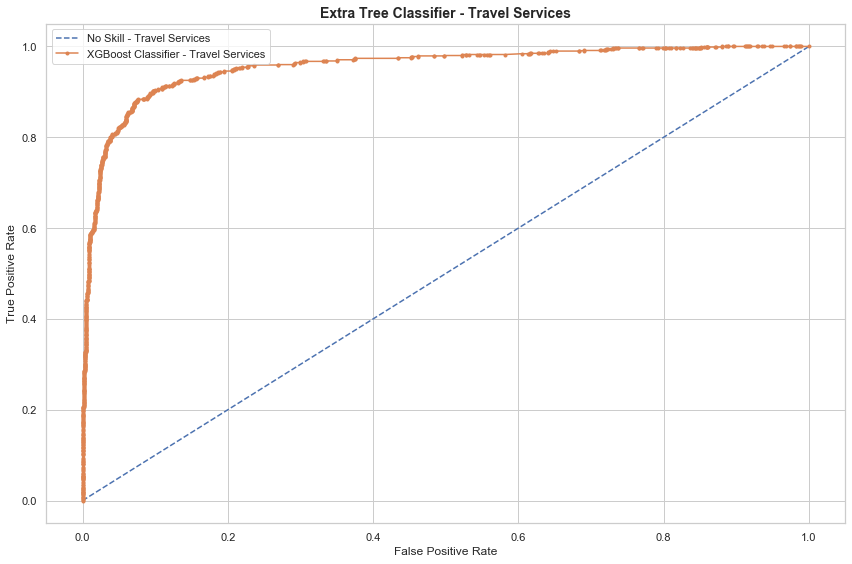

In [204]:
# Modeling based on the outcome of the grid serach of the random forest
xgb = xgb = XGBClassifier(objective= 'binary:logistic',nthread=4, gamma=0.1,
                          learning_rate=0.1, max_depth=7, min_child_weight=2,
                          n_estimators=250                        
                         )
xgb.fit(trainX, trainy)

# Predict on test set
yhat = xgb.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
xgb_probs = xgb.predict_proba(testX)

# Keep probabilities for the positive outcome only
xgb_probs = xgb_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
xgb_auc = roc_auc_score(testy, xgb_probs)

# Calculate Cross valdation scores
scores_xgb = cross_val_score(xgb, testX, testy, cv=num_folds)

print("XGBoost Classifier - Accuracy on training set: {:.3f}".format(xgb.score(trainX, trainy)))
print("XGBoost Classifier - Accuracy on test set: {:.3f}".format(xgb.score(testX, testy)))

# Evaluate predictions
#print('Accuracy                   : %.3f' % accuracy_score(testy, yhat))
print('XGBoost Classifier - Precision                  : %.3f' % precision_score(testy, yhat))
print('XGBoost Classifier - Recall                     : %.3f' % recall_score(testy, yhat))
print('XGBoost Classifier - F-measure                  : %.3f' % f1_score(testy, yhat))
print('XGBoost Classifier - Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('XGBoost Classifier - Cross Entropy Loss         : %.3f' % cross_entropy(yhat, testy[var_to_predict[0]]))
print('XGBoost Classifier - No Skill - ROC AUC         : %.3f' % (ns_auc))
print('XGBoost Classifier - ROC AUC                    : %.3f' % (xgb_auc))
print("XGBoost Classifier - Cross Validation Accuracy  : %0.3f (+/- %0.3f)" % (scores_xgb.mean(), scores_xgb.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(testy, xgb_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - '+var_to_predict_title)
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGBoost Classifier - '+var_to_predict_title)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title('Extra Tree Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
# show the plot
plt.savefig(var_to_predict_save+'_xgb_roc')
plt.show()

In [207]:
coef_df_xgb = pd.DataFrame({'feature':testX.columns, 'coefs': xgb.feature_importances_})
coef_df_xgb["abs_coeff"] = coef_df_xgb['coefs'].abs()
coef_df_xgb.sort_values("abs_coeff",ascending=False,inplace=True)
coef_df_xgb.nlargest(30,columns=["abs_coeff"])
counts_xgb = pd.DataFrame(coef_df_xgb.nlargest(30,columns=["abs_coeff"]), index=None)
counts_xgb.rename(columns={"feature": "Features (MinMax Transformer)", 'coefs':'Coefficients', 'abs_coeff': "ABS of Coeffs."}, inplace=True)
fig = ff.create_table(counts_xgb, height_constant=30, index=False)
fig.write_image(var_to_predict_save+'_xgb_coef.png')
py.iplot(fig)

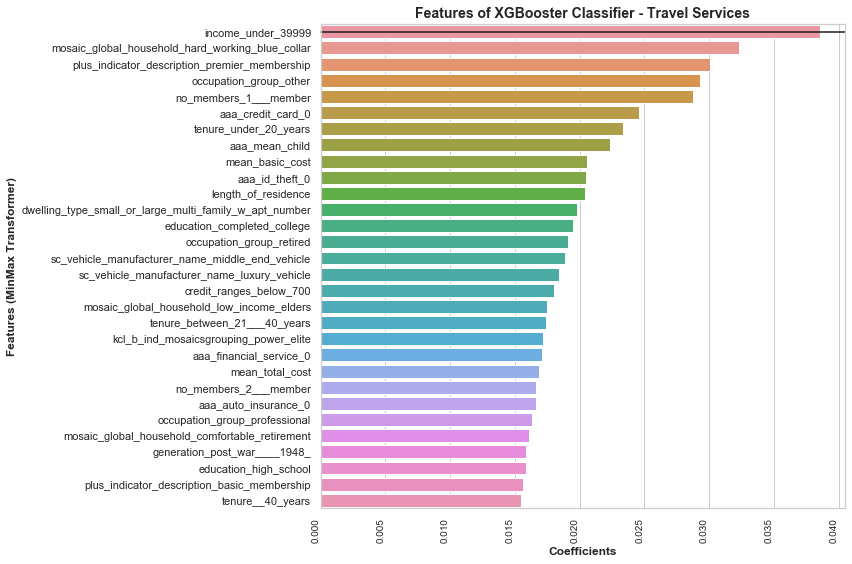

In [208]:
# Bar graph of Coefficients
sns.set(style="whitegrid")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Coefs",fontsize=12, fontweight='bold')
plt.xlabel("Features", fontsize=12, fontweight='bold')
plt.title('Features of XGBooster Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
sns.barplot(y=counts_xgb['Features (MinMax Transformer)'], x=counts_xgb['Coefficients'], orient='h')
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small')
plt.savefig(var_to_predict_save+'_xgb_coef_1')
plt.show()

# Keras Modeling

In [ ]:
# Keras Classifier
from keras.models import Sequential
from keras.layers import Dense

np.random.seed(42)
# Create input and output dataframes
X_df = pd.DataFrame(df_test_over,columns=X_cols)
y_df = pd.DataFrame(df_test_over,columns=y_cols)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df_mm = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=X_cols)

num_folds = 10
scoring = 'accuracy'

# Split Train and test
trainX, testX, trainy, testy = train_test_split(scaled_df_mm, y_df, test_size=test_size)


# create model
model = Sequential()
model.add(Dense(trainX.shape[1], input_dim=trainX.shape[1], activation='relu'))
model.add(Dense(int(trainX.shape[1]/2), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[scoring])
# Fit the model
model.fit(trainX, trainy, validation_data=(testX,testy), epochs=150, batch_size=10)
# evaluate the model
scores = model.evaluate(trainX, trainy)
print("\nTrain Set - %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

scores = model.evaluate(testX, testy)
print("\nTest Set - %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [ ]:
# Keras Grid Search
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier


# Function to create model, required for KerasClassifier
def create_model(optimizer='rmsprop', init='glorot_uniform'):
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=trainX.shape[1], kernel_initializer=init, activation='relu'))
    model.add(Dense(8, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# fix random seed for reproducibility
np.random.seed(42)

# Create input and output dataframes
X_df = pd.DataFrame(df_test_over,columns=X_cols)
y_df = pd.DataFrame(df_test_over,columns=y_cols)

# Transform X dataframe
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df_mm = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=X_cols)

num_folds = 10
scoring = 'accuracy'

# Split Train and test
trainX, testX, trainy, testy = train_test_split(scaled_df_mm, y_df, test_size=test_size)

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam']
inits = ['glorot_uniform', 'normal', 'uniform']
epochs = [50, 100, 150]
batches = [5, 10, 20]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=inits)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(trainX, trainy)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# SVM Model

In [ ]:
# SVM grid search evaluation

np.random.seed(42)
# Create input and output dataframes
X_df = pd.DataFrame(df_test_over,columns=X_cols)
y_df = pd.DataFrame(df_test_over,columns=y_cols)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df_mm = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=X_cols)

num_folds = 10
scoring = 'accuracy'

# Split Train and test
trainX, testX, trainy, testy = train_test_split(scaled_df_mm, y_df, test_size=test_size)

c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0, 2.3, 2.5, 2.7, 3.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
svc = SVC(gamma='auto')
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=svc, param_grid=param_grid, scoring=scoring, cv=kfold, iid=True)
grid_result = grid.fit(trainX, trainy)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Scaler Testing

In [ ]:
# Scale fields using Standard Scaler

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# Standard Scaler
scaler = StandardScaler()
scaled_df_std = scaler.fit_transform(df)
scaled_df_std = pd.DataFrame(scaled_df_std, columns=features_to_scale)


for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    
    ax1.set_title('Before Scaling Standard Scaler')
    ax2.set_title('After Standard Scaler')

    sns.kdeplot(df[col], ax=ax1)
    sns.kdeplot(scaled_df_std[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_std.describe()

In [ ]:
# Scale fields using Min-Max scaler

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# Min-Max Scaler
scaler = MinMaxScaler()
scaled_df_mm = scaler.fit_transform(df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=features_to_scale)

for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling Min-Max')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After Min-Max Scaling')
    sns.kdeplot(scaled_df_mm[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_mm.describe()

In [ ]:
# Scale fields using Robust Scaler

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# Robust Scaler- excellent with outliers
scaler = RobustScaler()
scaled_df_rs = scaler.fit_transform(df)
scaled_df_rs = pd.DataFrame(scaled_df_rs, columns=features_to_scale)
for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling Robust Scaling')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After Robust Scaling')
    sns.kdeplot(scaled_df_rs[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_rs.describe()

In [ ]:
# Scale fields using Normalizer

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# Normalizer
scaler = Normalizer()
scaled_df_nm = scaler.fit_transform(df)
scaled_df_nm = pd.DataFrame(scaled_df_nm, columns=features_to_scale)
for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling Normalizer')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After Normalizer')
    sns.kdeplot(scaled_df_nm[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_nm.describe()

In [ ]:
# Scale fields using Quantile Transformer

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# QuantileTransformer
scaler = QuantileTransformer(n_quantiles=200, output_distribution='normal')
scaled_df_qt = scaler.fit_transform(df)
scaled_df_qt = pd.DataFrame(scaled_df_qt, columns=features_to_scale)
for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling QuantileTransformer')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After QuantileTransformer')
    sns.kdeplot(scaled_df_nm[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_qt.describe()

In [ ]:
# Scale fields using Power Transformer

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# PowerTransformer
scaler = PowerTransformer(method='yeo-johnson', standardize=True, copy=True)
scaled_df_pt = scaler.fit_transform(df)
scaled_df_pt = pd.DataFrame(scaled_df_pt, columns=features_to_scale)
for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling PowerTransformer')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After PowerTransformer')
    sns.kdeplot(scaled_df_nm[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_pt.describe()

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(df_test_over[var_to_predict[0]].values)
plt.xlabel('Row number')
plt.ylabel('y value')
plt.title('Change in y value over the data set')
plt.show();